In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
import glob
import math
from collections import Counter
import re

import openpyxl
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from matplotlib_venn import venn2, venn3
import matplotlib.style
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import scipy.stats

# Say, "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 17
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.loc'] = "center left"
mpl.rcParams['figure.facecolor'] = "white"

from lib import parallel_run, geo, misc, seqs, count, gene_ids, align, homer_tools, bedtools, gprofiler, pathway_analysis, homer_logos_table

/tmp/ipykernel_1986566/2985450981.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
genome_file = "reference/Homo_sapiens.GRCh38.dna.toplevel.fa"
transcriptome_file = "reference/Homo_sapiens.GRCh38.cdna.all.fa.gz"
gene_annotations = "reference/Homo_sapiens.GRCh38.99.gtf"
homer_genome = "hg38"
h3k27ac_wt_peaks_file = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks"
atac_wt_peaks_file = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks"
errg_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"

outs_folder = "data/ChIP-Seq/outs"
atac_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/tags/"
max_distance_to_tss = 5000
misc.make_sure_folder_exists("logs")

# Functions

In [35]:
def counts_plot_df(count_data, count_datasets):
    assert (count_data.shape[1] - 1) % len(count_datasets) == 0
    num_columns = (count_data.shape[1] - 1) // len(count_datasets)
    res_df = None
    for i, name in enumerate(count_datasets):
        counts = count_data.iloc[:, i * num_columns + 1:(i + 1) * num_columns + 1]
        counts = counts.rename(columns={c: re.sub(r"\.\d+$", "", c) for c in counts.columns})
        counts = pd.melt(counts)
        counts["variable"] = counts["variable"].astype(int)
        counts["dataset"] = name
        if res_df is None:
            res_df = counts
        else:
            res_df = pd.concat((res_df, counts))
            
    return res_df        
    

def plot_counts(count_data, count_datasets, **kwargs):
    assert (count_data.shape[1] - 1) % len(count_datasets) == 0
    num_columns = (count_data.shape[1] - 1) // len(count_datasets)
    for i, name in enumerate(count_datasets):
        counts = count_data.iloc[:, i * num_columns + 1:(i + 1) * num_columns + 1]
        counts = counts.rename(columns={c: re.sub(r"\.\d+$", "", c) for c in counts.columns})
        counts = pd.melt(counts)
        counts["variable"] = counts["variable"].astype(int)
        sns.lineplot(data=counts, x="variable", y="value", label=name, **kwargs)

    plt.ylabel("Tag counts")
    
def ensembl_gene_to_peak_id(peaks, ensembl_ids, max_distance_to_tss=None):
    idx = np.in1d(peaks["Nearest Ensembl"], ensembl_ids)
    if max_distance_to_tss is not None:
        idx &= np.abs(peaks["Distance to TSS"]) <= max_distance_to_tss
        
    return peaks.iloc[:, 0][idx]    

# Processing

In [8]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"salmon_index.log"))            
count.make_salmon_index(genome_file, transcriptome_file, gene_annotations, runner)
runner.run()

Running the following command sequence:
{ sh /home/kirill/git_repos/by_others/SalmonTools/scripts/generateDecoyTranscriptome.sh -g reference/Homo_sapiens.GRCh38.dna.toplevel.fa -t reference/Homo_sapiens.GRCh38.cdna.all.fa.gz -a reference/Homo_sapiens.GRCh38.99.gtf -j 15 -o reference/Homo_sapiens.GRCh38.cdna.all.fa.gz.salmon_decoy && salmon index -t reference/Homo_sapiens.GRCh38.cdna.all.fa.gz.salmon_decoy/gentrome.fa -d reference/Homo_sapiens.GRCh38.cdna.all.fa.gz.salmon_decoy/decoys.txt -i reference/Homo_sapiens.GRCh38.cdna.all.fa.gz.salmon_index --keepDuplicates -p 15 && echo Finished successfully ; } >> 'logs/salmon_index.log' 2>&1


In [ ]:
oe_raw_folder = "data/RNA-Seq/RNA-seq in OE ERRg iPSC-CM/raw"
oe_counts_folder = "data/RNA-Seq/RNA-seq in OE ERRg iPSC-CM/counts"
fastq_files = []
for oe in ["ERR-A", "GFP"]:
    for sample in [1, 2, 3]:
        for lane in [1, 2]:
            files = glob.glob(os.path.join(oe_raw_folder, f"{oe}-{sample}_S?_L00{lane}_R1_001.fastq.gz"))
            assert len(files) == 1
            fastq_files.append(files[0])
            
for file in tqdm(fastq_files):
    output_folder = misc.in_folder(file.replace(".fastq.gz", ""), oe_counts_folder)
    if os.path.exists(output_folder):
        continue
        
    runner = parallel_run.LocalRunner("logs/salmon_count.log")
    count.salmon_count(file, count.make_salmon_index(genome_file, transcriptome_file, gene_annotations, None), output_folder, runner)
    
    runner.run()

In [4]:
count.make_salmon_counts_summary("data/RNA-Seq/RNA-seq in OE ERRg iPSC-CM/counts/")

In [ ]:
ko_raw_folder = "data/RNA-Seq/ERRag_KO_hiPSC-CM/raw/"
ko_counts_folder = "data/RNA-Seq/ERRag_KO_hiPSC-CM/counts/"
fastq_files = []
for gt in ["KO1-", "KO6-", "WT"]:
    for sample in [1, 2, 3]:
        file1 = os.path.join(ko_raw_folder, f"{gt}{sample}_R1_001.fastq.gz")
        file2 = os.path.join(ko_raw_folder, f"{gt}{sample}_R1_001.fastq.gz")
            
        output_folder = os.path.join(ko_counts_folder, gt + sample)
        if os.path.exists(output_folder):
            continue
        
        runner = parallel_run.LocalRunner("logs/salmon_count.log")
        count.salmon_count(fastq_read1=file1, fastq_read2=file2, salmon_index=count.make_salmon_index(genome_file, transcriptome_file, gene_annotations, None), 
                           output_folder=output_folder, runner=runner)        
        runner.run()

In [4]:
count.make_salmon_counts_summary(ko_counts_folder)

In [4]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"bowtie_index.log"))
align.bowtie_index_file(genome_file, True, runner)
runner.run()

Making Bowtie index for reference/Homo_sapiens.GRCh38.dna.toplevel.fa
Running the following command sequence:
{ mkdir 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.Bowtie_index' && bowtie2-build -f 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa' 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.Bowtie_index/idx' && echo Finished successfully ; } >> 'logs/bowtie_index.log' 2>&1


In [ ]:
# Align ChIP-Seq
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_align.log"), threads=10)            
for dataset in ["ERRg ChIP-seq in iPSC-CMs_Tomoya_2017", "H3K27Ac ChIP-seq in OE ERRg and KO ERRg"]:
    dataset_folder = os.path.join("data", "ChIP-Seq", dataset)
    aligned_folder = os.path.join(dataset_folder, "aligned")
    misc.make_sure_folder_exists(aligned_folder)
    for subfolder in tqdm(glob.glob(os.path.join(dataset_folder, "raw", "*"))):
        for fastq in glob.glob(os.path.join(subfolder, "*.fastq.gz")):
            align.align_chipseq(fastq, aligned_folder, genome_file, runner, max_mem_gb=45)            
            runner.run(dry=False)

In [9]:
id_to_name = gene_ids.gene_id_to_name(gene_annotations, allow_missing=True)
with open("data/gene_id_map_human.tsv", "w") as f:
    f.write("id\tname\n")
    for id, name in id_to_name.items():
        f.write(f"{id}\t{name}\n")

In [ ]:
# Homer directories
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs.log"), threads=10)            
for dataset in ["ERRg ChIP-seq in iPSC-CMs_Tomoya_2017", "H3K27Ac ChIP-seq in OE ERRg and KO ERRg"]:
    dataset_folder = os.path.join("data", "ChIP-Seq", dataset)    
    aligned_folder = os.path.join(dataset_folder, "aligned")
    files = glob.glob(os.path.join(aligned_folder, "*.unique1.bam"))
    tags_folder = os.path.join(dataset_folder, "tags")
    misc.make_sure_folder_exists(tags_folder)
    for file in tqdm(files):
        dest_dir = os.path.join(tags_folder, os.path.basename(file).replace(".unique1.bam", ".tags"))
        homer_tools.make_tag_directory(file, runner, tag_directory=dest_dir, single=True)
        runner.run(dry=False)

In [ ]:
# Pooling runs
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs_pool.log"), threads=10)            
dataset = "H3K27Ac ChIP-seq in OE ERRg and KO ERRg"
dataset_folder = os.path.join("data", "ChIP-Seq", dataset)    
tags_folder = os.path.join(dataset_folder, "tags")
pooled_folder = os.path.join(dataset_folder, "pooled_tags")
misc.make_sure_folder_exists(pooled_folder)
samples_files = glob.glob(os.path.join(tags_folder, "*"))
samples = [(f, os.path.basename(f).split("_")[0]) for f in samples_files]
samples_map = {s: [] for f, s in samples}
for f, s in samples:
    samples_map[s].append(f)

assert(all(len(ff) == 2 for ff in samples_map.values()))
for s, src in tqdm(samples_map.items()):
    homer_tools.pool_tag_directories(src, os.path.join(pooled_folder, s + ".tags"), runner)
    runner.run(dry=False)

In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs_pool.log"), threads=10)
dataset = "ERRg ChIP-seq in iPSC-CMs_Tomoya_2017"
dataset_folder = os.path.join("data", "ChIP-Seq", dataset)    
pooled_folder = os.path.join(dataset_folder, "pooled_tags")
samples_files = glob.glob(os.path.join(pooled_folder, "*"))
samples = [(f, "-".join(os.path.basename(f).split("-")[:2])) for f in samples_files]
samples_map = {s: [] for f, s in samples}
for f, s in samples:
    samples_map[s].append(f)

assert(all(len(ff) == 2 for ff in samples_map.values()))
for s, src in tqdm(samples_map.items()):
    homer_tools.pool_tag_directories(src, os.path.join(pooled_folder, s + ".tags"), runner)
    runner.run(dry=False)

In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs_pool.log"), threads=10)
dataset = "H3K27Ac ChIP-seq in OE ERRg and KO ERRg"
dataset_folder = os.path.join("data", "ChIP-Seq", dataset)    
pooled_folder = os.path.join(dataset_folder, "pooled_tags")
samples_files = glob.glob(os.path.join(pooled_folder, "*"))
samples = [(f, "-".join(part for part in os.path.basename(f).replace(".tags", "").split("-") if not part.isdigit())) for f in samples_files]
samples_map = {s: [] for f, s in samples}
for f, s in samples:
    samples_map[s].append(f)

assert(all(len(ff) == 2 for ff in samples_map.values()))
for s, src in tqdm(samples_map.items()):
    homer_tools.pool_tag_directories(src, os.path.join(pooled_folder, s + ".tags"), runner)
    runner.run(dry=False)

In [ ]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_make_bigwigs.log"), threads=10)            
for dataset in ["ERRg ChIP-seq in iPSC-CMs_Tomoya_2017", "H3K27Ac ChIP-seq in OE ERRg and KO ERRg"]:
    dataset_folder = os.path.join("data", "ChIP-Seq", dataset)    
    pooled_folder = os.path.join(dataset_folder, "pooled_tags")
    bigwigs_folder = os.path.join(dataset_folder, "bigwigs")
    misc.make_sure_folder_exists(bigwigs_folder)
    tag_dirs = glob.glob(os.path.join(pooled_folder, "*.tags"))
    for td in tqdm(tag_dirs):
        bigwig = homer_tools.make_bigwig(td, bedtools.chromosome_sizes(genome_file), runner, remake=True)
        runner.add(f"ln -s '{os.path.abspath(bigwig)}' '{os.path.join(bigwigs_folder, os.path.basename(bigwig))}'")
        runner.run(dry=False)

In [ ]:
# ERRg peaks
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_find_peaks.log"), threads=10)            
dataset = "ERRg ChIP-seq in iPSC-CMs_Tomoya_2017"
dataset_folder = os.path.join("data", "ChIP-Seq", dataset)    
pooled_folder = os.path.join(dataset_folder, "pooled_tags")
peaks_folder = os.path.join(dataset_folder, "peaks")
misc.make_sure_folder_exists(peaks_folder)
homer_tools.find_peaks(os.path.join(pooled_folder, "WT-ERRg.tags"), os.path.join(peaks_folder, "ERRg_WT_vs_KO_pooled.peaks"), runner, 
                       input_tags_dir=os.path.join(pooled_folder, "KO-ERRg.tags"), peak_size=200)

runner.run(dry=False)

homer_tools.find_peaks(os.path.join(pooled_folder, "WT-ERRg.tags"), os.path.join(peaks_folder, "ERRg_WT_vs_Input_pooled.peaks"), runner, 
                       input_tags_dir=os.path.join(pooled_folder, "WT-INPUT.tags"), peak_size=200)

runner.run(dry=False)

homer_tools.find_peaks(os.path.join(pooled_folder, "KO-ERRg.tags"), os.path.join(peaks_folder, "ERRg_KO_vs_Input_pooled.peaks"), runner, 
                       input_tags_dir=os.path.join(pooled_folder, "KO-INPUT.tags"), peak_size=200)

runner.run(dry=False)

In [18]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_find_peaks.log"), threads=10)            
dataset = "H3K27Ac ChIP-seq in OE ERRg and KO ERRg"
pooled_folder = os.path.join(dataset_folder, "pooled_tags")
peaks_folder = os.path.join(dataset_folder, "peaks")
misc.make_sure_folder_exists(peaks_folder)
homer_tools.find_peaks(os.path.join(pooled_folder, "H3K27Ac-KO.tags"), os.path.join(peaks_folder, "H3K27Ac_KO_vas_Input_pooled.peaks"), runner, 
                       input_tags_dir=os.path.join(pooled_folder, "H3K27Ac-KO-Input.tags"), style="histone")

runner.run(dry=False)

homer_tools.find_peaks(os.path.join(pooled_folder, "H3K27Ac-WT.tags"), os.path.join(peaks_folder, "H3K27Ac_WT_vs_Input_pooled.peaks"), runner, 
                       input_tags_dir=os.path.join(pooled_folder, "H3K27Ac-WT-Input.tags"), style="histone")

runner.run(dry=False)

Running the following command sequence:
{ findPeaks 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO.tags'  -i 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO-Input.tags' -style histone -o 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_KO_vas_Input_pooled.peaks'    && echo Finished successfully ; } >> 'logs/chipseq_find_peaks.log' 2>&1
Running the following command sequence:
{ findPeaks 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT.tags'  -i 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT-Input.tags' -style histone -o 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks'    && echo Finished successfully ; } >> 'logs/chipseq_find_peaks.log' 2>&1


In [9]:
# Count H3K27Ac WT and KO @ ERRg
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
misc.make_sure_folder_exists(outs_folder)
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
seq_length = 2000
bin_size = 10
homer_tools.count_tags("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks", 
                       [os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", ds + ".tags/") for ds in ac_count_datasets],
                      homer_genome, seq_length, runner, count_file, bin_size=bin_size, histogram=True)

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' hg38 -size 2000 -hist 10 -ghist -cpu 10  -d 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT.tags/' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO.tags/' > 'data/ChIP-Seq/outs/H3K27Ac_at_ERRg_peaks.counts' && echo Finished successfully ; } >> 'logs/homer_count.log' 2>&1


In [10]:
# Count H3K27Ac WT and KO @ ATAC WT
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
misc.make_sure_folder_exists(outs_folder)
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
count_file = os.path.join(outs_folder, "H3K27Ac_at_ATAC_WT_peaks.counts")
seq_length = 2000
bin_size = 10
homer_tools.count_tags(atac_wt_peaks_file, 
                       [os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", ds + ".tags/") for ds in ac_count_datasets],
                      homer_genome, seq_length, runner, count_file, bin_size=bin_size, histogram=True)

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks' hg38 -size 2000 -hist 10 -ghist -cpu 10  -d 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT.tags/' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO.tags/' > 'data/ChIP-Seq/outs/H3K27Ac_at_ATAC_WT_peaks.counts' && echo Finished successfully ; } >> 'logs/homer_count.log' 2>&1


In [19]:
# Count MED1 @ ATAC WT
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
misc.make_sure_folder_exists(outs_folder)
med1_tags = "data/ChIP-Seq/med1/tags/MED1_pooled.tags/"
count_file = os.path.join(outs_folder, "MED1_at_ATAC_WT_peaks.counts")
seq_length = 2000
bin_size = 10
homer_tools.count_tags(atac_wt_peaks_file, 
                       [med1_tags],
                       homer_genome, seq_length, runner, count_file, bin_size=bin_size, histogram=True)

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks' hg38 -size 2000 -hist 10 -ghist -cpu 10  -d 'data/ChIP-Seq/med1/tags/MED1_pooled.tags/' > 'data/ChIP-Seq/outs/MED1_at_ATAC_WT_peaks.counts' && echo Finished successfully ; } >> 'logs/homer_count.log' 2>&1


In [9]:
# Count ATAC WT and KO @ ERRg
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
misc.make_sure_folder_exists(outs_folder)
atac_count_datasets = ["Cont", "KO1", "KO6"]
count_file = os.path.join(outs_folder, "ATAC_at_ERRg_peaks.counts")
seq_length = 2000
bin_size = 10
homer_tools.count_tags("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks", 
                       [os.path.join(atac_folder, ds + ".tags/") for ds in atac_count_datasets],
                       homer_genome, seq_length, runner, count_file, bin_size=bin_size, histogram=True)

runner.run(dry=True)

Would run the following command sequence:
	annotatePeaks.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' hg38 -size 2000 -hist 10 -ghist -cpu 10  -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6.tags/' > 'data/ChIP-Seq/outs/ATAC_at_ERRg_peaks.counts'



In [45]:
# Count sum H3K27Ac, ATAC x WT, KO @ ERRg
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
atac_count_datasets = ["Cont", "KO1", "KO6"]
count_file = os.path.join(outs_folder, "ERRg_peaks_with_H3K27Ac_ATAC_levels.peaks")
seq_length = 200
homer_tools.count_tags(errg_peaks_file, 
                       [os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", ds + ".tags/") for ds in ac_count_datasets] + 
                       [os.path.join(atac_folder, ds + ".tags/") for ds in atac_count_datasets],
                       homer_genome, seq_length, runner, count_file, histogram=False)

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' hg38 -size 200  -cpu 10  -d 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT.tags/' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6.tags/' > 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_ATAC_levels.peaks' && echo Finished successfully ; } >> 'logs/homer_count.log' 2>&1


# H3K27Ac @ ERRγ

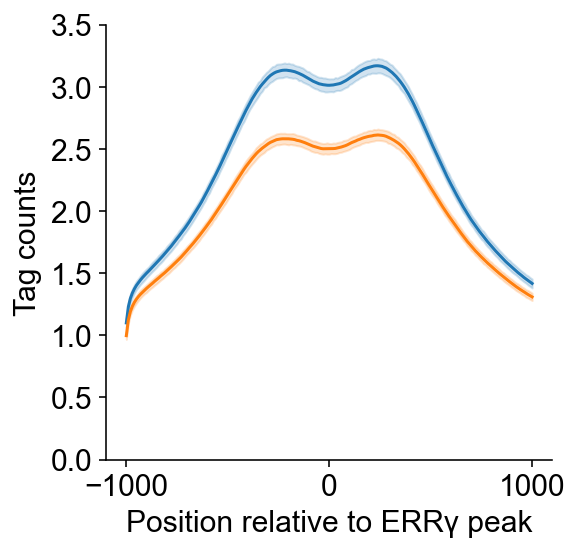

In [33]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
counts_datasets = ["H3K27Ac in WT", "H3K27Ac in ERRγ KO"]
fig = plt.figure(figsize=[4, 4], facecolor="white")
plot_counts(count_data, counts_datasets)
plt.xlabel("Position relative to ERRγ peak")
#plt.title("H3K27Ac spatial density at ERRγ peaks")
#plt.legend(bbox_to_anchor=(1.01, 0.5))
plt.gca().get_legend().remove()
#plt.subplots_adjust(wspace=0.7, right=0.65)
plt.ylim([0, 3.5])
#plt.savefig("pics/H3K27Ac_at_ERRg_peaks.png", dpi=300)
plt.savefig("pics/H3K27Ac_at_ERRg_peaks.pdf", bbox_inches="tight")

# ATAC @ ERRγ

In [205]:
atac_count_datasets = ["Control", "KO1", "KO6"]
count_file = os.path.join(outs_folder, "ATAC_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
count_data = count_data.set_index(count_data.Gene)
errg_peaks_with_h3k27ac_id = homer_tools.intersecting_peak_ids(errg_peaks_file, h3k27ac_wt_peaks_file, "_asdf")

plot_df_all = counts_plot_df(count_data, atac_count_datasets)
plot_df_all["part"] = "all"

plot_df_h3k27ac = counts_plot_df(count_data.loc[errg_peaks_with_h3k27ac_id], atac_count_datasets)
plot_df_h3k27ac["part"] = "H3K27Ac-high"

plot_df = pd.concat((plot_df_all, plot_df_h3k27ac))

Running command w/120 threads: cp 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' '_asdf_0'
Running command w/120 threads: cp 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks' '_asdf_1'
Running command w/120 threads: mergePeaks -d given _asdf_0 _asdf_1 > _asdf_2
Running command w/120 threads: rm '_asdf_0' '_asdf_1' '_asdf_2'


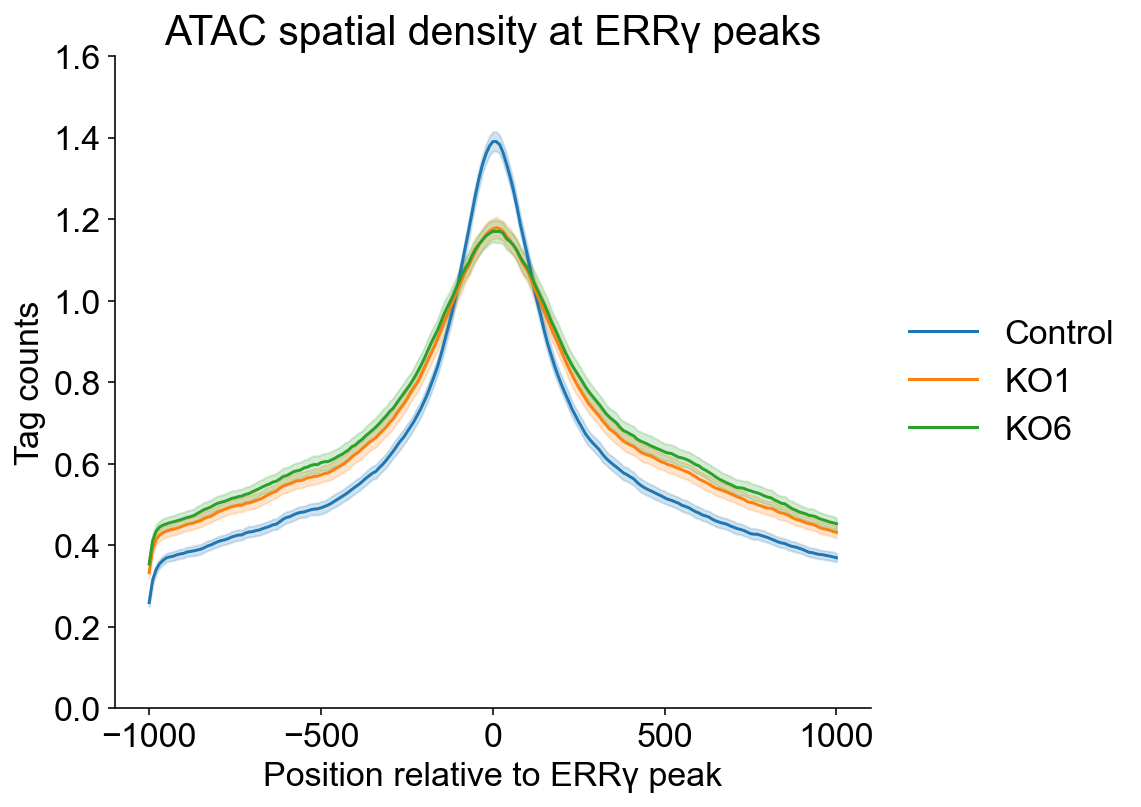

In [206]:
fig = plt.figure(figsize=[10, 6], facecolor="white")
plot_counts(count_data, atac_count_datasets)
plt.xlabel("Position relative to ERRγ peak")
plt.title("ATAC spatial density at ERRγ peaks")
plt.legend(bbox_to_anchor=(1.01, 0.5))
plt.subplots_adjust(wspace=0.7, right=0.65)
plt.ylim([0, 1.6])
plt.savefig("pics/ATAC_at_ERRg_peaks2.png", dpi=300)

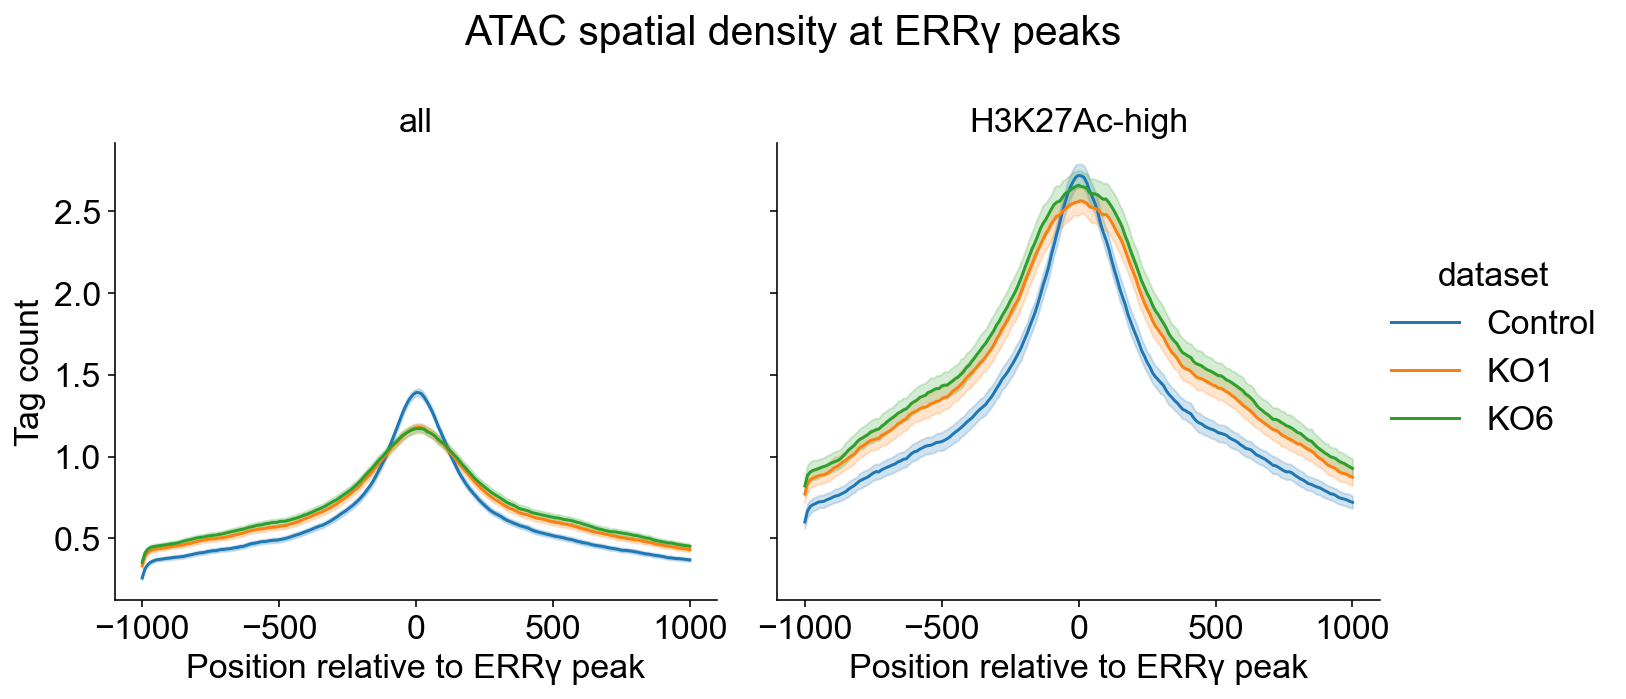

In [33]:
g = sns.FacetGrid(plot_df, hue="dataset", col="part", height=5, subplot_kws={"facecolor": "white"})
g.map(sns.lineplot, "variable", "value")
g.add_legend()
g.set_xlabels("Position relative to ERRγ peak")
g.set_ylabels("Tag count")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(wspace=0.1, top=0.8)
g.fig.suptitle(f"ATAC spatial density at ERRγ peaks")
plt.savefig(f"pics/ATAC_at_ERRg_peaks.png", dpi=300, bbox_inches='tight')  

# ATAC vs H3K27Ac changes @ ERRγ peaks

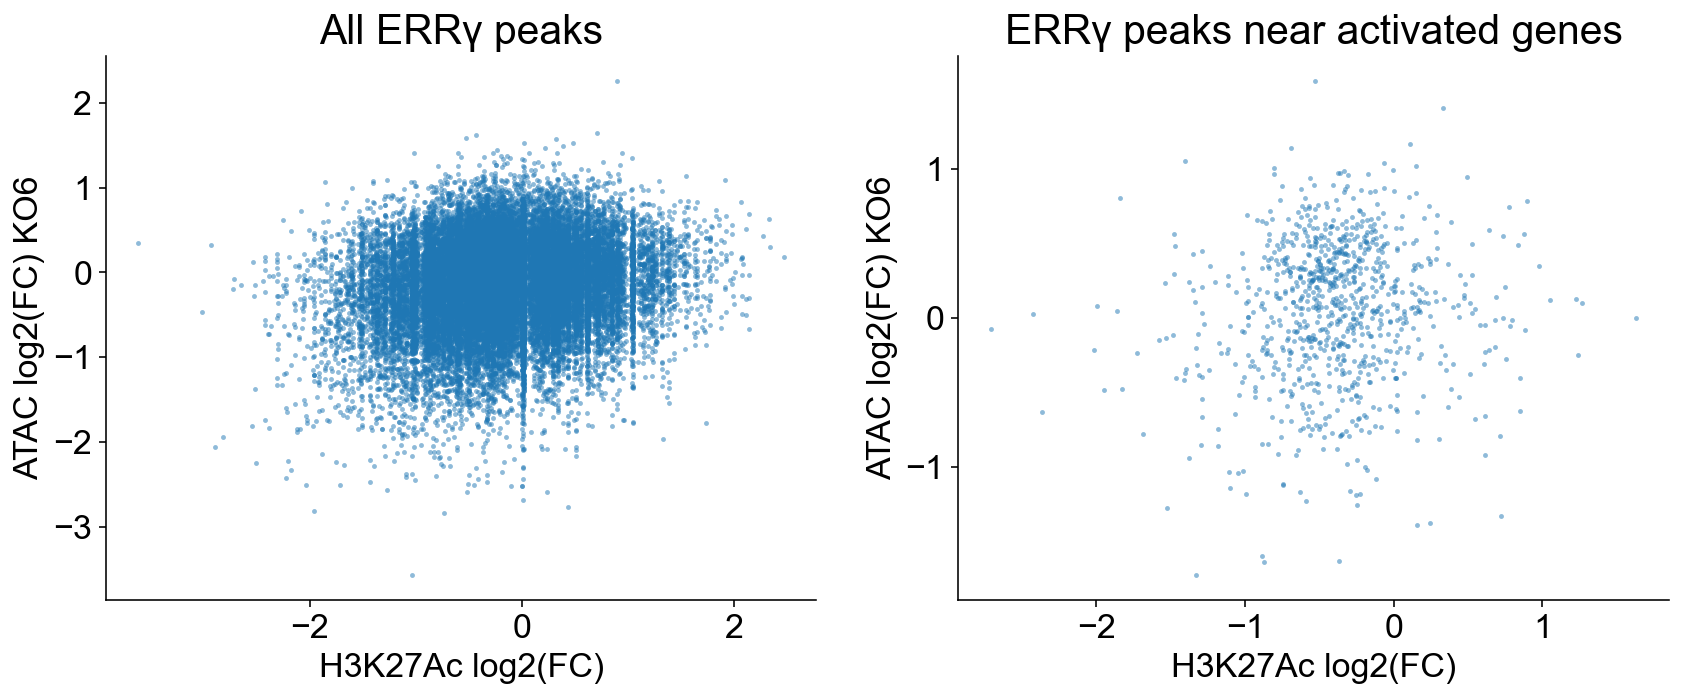

In [34]:
count_file = os.path.join(outs_folder, "ERRg_peaks_with_H3K27Ac_ATAC_levels.peaks")
count_data = pd.read_csv(count_file, sep="\t")
count_data = count_data.set_index(count_data.columns[0])
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
atac_count_datasets = ["Cont", "KO1", "KO6"]
count_data = count_data.rename(columns=dict(zip(count_data.columns[-5:], ac_count_datasets + atac_count_datasets)))
count_data.iloc[:, -5:] = np.log2(1 + count_data.iloc[:, -5:].values)
count_data["H3K27Ac log2(FC)"] = count_data["H3K27Ac-KO"] - count_data["H3K27Ac-WT"]
count_data["ATAC log2(FC) KO1"] = count_data["KO1"] - count_data["Cont"]
count_data["ATAC log2(FC) KO6"] = count_data["KO6"] - count_data["Cont"]

peak_ids_near_activated_genes = \
    homer_tools.intersecting_peak_ids(os.path.join(outs_folder, "ERRg_annotated.peaks"), 
                                      os.path.join(outs_folder, "ERRg_peaks_within_5000bp_from_activated_genes.peaks"), "_asdf")

fig = plt.figure(figsize=[14, 5])
gs = GridSpec(1, 2)
fig.add_subplot(gs[0])
sns.scatterplot(data=count_data, x="H3K27Ac log2(FC)", y = "ATAC log2(FC) KO6", s=6, alpha=0.5, linewidth=0)
plt.title("All ERRγ peaks")

fig.add_subplot(gs[1])
sns.scatterplot(data=count_data.loc[peak_ids_near_activated_genes], x="H3K27Ac log2(FC)", y = "ATAC log2(FC) KO6", s=6, alpha=0.5, linewidth=0)
plt.title("ERRγ peaks near activated genes")

plt.savefig(f"pics/ATAC_changes_vs_H3K27Ac_changes_at_ERRg_peaks.png", dpi=300, bbox_inches='tight')

In [70]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_tss_peaks.log"), threads=10)            
seq_length = 10000
tss_peaks_file = os.path.join(outs_folder, "tss.peaks")
homer_tools.make_tss_peaks(homer_genome, seq_length, tss_peaks_file, runner)
runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl tss hg38 -size 10000  > 'data/ChIP-Seq/outs/tss.peaks' && echo Finished successfully ; } >> 'logs/homer_tss_peaks.log' 2>&1


In [73]:
tss_peaks = pd.read_csv(tss_peaks_file, sep="\t")
tss_peaks.Chr = [chrom.replace("chr", "") for chrom in tss_peaks.Chr]
tss_peaks.to_csv(tss_peaks_file, sep="\t", index=False)

In [78]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
outs_folder = "data/ChIP-Seq/outs"
misc.make_sure_folder_exists(outs_folder)
count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
count_file = os.path.join(outs_folder, "H3K27Ac_at_TSS.counts")
seq_length = 5000
bin_size = 10
homer_tools.count_tags(tss_peaks_file, 
                       [os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", ds + ".tags/") for ds in count_datasets],
                      homer_genome, seq_length, runner, count_file, bin_size=bin_size, histogram=True)

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ChIP-Seq/outs/tss.peaks' hg38 -size 5000 -hist 10 -ghist -cpu 10  -d 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT.tags/' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO.tags/' > 'data/ChIP-Seq/outs/H3K27Ac_at_TSS.counts' && echo Finished successfully ; } >> 'logs/homer_count.log' 2>&1


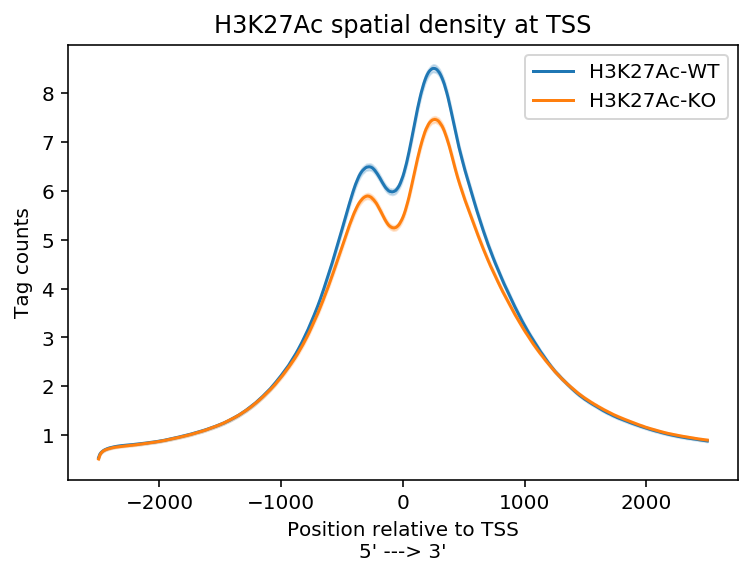

In [82]:
count_data = pd.read_csv(count_file, sep="\t")
plot_counts(count_data, counts_datasets)
plt.xlabel("Position relative to TSS\n5' ---> 3'")
plt.title("H3K27Ac spatial density at TSS")
plt.savefig("pics/H3K27Ac_at_TSS.png", dpi=300, bbox_inches='tight')

In [37]:
de_genes_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name="FPKM")
alpha = 0.05
min_abs_logfc = math.log2(1.5)
logfc_ko1 = de_genes_data.iloc[:, -4]
logfc_ko6 = de_genes_data.iloc[:, -2]
de_idx = (de_genes_data.iloc[:, -1] < alpha) & (np.abs(logfc_ko6) > min_abs_logfc) & \
    (de_genes_data.iloc[:, -3] < alpha) & (np.abs(logfc_ko1) > min_abs_logfc)

de_idx = de_idx & (np.sign(logfc_ko1) == np.sign(logfc_ko6))
assert(all(np.sign(logfc_ko1[de_idx]) == np.sign(logfc_ko6[de_idx])))

gene_id_up = de_genes_data.gene_id[de_idx & (logfc_ko1 > 0)]
gene_id_down = de_genes_data.gene_id[de_idx & (logfc_ko1 < 0)]
print(f"{de_idx.sum()} DE genes in both: {len(gene_id_up)} up, {len(gene_id_down)} down")

3216 DE genes in both: 1707 up, 1509 down


In [30]:
tss_peaks_file = os.path.join(outs_folder, "tss.peaks")
tss_peaks = pd.read_csv(tss_peaks_file, sep="\t")
tss_peak_id_down = ensembl_gene_to_peak_id(tss_peaks, gene_id_down)
tss_peak_id_up = ensembl_gene_to_peak_id(tss_peaks, gene_id_up)

In [176]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_TSS.counts")
count_data = pd.read_csv(count_file, sep="\t")
plot_df = None
for dir_name, peaks in [("up", tss_peak_id_up), ("down", tss_peak_id_down)]:
    count_data_dir = count_data[np.in1d(count_data.Gene, peaks)]
    df = counts_plot_df(count_data_dir, count_datasets)
    df["direction"] = dir_name
    plot_df = pd.concat((plot_df, df))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

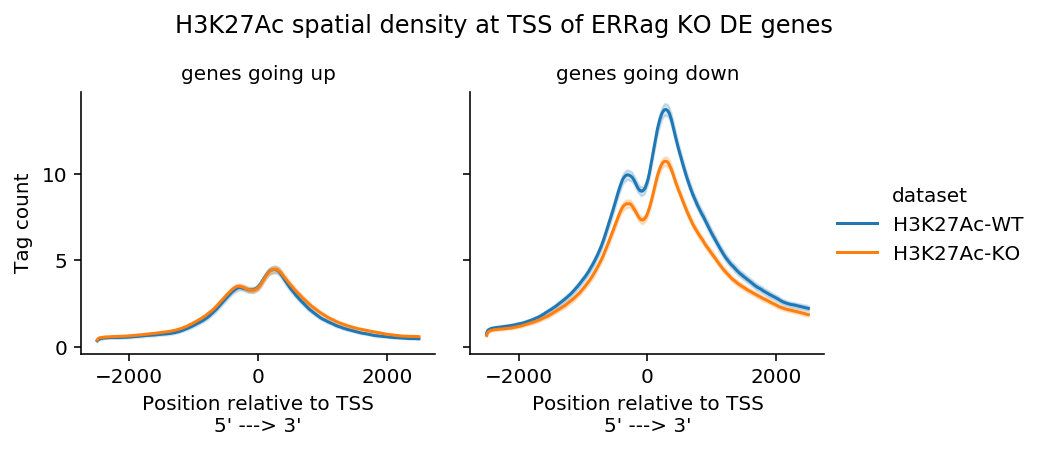

In [177]:
g = sns.FacetGrid(plot_df, hue="dataset", col="direction")
g.map(sns.lineplot, "variable", "value")
g.add_legend()
g.set_xlabels("Position relative to TSS\n5' ---> 3'")
g.set_ylabels("Tag count")
g.set_titles(col_template="genes going {col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle(f"H3K27Ac spatial density at TSS of ERRag KO DE genes")
plt.savefig(f"pics/H3K27Ac_TSS_of_DE_genes.png", dpi=300, bbox_inches='tight')    

In [59]:
long_chromnames_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks"
homer_tools.to_long_chromnames("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks", long_chromnames_peaks_file)
annotated_peaks_file = os.path.join(outs_folder, "ERRg_annotated.peaks")
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_annotation.log"), threads=10)            
homer_tools.annotate_peaks(long_chromnames_peaks_file, annotated_peaks_file, homer_genome, runner)
runner.run(dry=True)

errg_peaks = pd.read_csv(annotated_peaks_file, sep="\t", comment="#")
errg_peaks_near_up_genes = ensembl_gene_to_peak_id(errg_peaks, gene_id_up)
errg_peaks_near_down_genes = ensembl_gene_to_peak_id(errg_peaks, gene_id_down)

Would run the following command sequence:
	annotatePeaks.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' hg38     > 'data/ChIP-Seq/outs/ERRg_annotated.peaks'



In [85]:
errg_gene_dir_data = []
for max_dist in [1000000000000, max_distance_to_tss]:
    for dir, peak_ids, genes in [("up", errg_peaks_near_up_genes, gene_id_up), 
                                 ("down", errg_peaks_near_down_genes, gene_id_down)]:
        peaks = errg_peaks.loc[np.in1d(errg_peaks[errg_peaks.columns[0]], peak_ids)]
        peaks = peaks[peaks["Distance to TSS"] < max_dist]
        print(f"max dist: {max_dist}, {len(peaks)} peaks near {dir} genes, {len(set(peaks['Nearest Ensembl']))} genes")
        errg_gene_dir_data.append({"Max distance to TSS": max_dist, "DE gene change in ERRg KO": dir,
                                  "# DE genes total": len(genes), "# peaks near DE genes": len(peaks), 
                                   "# DE genes with peaks nearby": len(set(peaks['Nearest Ensembl']))})
        
errg_gene_dir_data = pd.DataFrame.from_records(errg_gene_dir_data)
errg_gene_dir_data.to_excel("tables/ERRg_peaks_vs_DE_genes_counts.xlsx", sheet_name="Counts", index=False)

max dist: 1000000000000, 2059 peaks near up genes, 767 genes
max dist: 1000000000000, 3277 peaks near down genes, 1074 genes
max dist: 5000, 979 peaks near up genes, 514 genes
max dist: 5000, 1810 peaks near down genes, 917 genes


In [79]:
errg_peaks.columns

Index(['PeakID (cmd=annotatePeaks.pl data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_long_chromnames.peaks hg38)',
       'Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type'],
      dtype='object')

In [ ]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]

plot_df = None
for dir_name, genes in [("up", gene_id_up), ("down", gene_id_down)]:
    peaks = ensembl_gene_to_peak_id(errg_peaks, genes, max_distance_to_tss=max_distance_to_tss)
    count_data_dir = count_data[np.in1d(count_data.Gene, peaks)]
    df = counts_plot_df(count_data_dir, ac_count_datasets)
    df["direction"] = dir_name
    plot_df = pd.concat((plot_df, df))

g = sns.FacetGrid(plot_df, hue="dataset", col="direction")
g.map(sns.lineplot, "variable", "value")
g.add_legend()
g.set_xlabels("Position relative to ERRg peak")
g.set_ylabels("Tag count")
g.set_titles(col_template="near genes going {col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle(f"H3K27Ac spatial density at ERRg peaks <{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_near_DE_genes.png", dpi=300, bbox_inches='tight')    

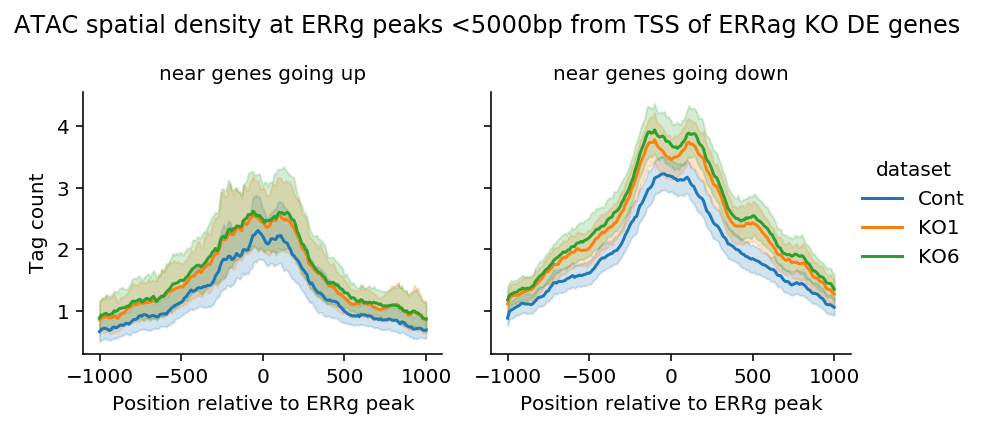

In [25]:
count_file = os.path.join(outs_folder, "ATAC_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
plot_df = None
for dir_name, genes in [("up", gene_id_up), ("down", gene_id_down)]:
    peaks = ensembl_gene_to_peak_id(errg_peaks, genes, max_distance_to_tss=max_distance_to_tss)
    count_data_dir = count_data[np.in1d(count_data.Gene, peaks)]
    df = counts_plot_df(count_data_dir, count_datasets)
    df["direction"] = dir_name
    plot_df = pd.concat((plot_df, df))

g = sns.FacetGrid(plot_df, hue="dataset", col="direction")
g.map(sns.lineplot, "variable", "value")
g.add_legend()
g.set_xlabels("Position relative to ERRg peak")
g.set_ylabels("Tag count")
g.set_titles(col_template="near genes going {col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle(f"ATAC spatial density at ERRg peaks <{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
plt.savefig(f"pics/ATAC_at_ERRg_peaks_near_DE_genes.png", dpi=300, bbox_inches='tight')    

In [204]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
plot_df = count_data.copy()
plot_df["direction"] = "not near DE genes"
plot_df.loc[np.in1d(plot_df.Gene, ensembl_gene_to_peak_id(errg_peaks, gene_id_up, max_distance_to_tss=max_distance_to_tss)), "direction"] = "up"
plot_df.loc[np.in1d(plot_df.Gene, ensembl_gene_to_peak_id(errg_peaks, gene_id_down, max_distance_to_tss=max_distance_to_tss)), "direction"] = "down"
#sns.heatmap(count_data_dir.iloc[:, 1:], yticklabels=False, xticklabels=False)

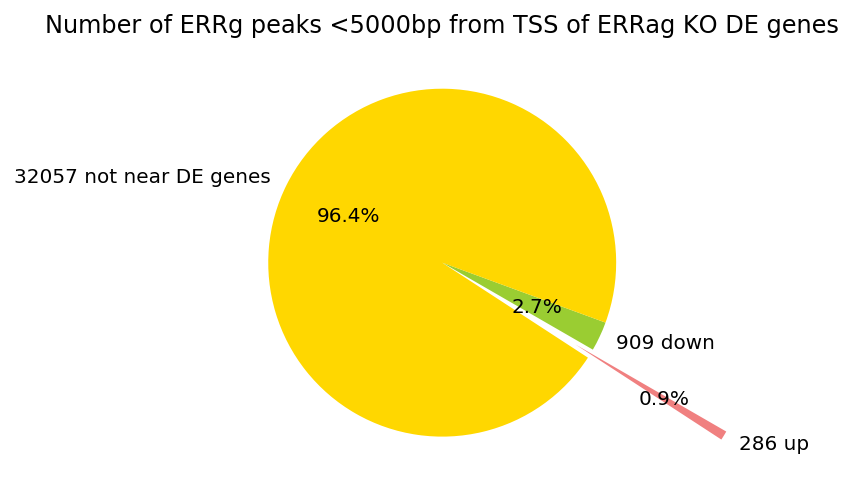

In [205]:
counts = Counter(plot_df.direction)
plt.pie(counts.values(), labels=[f"{counts[lab]} {lab}" for lab in counts.keys()], 
        autopct='%1.1f%%', colors=['yellowgreen', 'gold', 'lightcoral'], explode=(0, 0.0, 0.9), startangle=-30)

plt.title(f"Number of ERRg peaks <{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
plt.savefig("pics/peaks_count_near_DE_genes.png", dpi=300, bbox_inches='tight')

In [31]:
def peaks_heatmap(data, num_splits):
    plt.imshow(data.iloc[:, 1:-1], vmax=70, vmin=0, cmap="Reds", aspect="auto", interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("WT           ERRg KO")
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    for i in range(num_splits - 1):
        ax.vlines([(data.shape[1] - 2) // num_splits * (i + 1)], *ax.get_ylim(), colors="white")        
        
    return ax

def peaks_heatmap_by_facet(all_data, values_order, title_formatter, num_splits, xlabel):
    facet_var = all_data.iloc[:, -1]
    assert frozenset(facet_var) == frozenset(values_order)
    for i, val in enumerate(values_order):
        plt.subplot(1, len(values_order), i + 1)
        peaks_heatmap(all_data[facet_var == val], num_splits)
        title_line = title_formatter(val)
        plt.title(title_line + f"\n{(facet_var == val).sum()} peaks")
        plt.xlabel(xlabel)

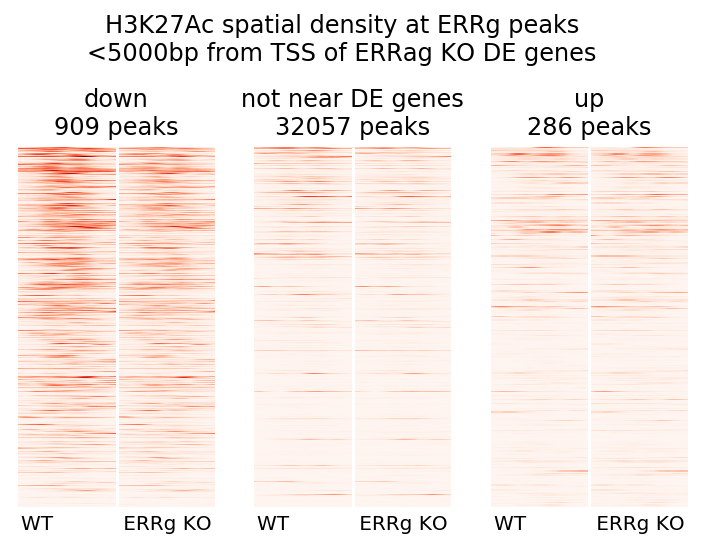

In [207]:
peaks_heatmap_by_facet(plot_df, ["down", "not near DE genes", "up"], lambda x: x, 2, "WT           ERRg KO")
plt.suptitle(f"H3K27Ac spatial density at ERRg peaks\n<{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
plt.subplots_adjust(top=0.75)
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_near_DE_genes_heatmaps.png", dpi=300)

In [26]:
count_file = os.path.join(outs_folder, "ATAC_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
plot_df = count_data.copy()
plot_df["direction"] = "not near DE genes"
plot_df.loc[np.in1d(plot_df.Gene, ensembl_gene_to_peak_id(errg_peaks, gene_id_up, max_distance_to_tss=max_distance_to_tss)), "direction"] = "up"
plot_df.loc[np.in1d(plot_df.Gene, ensembl_gene_to_peak_id(errg_peaks, gene_id_down, max_distance_to_tss=max_distance_to_tss)), "direction"] = "down"
#sns.heatmap(count_data_dir.iloc[:, 1:], yticklabels=False, xticklabels=False)

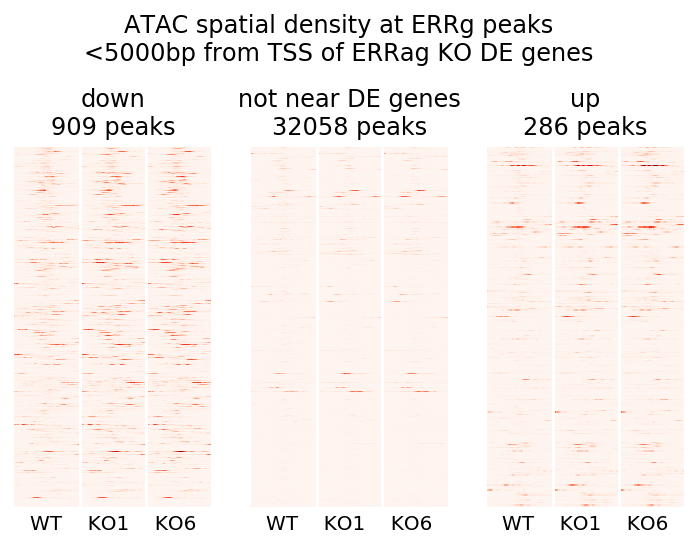

In [34]:
peaks_heatmap_by_facet(plot_df, ["down", "not near DE genes", "up"], lambda x: x, num_splits=3, xlabel="WT    KO1    KO6")
plt.suptitle(f"ATAC spatial density at ERRg peaks\n<{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
plt.subplots_adjust(top=0.75)
plt.savefig(f"pics/ATAC_at_ERRg_peaks_near_DE_genes_heatmaps.png", dpi=300)

In [41]:
errg_peaks_near_activated_genes = errg_peaks.set_index(errg_peaks.iloc[:, 0])
errg_peaks_near_activated_genes = errg_peaks_near_activated_genes.loc[ensembl_gene_to_peak_id(errg_peaks, gene_id_down, max_distance_to_tss=max_distance_to_tss),]
errg_peaks_near_activated_genes_file = f"data/ChIP-Seq/outs/ERRg_peaks_within_{max_distance_to_tss}bp_from_activated_genes.peaks"
errg_peaks_near_activated_genes.to_csv(errg_peaks_near_activated_genes_file, sep="\t", index=False)
activated_genes_with_peaks = np.unique(errg_peaks_near_activated_genes["Nearest Ensembl"])

errg_peaks_near_suppressed_genes = errg_peaks.set_index(errg_peaks.iloc[:, 0])
errg_peaks_near_suppressed_genes = errg_peaks_near_suppressed_genes.loc[ensembl_gene_to_peak_id(errg_peaks, gene_id_up, max_distance_to_tss=max_distance_to_tss),]
errg_peaks_near_suppressed_genes_file = f"data/ChIP-Seq/outs/ERRg_peaks_within_{max_distance_to_tss}bp_from_suppressed_genes.peaks"
errg_peaks_near_suppressed_genes.to_csv(errg_peaks_near_suppressed_genes_file, sep="\t", index=False)
suppressed_genes_with_peaks = np.unique(errg_peaks_near_suppressed_genes["Nearest Ensembl"])
print(f"{len(activated_genes_with_peaks)} activated, {len(suppressed_genes_with_peaks)} suppressed genes with ERRg peaks")

737 activated, 250 suppressed genes with ERRg peaks


In [264]:
res = gprofiler.plot_significant_results(activated_genes_with_peaks, pathway_analysis.libraries, gprofiler.organisms["human"],
                                         2.0, 0.05,
                                         "pics/activated genes with ERRg peaks GO", None, suffix="ERRg_activated", return_genes=True)

In [71]:
gene_ids_map = pd.read_csv("data/gene_id_map_human.tsv", sep="\t")
gene_ids_map = dict(zip(gene_ids_map["id"], gene_ids_map.name))

In [271]:
result_tables_file = "tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx"
wb = openpyxl.load_workbook(result_tables_file)
ws = wb.create_sheet(title="ERRg_activated|GO")

gprofiler.write_res_from_libraries(ws, res, pathway_analysis.libraries, enrichment_cutoff=2.0,
                                   gene_name_map=gene_ids_map)

wb.save(result_tables_file)

In [17]:
runner = parallel_run.LocalRunner("logs/homer_motifs.log")
motifs_folder = os.path.join(outs_folder, "ERRg_peaks_near_activated_genes.motifs")
homer_tools.find_motifs(errg_peaks_near_activated_genes_file, homer_genome, 200, motifs_folder, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], threads=10)

runner.run(dry=True)

Would run the following command sequence:
	findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_within_5000bp_from_activated_genes.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_near_activated_genes.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 10 



In [216]:
runner = parallel_run.LocalRunner("logs/homer_motifs.log")
motifs_folder = os.path.join(outs_folder, "ERRg_peaks_near_suppressed_genes.motifs")
homer_tools.find_motifs(errg_peaks_near_suppressed_genes_file, homer_genome, 200, motifs_folder, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18])

runner.run(dry=False)

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_within_5000bp_from_suppressed_genes.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_near_suppressed_genes.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 15  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


In [173]:
runner = parallel_run.LocalRunner("logs/homer_recenter.log")
recentered_peaks_file = os.path.join(outs_folder, "ERRg_recentered.peaks")
motifs_folder = os.path.join(outs_folder, "ERRg_peaks_near_suppressed_genes.motifs")
homer_tools.annotate_peaks(annotated_peaks_file, recentered_peaks_file, homer_genome, runner, size=200,
                           center_on_motif=os.path.join(motifs_folder, "homerResults", "motif1.motif"))

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ChIP-Seq/outs/ERRg_annotated.peaks' hg38  -center 'data/ChIP-Seq/outs/ERRg_peaks_near_suppressed_genes.motifs/homerResults/motif1.motif' -size 200  > 'data/ChIP-Seq/outs/ERRg_recentered.peaks' && echo Finished successfully ; } >> 'logs/homer_recenter.log' 2>&1


b''

In [174]:
orig_peaks = pd.read_csv(annotated_peaks_file, sep="\t", dtype=str)
orig_peaks = orig_peaks.set_index(orig_peaks.iloc[:, 0])

In [ ]:
recentered_peaks = pd.read_csv(recentered_peaks_file, sep="\t", header=None, dtype=str)
recentered_peaks_idx = recentered_peaks.iloc[:, 0].values

orig_peaks.loc[recentered_peaks_idx, "Start"] = recentered_peaks.iloc[:, 2].values
orig_peaks.loc[recentered_peaks_idx, "End"] = recentered_peaks.iloc[:, 3].values

orig_peaks = orig_peaks.iloc[np.in1d(orig_peaks.iloc[:, 0], recentered_peaks_idx), :]

all_recentered_peaks_file = os.path.join(outs_folder, "ERRg_all_recentered.peaks")
orig_peaks.to_csv(all_recentered_peaks_file, sep="\t", index=False)
all_recentered_peaks_short_chromnames = os.path.join(outs_folder, "ERRg_all_recentered_schrom.peaks")
homer_tools.to_short_chromnames(all_recentered_peaks_file, all_recentered_peaks_short_chromnames)

In [170]:
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
misc.make_sure_folder_exists(outs_folder)
count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_recentered_peaks.counts")
seq_length = 2000
bin_size = 10
homer_tools.count_tags(all_recentered_peaks_short_chromnames, 
                       [os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", ds + ".tags/") for ds in count_datasets],
                      homer_genome, seq_length, runner, count_file, bin_size=bin_size, histogram=True)

runner.run(dry=False)

NameError: name 'all_recentered_peaks_short_chromnames' is not defined

In [208]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_recentered_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
plot_df = None
for dir_name, genes in [("up", gene_id_up), ("down", gene_id_down)]:
    peaks = ensembl_gene_to_peak_id(errg_peaks, genes, max_distance_to_tss=max_distance_to_tss)
    count_data_dir = count_data[np.in1d(count_data.Gene, peaks)]
    df = counts_plot_df(count_data_dir, count_datasets)
    df["direction"] = dir_name
    plot_df = pd.concat((plot_df, df))

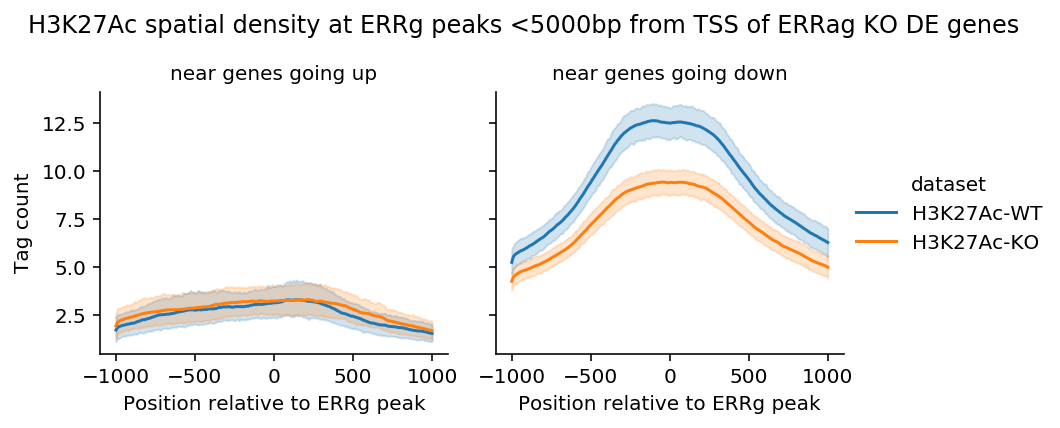

In [118]:
g = sns.FacetGrid(plot_df, hue="dataset", col="direction")
g.map(sns.lineplot, "variable", "value")
g.add_legend()
g.set_xlabels("Position relative to ERRg peak")
g.set_ylabels("Tag count")
g.set_titles(col_template="near genes going {col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle(f"H3K27Ac spatial density at ERRg peaks <{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_near_DE_genes_recentered.png", dpi=300, bbox_inches='tight')    

In [64]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
plot_df = None
for dir_name, genes in [("down", gene_id_down), ("up", gene_id_up)]:
    peaks = ensembl_gene_to_peak_id(errg_peaks, genes, max_distance_to_tss=max_distance_to_tss)
    count_data_dir = count_data[np.in1d(count_data.Gene, peaks)]
    df = counts_plot_df(count_data_dir, count_datasets)
    df["direction"] = "ERR-activated targets" if dir_name == "down" else "ERR-suppressed targets"
    plot_df = pd.concat((plot_df, df))
    
peaks_up = ensembl_gene_to_peak_id(errg_peaks, gene_id_up, max_distance_to_tss=max_distance_to_tss)
peaks_down = ensembl_gene_to_peak_id(errg_peaks, gene_id_down, max_distance_to_tss=max_distance_to_tss)
peaks_updown = list(set(peaks_up) | set(peaks_down))
count_data_dir = count_data[~np.in1d(count_data.Gene, peaks_updown)]
df = counts_plot_df(count_data_dir, count_datasets)
df["direction"] = f"All other targets"
plot_df = pd.concat((plot_df, df))
plot_df.loc[plot_df.dataset == "H3K27Ac-WT", "dataset"] = "H3K27Ac in WT"
plot_df.loc[plot_df.dataset == "H3K27Ac-KO", "dataset"] = "H3K27Ac in ERRγ KO"

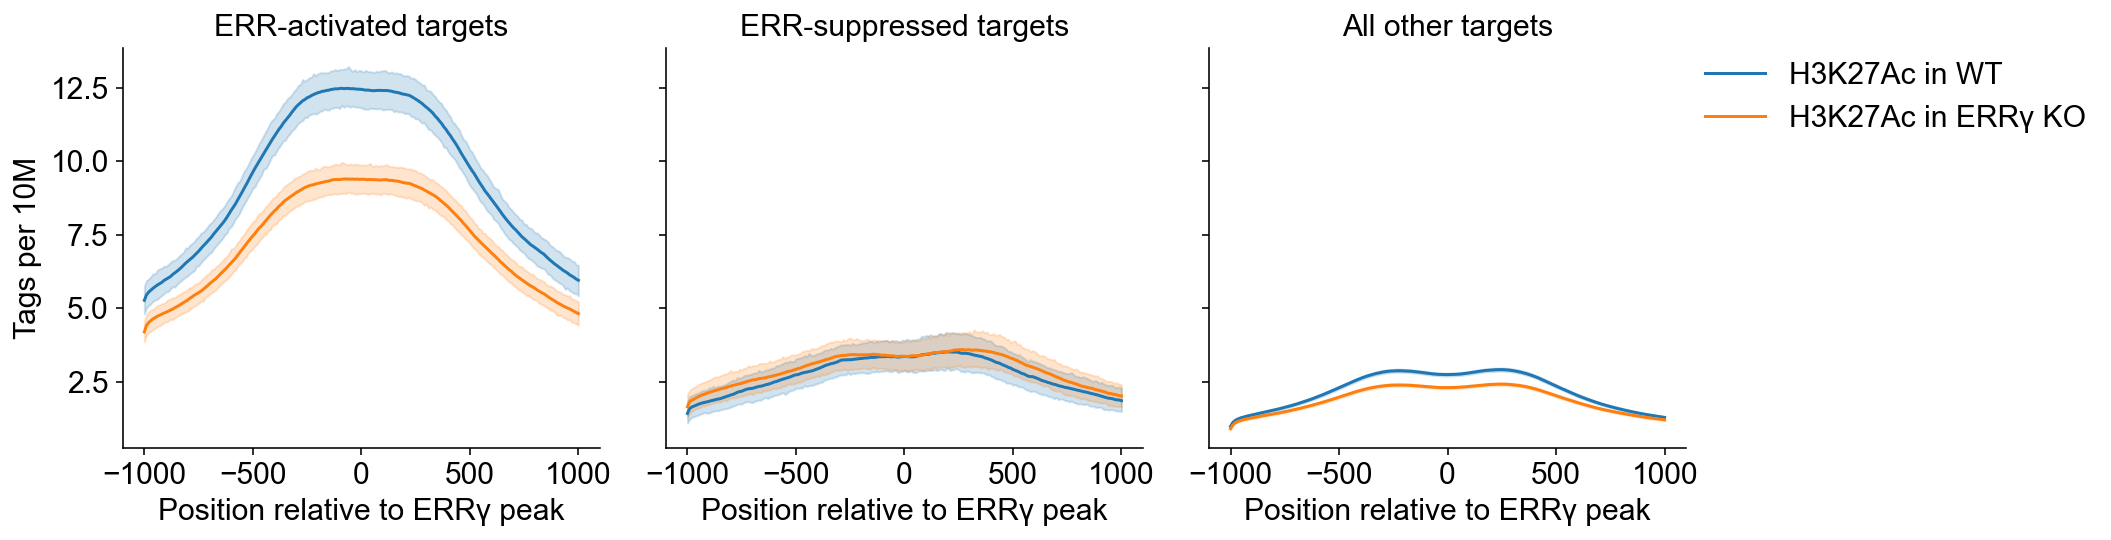

In [65]:
#plt.figure(figsize=[13, 4])
g = sns.FacetGrid(plot_df, hue="dataset", col="direction", height=4)
g.map(sns.lineplot, "variable", "value")
g.add_legend(bbox_to_anchor=(1, 0.8), title="")
g.set_xlabels("Position relative to ERRγ peak")
g.set_ylabels("Tags per 10M")
g.set_titles(col_template="{col_name}")
#plt.subplots_adjust(top=0.8)
#g.fig.suptitle(f"H3K27Ac spatial density at ERRg peaks <{max_distance_to_tss}bp from TSS of ERRag KO DE genes")
#plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_near_DE_genes_with_neutral.png", dpi=300, bbox_inches='tight')    
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.gca().legend(handles=handles[1:], labels=labels[1:])
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_near_DE_genes_with_neutral.pdf", bbox_inches='tight')    

In [209]:
plot_df = count_data.copy()
plot_df["direction"] = "not near DE genes"
plot_df.loc[np.in1d(plot_df.Gene, ensembl_gene_to_peak_id(errg_peaks, gene_id_up, max_distance_to_tss=max_distance_to_tss)), "direction"] = "up"
plot_df.loc[np.in1d(plot_df.Gene, ensembl_gene_to_peak_id(errg_peaks, gene_id_down, max_distance_to_tss=max_distance_to_tss)), "direction"] = "down"
#sns.heatmap(count_data_dir.iloc[:, 1:], yticklabels=False, xticklabels=False)

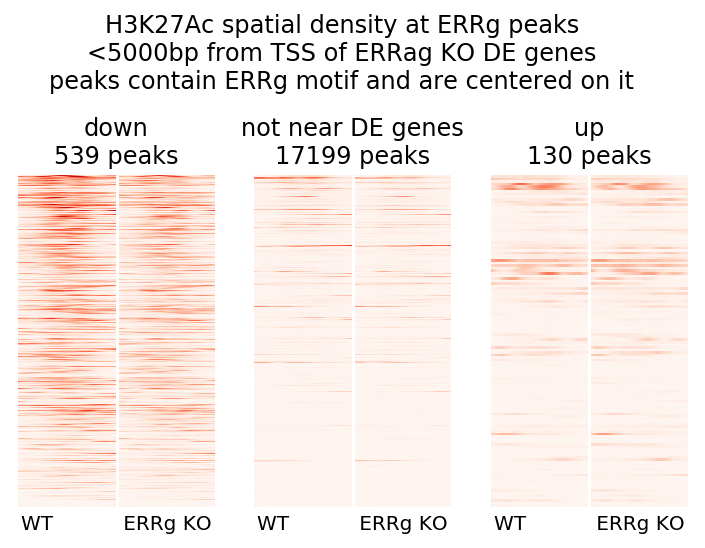

In [201]:
peaks_heatmap_by_facet(plot_df, ["down", "not near DE genes", "up"], lambda x: x)
plt.suptitle(f"H3K27Ac spatial density at ERRg peaks\n<{max_distance_to_tss}bp from TSS of ERRag KO DE genes\npeaks contain ERRg motif and are centered on it")
plt.subplots_adjust(top=0.7)
plt.savefig(f"pics/H3K27Ac_at_ERRg_recentered_peaks_near_DE_genes_heatmaps.png", dpi=300)

In [210]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")

plot_df = None
for motif_presence in [True, False]:
    has_motif = np.in1d(count_data.Gene, recentered_peaks_idx)
    if not motif_presence:
        has_motif = ~has_motif
        
    count_data_dir = count_data[has_motif]
    df = counts_plot_df(count_data_dir, count_datasets)
    df["has_motif"] = motif_presence
    plot_df = pd.concat((plot_df, df))

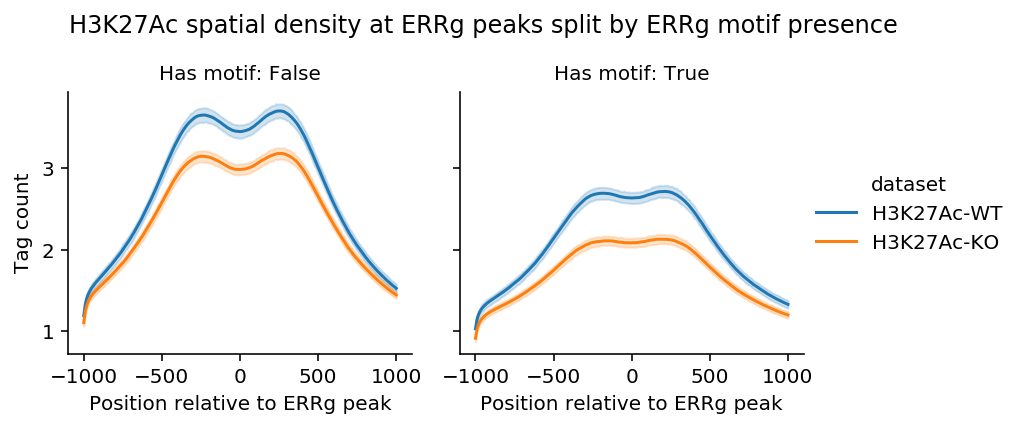

In [129]:
g = sns.FacetGrid(plot_df, hue="dataset", col="has_motif")
g.map(sns.lineplot, "variable", "value")
g.add_legend()
g.set_xlabels("Position relative to ERRg peak")
g.set_ylabels("Tag count")
g.set_titles(col_template="Has motif: {col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle(f"H3K27Ac spatial density at ERRg peaks split by ERRg motif presence")
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_by_motif.png", dpi=300, bbox_inches='tight')    

In [211]:
plot_df = count_data.copy()
plot_df["has_motif"] = np.in1d(count_data.Gene, recentered_peaks_idx)

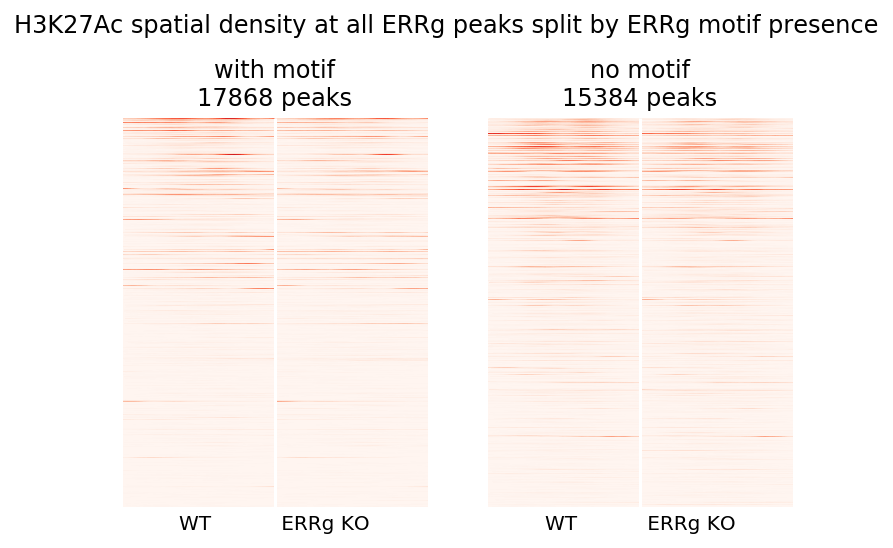

In [212]:
peaks_heatmap_by_facet(plot_df, [True, False], lambda m: "with motif" if m else "no motif")
plt.suptitle(f"H3K27Ac spatial density at all ERRg peaks split by ERRg motif presence")
plt.subplots_adjust(top=0.8)
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_by_motif_heatmaps.png", dpi=300)

In [6]:
annotated_peaks_file = os.path.join(outs_folder, "ERRg_annotated.peaks")
runner = parallel_run.LocalRunner(os.path.join("logs", f"homer_count.log"), threads=10)            
count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg.peaks")
seq_length = 200
annotated_short_chrom = os.path.join(outs_folder, "ERRg_annotated_schrom.peaks")
homer_tools.to_short_chromnames(annotated_peaks_file, annotated_short_chrom)
homer_tools.count_tags(annotated_short_chrom, 
                       [os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", f"{ds}.tags/") 
                        for ds in count_datasets],
                      homer_genome, seq_length, runner, count_file)

runner.run(dry=False)

Running the following command sequence:
{ annotatePeaks.pl 'data/ChIP-Seq/outs/ERRg_annotated_schrom.peaks' hg38 -size 200  -cpu 10  -d 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-WT.tags/' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/H3K27Ac-KO.tags/' > 'data/ChIP-Seq/outs/H3K27Ac_at_ERRg.peaks' && echo Finished successfully ; } >> 'logs/homer_count.log' 2>&1


In [41]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [38]:
annotated_peaks_file = os.path.join(outs_folder, "ERRg_annotated.peaks")
errg_peaks = pd.read_csv(annotated_peaks_file, sep="\t", comment="#")
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg.peaks")
counts_data = pd.read_csv(count_file, sep="\t")
counts_data["direction"] = "stable"
counts_data.loc[np.in1d(counts_data.iloc[:, 0], ensembl_gene_to_peak_id(errg_peaks, gene_id_up)), "direction"] = "up"
counts_data.loc[np.in1d(counts_data.iloc[:, 0], ensembl_gene_to_peak_id(errg_peaks, gene_id_down)), "direction"] = "down"

In [39]:
ac_wt = counts_data.iloc[:, -3]
ac_ko = counts_data.iloc[:, -2]

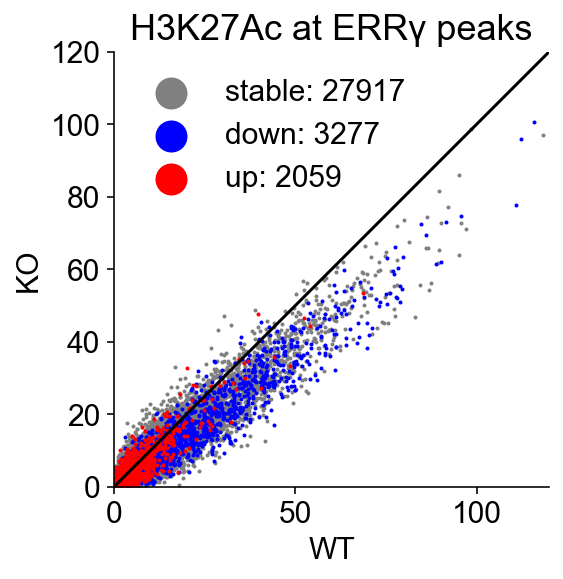

In [46]:
for d, c in [("stable", "gray"), ("down", "blue"), ("up", "red")]:
    idx = counts_data.direction == d
    plt.scatter(ac_wt[idx], ac_ko[idx], c=c, s=1, label=f"{d}: {idx.sum()}")

plt.gca().set_aspect('equal')
plt.gca().legend()
plt.xlim([0, 120])
plt.ylim([0, 120])
add_identity(plt.gca(), color="black")
plt.xlabel("WT")
plt.ylabel("KO")
plt.title("H3K27Ac at ERRγ peaks")
plt.legend(bbox_to_anchor=(0, 1), markerscale=15)
#plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_scatter_all_peaks.png", dpi=300, bbox_inches="tight")
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_scatter_all_peaks.pdf", bbox_inches="tight")

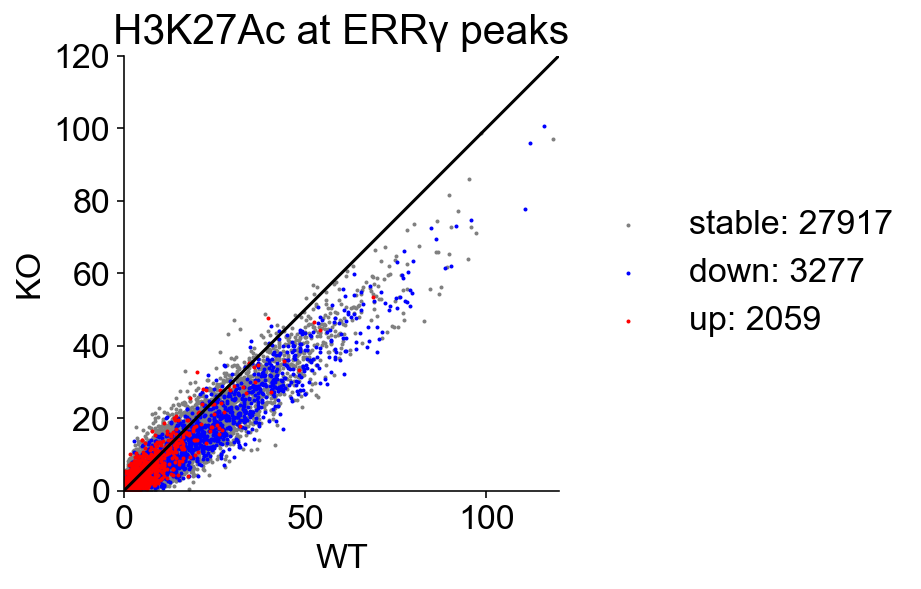

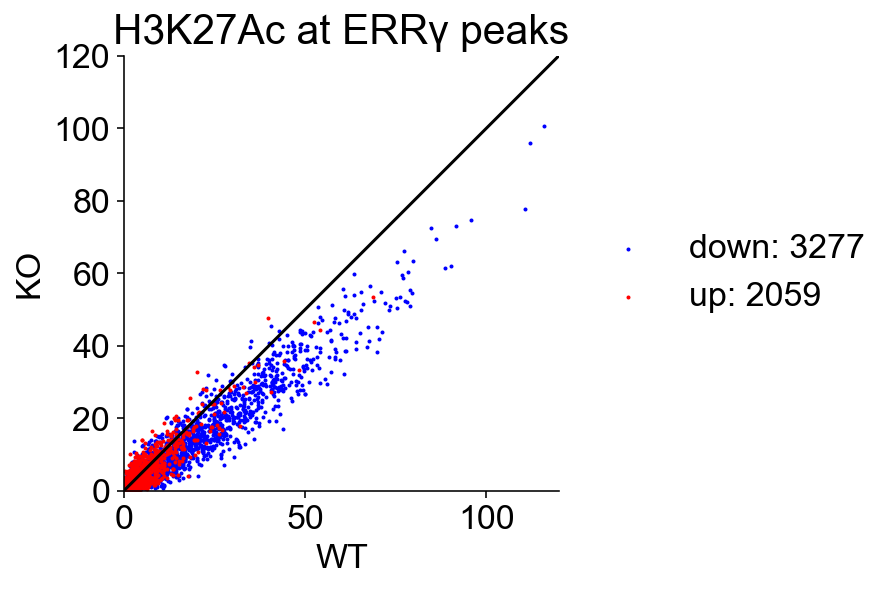

In [335]:
plt.figure()
for d, c in [("down", "blue"), ("up", "red")]:
    idx = counts_data.direction == d
    plt.scatter(ac_wt[idx], ac_ko[idx], c=c, s=1, label=f"{d}: {idx.sum()}")

plt.gca().set_aspect('equal')
plt.gca().legend()
plt.xlim([0, 120])
plt.ylim([0, 120])
add_identity(plt.gca(), color="black")
plt.xlabel("WT")
plt.ylabel("KO")
plt.title("H3K27Ac at ERRγ peaks")
plt.legend(bbox_to_anchor=(1.01, 0.5))
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_scatter_near_de_genes_only.png", dpi=300, bbox_inches="tight")

In [151]:
counts_data["ac_down"] = (ac_wt > 15) & (ac_wt > ac_ko * 1.2)
counts_data["ac_up"] = (ac_ko > 5) & (ac_ko > ac_wt * 1.1)

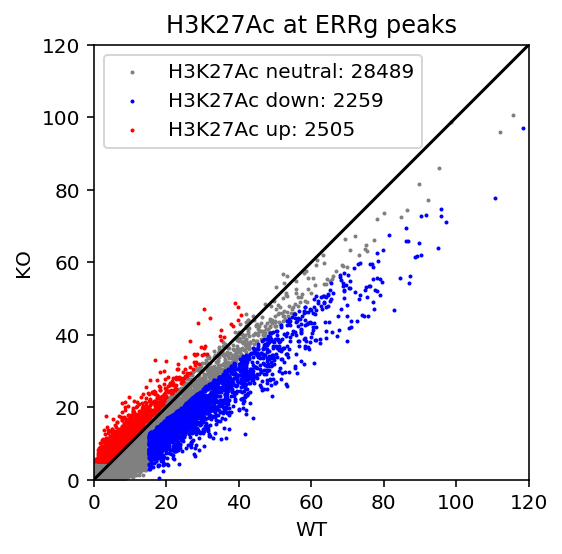

In [186]:
plt.figure()
for d, c, s in [("H3K27Ac neutral", "gray", "none"), ("H3K27Ac down", "blue", "down"), ("H3K27Ac up", "red", "up")]:
    if s == "none":
        idx = ~counts_data.ac_down & ~counts_data.ac_up
    elif s == "up":
        idx = counts_data.ac_up
    elif s == "down":
        idx = counts_data.ac_down
        
    plt.scatter(ac_wt[idx], ac_ko[idx], c=c, s=1, label=f"{d}: {idx.sum()}")

plt.gca().set_aspect('equal')
plt.gca().legend()
plt.xlim([0, 120])
plt.ylim([0, 120])
add_identity(plt.gca(), color="black")
plt.xlabel("WT")
plt.ylabel("KO")
plt.title("H3K27Ac at ERRg peaks")
plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_scatter_ac_updown.png", dpi=300)

In [156]:
def motifs_in_selection(selection, name):
    selected_peaks = counts_data[selection]
    selected_peaks_file = os.path.join(outs_folder, f"ERRg_peaks_with_{name}.peaks")
    selected_peaks.to_csv(selected_peaks_file, sep="\t", index=False)

    runner = parallel_run.LocalRunner("logs/homer_motifs.log")
    motifs_folder = os.path.join(outs_folder, f"ERRg_peaks_with_{name}.motifs")
    selected_peaks_lc = os.path.join(outs_folder, f"ERRg_peaks_with_{name}_lchrom.peaks")
    homer_tools.to_long_chromnames(selected_peaks_file, selected_peaks_lc)
    homer_tools.find_motifs(selected_peaks_lc, homer_genome, 200, motifs_folder, runner, 
                            number_of_motifs=15, lengths=[10, 12, 14, 16, 18])

    runner.run(dry=False)
    
def motifs_in_selection_contrast(selection, selection_bg, name, name_bg):
    selected_peaks = counts_data[selection]
    selected_peaks_file = os.path.join(outs_folder, f"ERRg_peaks_with_{name}.peaks")
    selected_peaks.to_csv(selected_peaks_file, sep="\t", index=False)

    selected_peaks_bg = counts_data[selection_bg]
    selected_peaks_bg_file = os.path.join(outs_folder, f"ERRg_peaks_with_{name_bg}.peaks")
    selected_peaks_bg.to_csv(selected_peaks_bg_file, sep="\t", index=False)
    
    runner = parallel_run.LocalRunner("logs/homer_motifs.log")
    motifs_folder = os.path.join(outs_folder, f"ERRg_peaks_with_{name}_vs_{name_bg}.motifs")
    selected_peaks_lc = os.path.join(outs_folder, f"ERRg_peaks_with_{name}_lchrom.peaks")
    homer_tools.to_long_chromnames(selected_peaks_file, selected_peaks_lc)
    selected_peaks_bg_lc = homer_tools.to_long_chromnames(selected_peaks_bg_file)
    homer_tools.find_motifs(selected_peaks_lc, homer_genome, 200, motifs_folder, runner, 
                            number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=selected_peaks_bg_lc)

    runner.run(dry=False)    

In [157]:
parallel_run.start(lambda: motifs_in_selection(counts_data.ac_down, "H3K27Ac_down"))

<Process name='Process-3' pid=1972451 parent=695559 started>

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_lchrom.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 120   && zip -r data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down.motifs.zip data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down.motifs && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


In [158]:
parallel_run.start(lambda: motifs_in_selection_contrast(counts_data.ac_down, ~counts_data.ac_down, "H3K27Ac_down", "H3K27Ac_not_down"))

<Process name='Process-4' pid=1972614 parent=695559 started>

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_lchrom.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_vs_H3K27Ac_not_down.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 120 -h -bg data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_not_down.lchrom.peaks  && zip -r data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_vs_H3K27Ac_not_down.motifs.zip data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_vs_H3K27Ac_not_down.motifs && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


In [159]:
parallel_run.start(lambda: motifs_in_selection_contrast(counts_data.ac_down, (~counts_data.ac_down) & (~counts_data.ac_up), "H3K27Ac_down", "H3K27Ac_no_change"))

<Process name='Process-5' pid=1987269 parent=695559 started>

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_lchrom.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_vs_H3K27Ac_no_change.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 120 -h -bg data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_no_change.lchrom.peaks  && zip -r data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_vs_H3K27Ac_no_change.motifs.zip data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_vs_H3K27Ac_no_change.motifs && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


In [264]:
motifs_in_selection(counts_data.ac_down & (counts_data.direction == "down"), "H3K27Ac_down_and_gene_down")

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_and_gene_down_lchrom.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_and_gene_down.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 15  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


In [ ]:
parallel_run.start(lambda: motifs_in_selection((~counts_data.ac_down) & (~counts_data.ac_up), "H3K27Ac_no_change"))

In [265]:
motifs_in_selection(counts_data.ac_down & (counts_data.direction == "up"), "H3K27Ac_down_and_gene_up")

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_and_gene_up_lchrom.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_and_gene_up.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 15  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


In [26]:
motifs_in_selection(counts_data.ac_up, "H3K27Ac_up")

Running the following command sequence:
{ findMotifsGenome.pl data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_up_lchrom.peaks hg38 data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_up.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 15  && echo Finished successfully ; } >> 'logs/homer_motifs.log' 2>&1


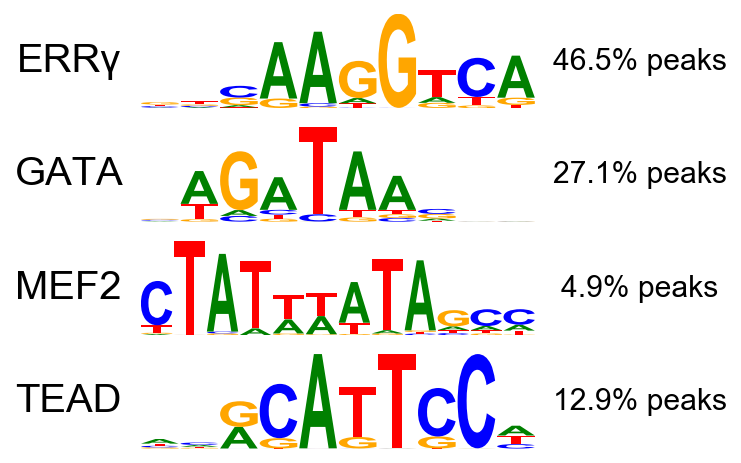

In [30]:
homer_logos_table.make_logos_table(os.path.join(outs_folder, "ERRg_peaks_with_H3K27Ac_up.motifs", "homerResults"), "pics/H3K27Ac_at_ERRg_peaks_up_motifs.png", 
                                   ["1+ERRγ", "2+GATA", "3+MEF2", "4+TEAD"])

# ERRγ-containing H3K27Ac regions (WT)

Running command w/120 threads: mergePeaks -d given 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' 'data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks' -matrix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.matrix' -gsize 900000000.0 -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.peaks'


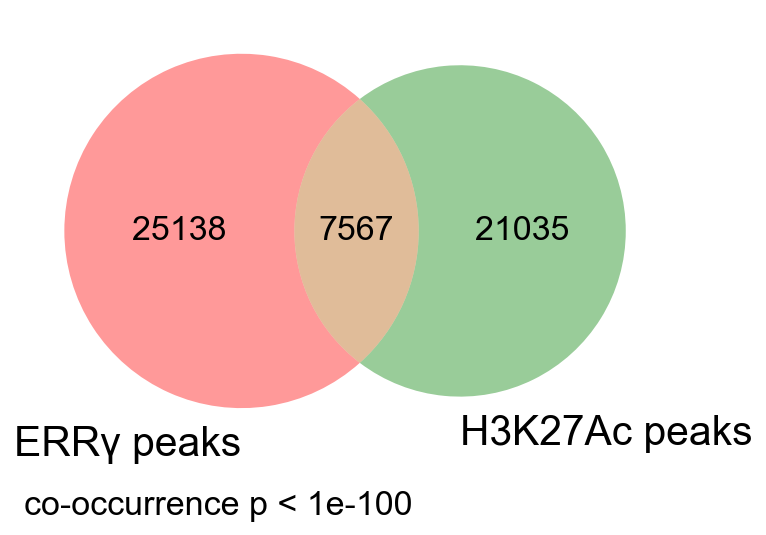

In [182]:
errg_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
h3k27ac_wt_peaks_file = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks"
fig = plt.figure(facecolor="white")
homer_tools.compare_peaks(errg_peaks_file, h3k27ac_wt_peaks_file, "ERRγ peaks", "H3K27Ac peaks", genome_size=9e8)
plt.savefig("pics/ERRg_H3K27Ac_peaks_intersection.png", dpi=300)

In [187]:
!mergePeaks '{errg_peaks_file}' '{h3k27ac_wt_peaks_file}' -cobound 1 -prefix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_vs_h3k27ac'
errg_with_h3k27ac_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_vs_h3k27ac.coBoundBy1.txt"
errg_with_h3k27ac_annotated = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac.annotated.peaks"
homer_tools.annotate_peaks(errg_with_h3k27ac_file, errg_with_h3k27ac_annotated, homer_genome, short_chrom_names=True)
errg_with_h3k27ac_data = pd.read_csv(errg_with_h3k27ac_annotated, sep="\t")

	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks	8115	2.15	-10498.95

	Co-bound by 0 peaks: 25138
	Co-bound by 1 peaks: 8115 (max: 8115 effective total)
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_vs_h3k27ac.coBoundBy1.lchrom.peaks' hg38     > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac.annotated.peaks'


In [195]:
peak_id_up = ensembl_gene_to_peak_id(errg_with_h3k27ac_data, gene_id_up)
peak_id_down = ensembl_gene_to_peak_id(errg_with_h3k27ac_data, gene_id_down)
peak_id_stable = list(set(errg_with_h3k27ac_data.iloc[:, 0]) - set(peak_id_up) - set(peak_id_down))
print(f"{len(peak_id_up)} peaks near up genes; {len(peak_id_down)} peaks near down genes; {len(peak_id_stable)} other peaks")
for name, peaks in [("near_up_genes", peak_id_up), ("near_down_genes", peak_id_down), ("not_near_de_genes", peak_id_stable)]:
    data = errg_with_h3k27ac_data.loc[np.in1d(errg_with_h3k27ac_data.iloc[:, 0], list(peaks)), :]
    data.to_csv(f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_{name}.peaks", sep="\t", index=False)

296 peaks near up genes; 1322 peaks near down genes; 6497 other peaks


In [197]:
motifs_folder = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs"
misc.make_sure_folder_exists(motifs_folder)
for name in ["near_up_genes", "near_down_genes", "not_near_de_genes"]:
    peak_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_{name}.peaks"
    motifs_dest = os.path.join(motifs_folder, f"errg_with_h3k27ac_{name}.peaks")
    
    runner = parallel_run.LocalRunner(f"logs/errg_with_h3k27ac_{name}.log")
    homer_tools.find_motifs(peak_file, homer_genome, 200, motifs_dest, runner, 
                            number_of_motifs=15, lengths=[10, 12, 14, 16, 18])

    runner.run(wait=False)    

Running the following command sequence in parallel:
{ findMotifsGenome.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_up_genes.peaks' hg38 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_up_genes.peaks' -size 200  -S 15 -len 10,12,14,16,18 -p 120   && zip -r data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_up_genes.peaks.zip data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_up_genes.peaks && echo Finished successfully ; } >> 'logs/errg_with_h3k27ac_near_up_genes.log' 2>&1
Running the following command sequence in parallel:
{ findMotifsGenome.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_down_genes.peaks' hg38 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_down_genes.peaks' -size 200  -S 15 -len 10,12,14,16,18 -p 120   && zip -r data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_20

In [199]:
peaks_near_down_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_down_genes.peaks"
peaks_near_up_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_up_genes.peaks"
motifs_dest = os.path.join(motifs_folder, f"errg_with_h3k27ac_near_down_vs_near_up2.peaks")
runner = parallel_run.LocalRunner(f"logs/errg_with_h3k27ac_near_down_vs_near_up2.log")
homer_tools.find_motifs(peaks_near_down_file, homer_genome, 200, motifs_dest, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=peaks_near_up_file)

runner.run(wait=False)    

peaks_near_stable_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_not_near_de_genes.peaks"
motifs_dest = os.path.join(motifs_folder, f"errg_with_h3k27ac_near_down_vs_not_near_de.peaks")
runner = parallel_run.LocalRunner(f"logs/errg_with_h3k27ac_near_down_vs_not_near_de.log")
homer_tools.find_motifs(peaks_near_down_file, homer_genome, 200, motifs_dest, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=peaks_near_stable_file)

runner.run(wait=False)    

Running the following command sequence in parallel:
{ findMotifsGenome.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_down_genes.peaks' hg38 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_down_vs_near_up2.peaks' -size 200  -S 15 -len 10,12,14,16,18 -p 120 -h -bg 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_up_genes.peaks'  && zip -r 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_down_vs_near_up2.peaks.zip' 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_down_vs_near_up2.peaks' && echo Finished successfully ; } >> 'logs/errg_with_h3k27ac_near_down_vs_near_up2.log' 2>&1
Running the following command sequence in parallel:
{ findMotifsGenome.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_down_genes.peaks' hg38 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg

In [231]:
peaks_near_down_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_down_genes.peaks"
peaks_near_up_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_up_genes.peaks"
motifs_dest = os.path.join(motifs_folder, f"errg_with_h3k27ac_near_up_vs_near_down.peaks")
runner = parallel_run.LocalRunner(f"logs/errg_with_h3k27ac_near_up_vs_near_down.log")
homer_tools.find_motifs(peaks_near_up_file, homer_genome, 200, motifs_dest, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=peaks_near_down_file)

runner.run(wait=False)    

peaks_near_stable_file = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_not_near_de_genes.peaks"
motifs_dest = os.path.join(motifs_folder, f"errg_with_h3k27ac_near_up_vs_not_near_de.peaks")
runner = parallel_run.LocalRunner(f"logs/errg_with_h3k27ac_near_up_vs_not_near_de.log")
homer_tools.find_motifs(peaks_near_up_file, homer_genome, 200, motifs_dest, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=peaks_near_stable_file)

runner.run(wait=False)    

Running the following command sequence in parallel:
{ findMotifsGenome.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_up_genes.peaks' hg38 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_up_vs_near_down.peaks' -size 200  -S 15 -len 10,12,14,16,18 -p 120 -h -bg 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_down_genes.peaks'  && zip -r 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_up_vs_near_down.peaks.zip' 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_h3k27ac_near_up_vs_near_down.peaks' && echo Finished successfully ; } >> 'logs/errg_with_h3k27ac_near_up_vs_near_down.log' 2>&1
Running the following command sequence in parallel:
{ findMotifsGenome.pl 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/errg_with_h3k27ac_near_up_genes.peaks' hg38 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/motifs/errg_with_

In [60]:
tss_peaks_file = os.path.join(outs_folder, "tss.peaks")
tss_peaks = pd.read_csv(tss_peaks_file, sep="\t")
tss_peaks = tss_peaks.set_index(tss_peaks.iloc[:, 0])
tss_peak_id_down = ensembl_gene_to_peak_id(tss_peaks, gene_id_down)
tss_peak_id_up = ensembl_gene_to_peak_id(tss_peaks, gene_id_up)
#tss_peak_regulated_id = pd.concat((tss_peak_id_down, tss_peak_id_up))
tss_peak_regulated_id = tss_peak_id_down

In [73]:
def motifs_in_tss_near_genes(selected_gene_ids, base_name):
    tss_peak_id_selected = ensembl_gene_to_peak_id(tss_peaks, selected_gene_ids)
    tss_peaks_selected = tss_peaks.loc[tss_peak_id_selected, :]
    selected_peaks_file = os.path.join(outs_folder, f"{base_name}.peaks")
    tss_peaks_selected.to_csv(selected_peaks_file, sep="\t", index=False)
    selected_peaks_file_lc = os.path.join(outs_folder, f"{base_name}_lc.peaks")
    homer_tools.to_long_chromnames(selected_peaks_file, selected_peaks_file_lc)
    
    runner = parallel_run.LocalRunner(f"logs/homer_motifs_{base_name}.log")
    motifs_folder_selected = os.path.join(outs_folder, f"{base_name}.motifs")
    homer_tools.find_motifs(selected_peaks_file_lc, homer_genome, "-300,100", motifs_folder_selected, runner, number_of_motifs=15, lengths=[10, 12, 14, 16, 18],
                           redundant=0.8)

    runner.run(dry=False, wait=False)

In [6]:
metabolic_process_go_term = "GO:0008152"
heart_contraction_go_term = "GO:0060047"
metabolic_process_genes = gprofiler.query_convert([metabolic_process_go_term], "ENSG", gprofiler.organisms["human"])
heart_contraction_genes = gprofiler.query_convert([heart_contraction_go_term], "ENSG", gprofiler.organisms["human"])

In [74]:
motifs_in_tss_near_genes(list(set(gene_id_down) & set(metabolic_process_genes.converted)), "down_metabolic_tss_regions")

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/outs/down_metabolic_tss_regions_lc.peaks hg38 data/ChIP-Seq/outs/down_metabolic_tss_regions.motifs -size -300,100  -S 15 -len 10,12,14,16,18 -p 15  -redundant 0.8 && echo Finished successfully ; } >> 'logs/homer_motifs_down_metabolic_tss_regions.log' 2>&1


In [76]:
motifs_in_tss_near_genes(list(set(gene_id_down) & set(heart_contraction_genes.converted)), "down_heart_tss_regions")

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/outs/down_heart_tss_regions_lc.peaks hg38 data/ChIP-Seq/outs/down_heart_tss_regions.motifs -size -300,100  -S 15 -len 10,12,14,16,18 -p 15  -redundant 0.8 && echo Finished successfully ; } >> 'logs/homer_motifs_down_heart_tss_regions.log' 2>&1


In [7]:
annotated_peaks_file = os.path.join(outs_folder, "ERRg_annotated.peaks")
errg_peak_data = pd.read_csv(annotated_peaks_file, sep="\t")
errg_peak_data = errg_peak_data.set_index(errg_peak_data.iloc[:, 0])

In [89]:
def motifs_errg_peaks_near_genes(selected_gene_ids, base_name):
    errg_peak_id_selected = ensembl_gene_to_peak_id(errg_peak_data, selected_gene_ids)
    errg_peaks_selected = errg_peak_data.loc[errg_peak_id_selected, :]
    selected_peaks_file = os.path.join(outs_folder, f"{base_name}.peaks")
    errg_peaks_selected.to_csv(selected_peaks_file, sep="\t", index=False)
    
    runner = parallel_run.LocalRunner(f"logs/homer_motifs_{base_name}.log")
    motifs_folder_selected = os.path.join(outs_folder, f"{base_name}.motifs")
    homer_tools.find_motifs(selected_peaks_file, homer_genome, 200, motifs_folder_selected, runner, number_of_motifs=15, lengths=[10, 12, 14, 16, 18],
                           redundant=0.8)

    runner.run(dry=False, wait=False)

In [90]:
motifs_errg_peaks_near_genes(list(set(gene_id_down) & set(metabolic_process_genes.converted)), "down_metabolic_errg_peaks")

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/outs/down_metabolic_errg_peaks.peaks hg38 data/ChIP-Seq/outs/down_metabolic_errg_peaks.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 15  -redundant 0.8 && echo Finished successfully ; } >> 'logs/homer_motifs_down_metabolic_errg_peaks.log' 2>&1


In [91]:
motifs_errg_peaks_near_genes(list(set(gene_id_down) & set(heart_contraction_genes.converted)), "down_heart_errg_peaks")

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/outs/down_heart_errg_peaks.peaks hg38 data/ChIP-Seq/outs/down_heart_errg_peaks.motifs -size 200  -S 15 -len 10,12,14,16,18 -p 15  -redundant 0.8 && echo Finished successfully ; } >> 'logs/homer_motifs_down_heart_errg_peaks.log' 2>&1


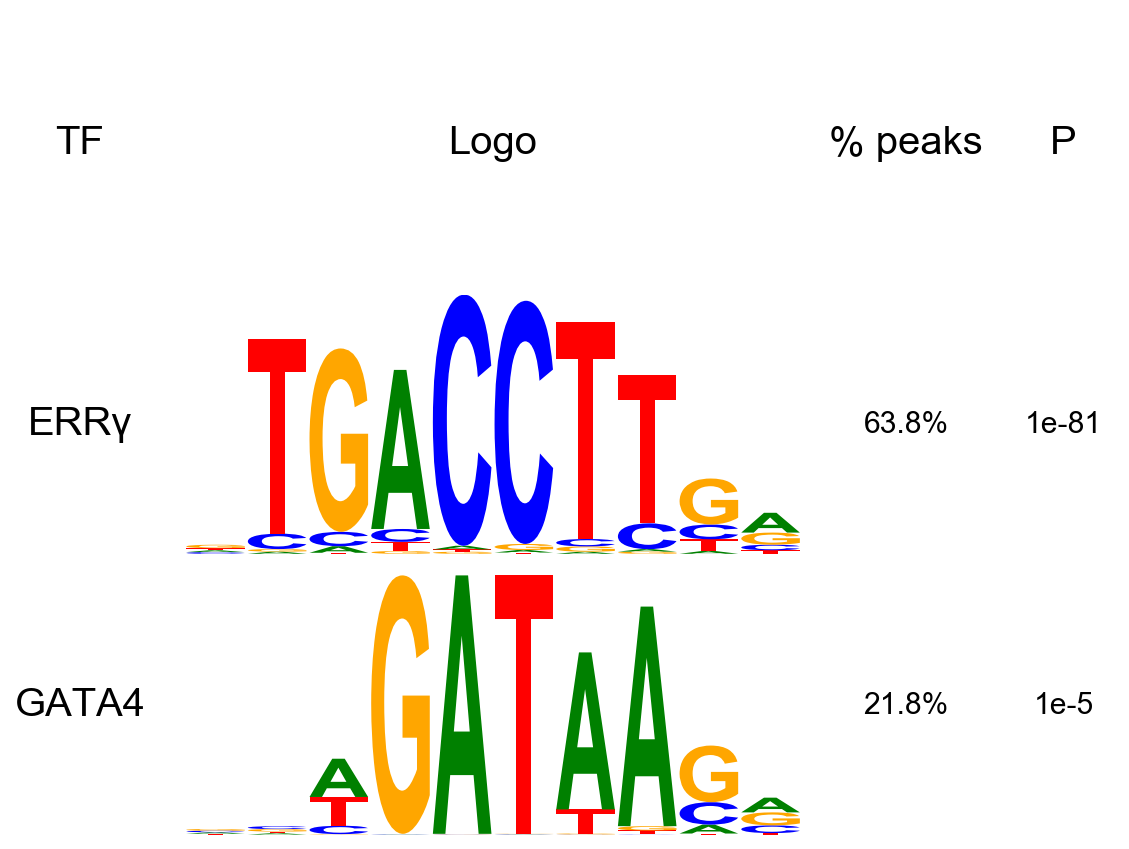

In [207]:
homer_logos_table.make_logos_table(os.path.join(outs_folder, "down_heart_errg_peaks.motifs", "knownResults"), "pics/down_heart_errg_peaks_known_motifs.png", 
                                   ["1+ERRγ", "15+GATA4"])

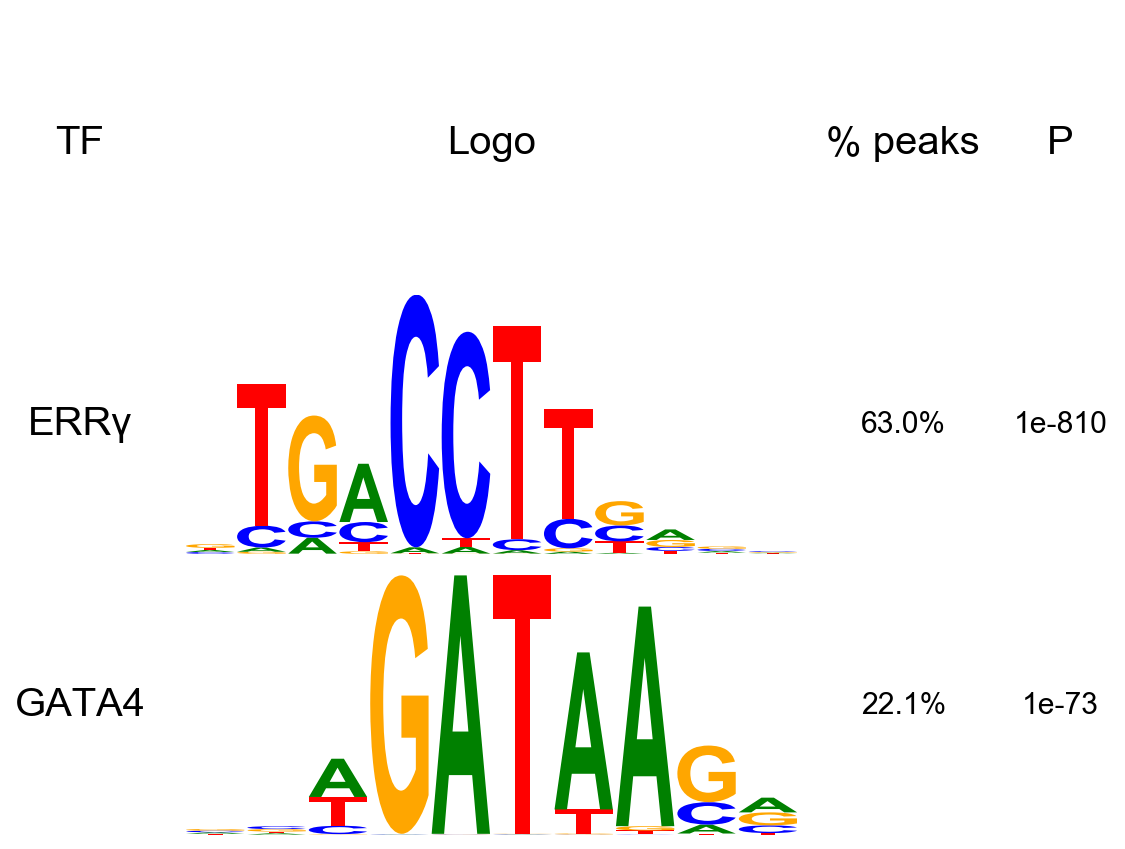

In [208]:
homer_logos_table.make_logos_table(os.path.join(outs_folder, "down_metabolic_errg_peaks.motifs", "knownResults"), "pics/down_metabolic_errg_peaks_known_motifs.png", 
                                   ["1+ERRγ", "13+GATA4"])

In [93]:
errg_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
h3k27ac_peaks_file = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks"
merged_peaks_file = os.path.join(outs_folder, "H3K27Ac_ERRg_merged.peaks")
homer_tools.merge_peaks(peak_files_to_merge=[errg_peaks_file, h3k27ac_peaks_file], output_peak_file=merged_peaks_file, max_distance="given",
                        runner=parallel_run.SimpleRunner())

In [110]:
h3k27ac_errg_intersection_data = pd.read_csv(merged_peaks_file, sep="\t")
h3k27ac_errg_intersection_data = h3k27ac_errg_intersection_data.loc[h3k27ac_errg_intersection_data["Parent files"].str.contains("H3K27Ac_WT_vs_Input_pooled.peaks"),:]
h3k27ac_errg_intersection_data["has_errg"] = False
h3k27ac_errg_intersection_data.loc[h3k27ac_errg_intersection_data["Parent files"].str.contains("ERRg_WT_vs_KO_pooled.peaks"), "has_errg"] = True
peaks_with_errg = set()
for ids in h3k27ac_errg_intersection_data.loc[h3k27ac_errg_intersection_data.has_errg, h3k27ac_peaks_file]:
    peaks_with_errg.update(ids.split(","))
    
peaks_without_errg = set()
for ids in h3k27ac_errg_intersection_data.loc[~h3k27ac_errg_intersection_data.has_errg, h3k27ac_peaks_file]:
    peaks_without_errg.update(ids.split(","))

In [122]:
h3k27ac_peaks_data = pd.read_csv(h3k27ac_peaks_file, sep="\t", skiprows=38)
h3k27ac_peaks_data = h3k27ac_peaks_data.set_index("#PeakID")
h3k27ac_peaks_with_errg_file = os.path.join(outs_folder, "H3K27Ac_with_ERRg.peaks")
h3k27ac_peaks_data.loc[peaks_with_errg, :].to_csv(h3k27ac_peaks_with_errg_file, sep="\t")
h3k27ac_peaks_without_errg_file = os.path.join(outs_folder, "H3K27Ac_without_ERRg.peaks")
h3k27ac_peaks_data.loc[peaks_without_errg, :].to_csv(h3k27ac_peaks_without_errg_file, sep="\t")

In [ ]:
h3k27ac_wt_dirs = [f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-WT-{i}.tags" for i in [1, 2]]
h3k27ac_ko_dirs = [f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-KO-{i}.tags" for i in [1, 2]]
wt_over_ko_peaks = os.path.join(outs_folder, "H3K27Ac_with_ERRg_WT_over_KO.peaks")
!getDifferentialPeaksReplicates.pl -p {h3k27ac_peaks_with_errg_file} -t {misc.join_quoted_paths(h3k27ac_wt_dirs)} -b {misc.join_quoted_paths(h3k27ac_ko_dirs)} -all > {wt_over_ko_peaks}

In [ ]:
ko_over_wt_wo_errg_peaks = os.path.join(outs_folder, "H3K27Ac_without_ERRg_WT_over_KO.peaks")
!getDifferentialPeaksReplicates.pl -p {h3k27ac_peaks_without_errg_file} -t {misc.join_quoted_paths(h3k27ac_wt_dirs)} -b {misc.join_quoted_paths(h3k27ac_ko_dirs)} -all > {ko_over_wt_wo_errg_peaks}

In [144]:
wt_over_ko_data = pd.read_csv(wt_over_ko_peaks, sep="\t")
n_with_errg = len(wt_over_ko_data)
wt_over_ko_data = wt_over_ko_data.loc[(wt_over_ko_data["bg vs. target adj. p-value"] < 0.05) & (wt_over_ko_data["bg vs. target Log2 Fold Change"].abs() >= 1), :]
num_down_with_errg = sum(wt_over_ko_data["bg vs. target Log2 Fold Change"] < 0)

In [145]:
wt_over_ko_wo_errg_data = pd.read_csv(ko_over_wt_wo_errg_peaks, sep="\t")
n_wo_errg = len(wt_over_ko_wo_errg_data)
wt_over_ko_wo_errg_data = wt_over_ko_wo_errg_data.loc[(wt_over_ko_wo_errg_data["bg vs. target adj. p-value"] < 0.05) & 
                                                      (wt_over_ko_wo_errg_data["bg vs. target Log2 Fold Change"].abs() >= 1), :]

num_down_wo_errg = sum(wt_over_ko_wo_errg_data["bg vs. target Log2 Fold Change"] < 0)
num_down_wo_errg / n_wo_errg

0.004231043498930354

In [180]:
plot_data = pd.DataFrame({"% of H3K27Ac peaks": [num_down_with_errg / n_with_errg, (len(wt_over_ko_data) - num_down_with_errg) / n_with_errg, 
                                       num_down_wo_errg / n_wo_errg, (len(wt_over_ko_wo_errg_data) - num_down_wo_errg) / n_wo_errg],
                          "H3K27Ac change with ERRa/g KO": ["up", "down", "up", "down"],
                          "ERRg peak": [f"yes ({n_with_errg} peaks)", f"yes ({n_with_errg} peaks)", f"no ({n_wo_errg} peaks)", f"no ({n_wo_errg} peaks)"]})

plot_data["% of H3K27Ac peaks"] *= 100
#plot_data = plot_data.set_index(["H3K27Ac change", "ERRg peak"])

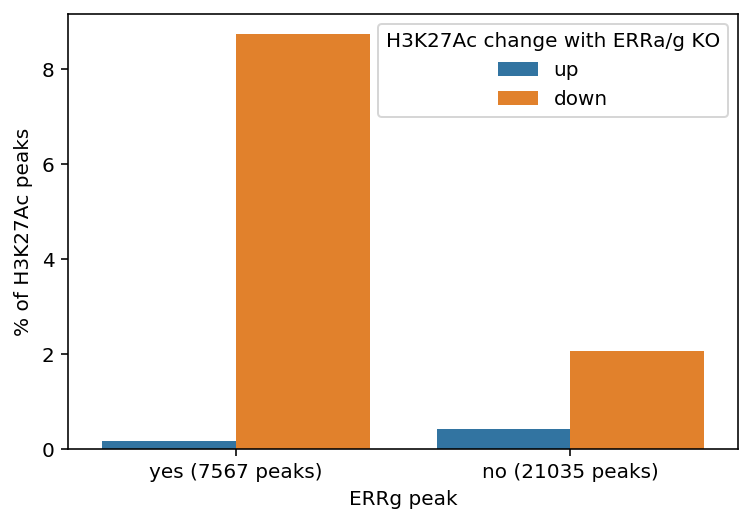

In [181]:
sns.barplot(y="% of H3K27Ac peaks", x="ERRg peak", hue="H3K27Ac change with ERRa/g KO", data=plot_data)
plt.savefig("pics/up_down_H3K27Ac_by_ERRg_intersection.png", dpi=300)

In [27]:
def go_analysis_in_selection(selection, name, wb, background=None):
    selected_peaks = counts_data[selection]
    selected_peaks_file = os.path.join(outs_folder, f"ERRg_peaks_with_{name}.peaks")
    selected_peaks.to_csv(selected_peaks_file, sep="\t", index=False)
    selected_peaks_lc_file = os.path.join(outs_folder, f"ERRg_peaks_with_{name}_lc.peaks")
    homer_tools.to_long_chromnames(selected_peaks_file, selected_peaks_lc_file)
    selected_peaks_annotated_file = os.path.join(outs_folder, f"ERRg_peaks_with_{name}_annotated.peaks")
    homer_tools.annotate_peaks(selected_peaks_lc_file, selected_peaks_annotated_file, homer_genome, parallel_run.SimpleRunner())
    annotated_data = pd.read_csv(selected_peaks_annotated_file, sep="\t")
    genes = set(annotated_data["Nearest PromoterID"].astype(str))
    gene_name_map = dict(zip(annotated_data["Nearest PromoterID"].astype(str), annotated_data["Gene Name"].astype(str)))
    enrichment_cutoff = 2
    alpha = 0.05
    pics_folder = os.path.join("pics", "GO", f"ERRg_peaks_with_{name}")
    res = gprofiler.plot_significant_results(genes, gprofiler.main_libraries, gprofiler.organisms["human"],
                                             enrichment_cutoff, alpha,
                                             pics_folder, None, suffix=name, return_genes=True, background=background)
    
    ws = wb.create_sheet(title=name[:26])
    gprofiler.write_res_from_libraries(ws, res, gprofiler.main_libraries, enrichment_cutoff=enrichment_cutoff, gene_name_map=gene_name_map)

In [31]:
wb = openpyxl.Workbook()
go_analysis_in_selection(counts_data.ac_down, "H3K27Ac_down", wb)
go_analysis_in_selection(counts_data.ac_up, "H3K27Ac_up", wb)
wb.save("tables/ERRg_peaks_by_H3K27Ac_direction_GO.xlsx")

Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_lc.peaks' hg38     > 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_annotated.peaks'
Enrichment analysis for 2007 genes in KEGG pathways...
Enrichment analysis for 2007 genes in Molecular function...
Enrichment analysis for 2007 genes in Cellular component...
Enrichment analysis for 2007 genes in Biological process...
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_up_lc.peaks' hg38     > 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_up_annotated.peaks'
Enrichment analysis for 2134 genes in KEGG pathways...
Enrichment analysis for 2134 genes in Molecular function...
Enrichment analysis for 2134 genes in Cellular component...
Enrichment analysis for 2134 genes in Biological process...


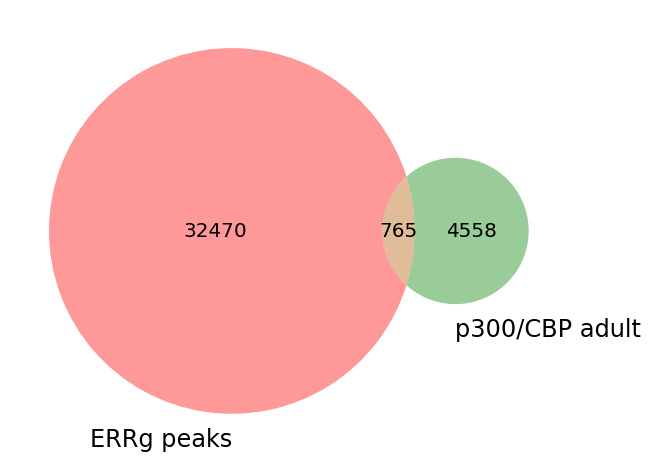

In [14]:
errg_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
p300_adult = "data/ChIP-Seq/p300/peaks/HumanAdultHeart_acCBP-p300.peaks"
homer_tools.compare_peaks(errg_peaks_file, p300_adult, "ERRg peaks", "p300/CBP adult")
plt.savefig("pics/ERRg_p300_adult_peaks_intersection.png", dpi=300)

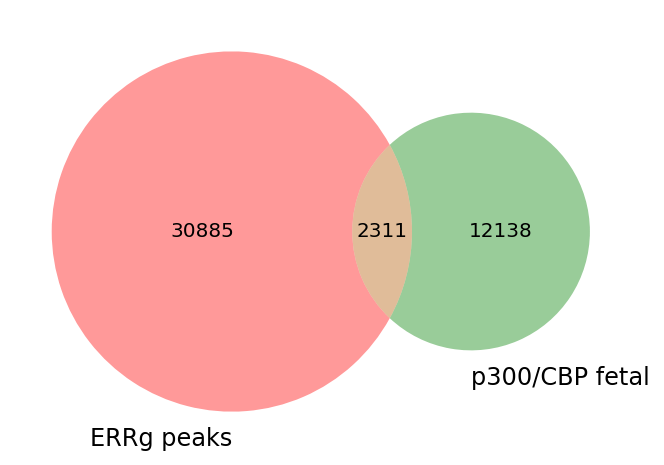

In [15]:
errg_peaks_file = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
p300_fetal = "data/ChIP-Seq/p300/peaks/HumanFetaltHeart_acCBP-p300.peaks"
homer_tools.compare_peaks(errg_peaks_file, p300_fetal, "ERRg peaks", "p300/CBP fetal")
plt.savefig("pics/ERRg_p300_fetal_peaks_intersection.png", dpi=300)

# Intersection of ATAC WT open regions with ERRg

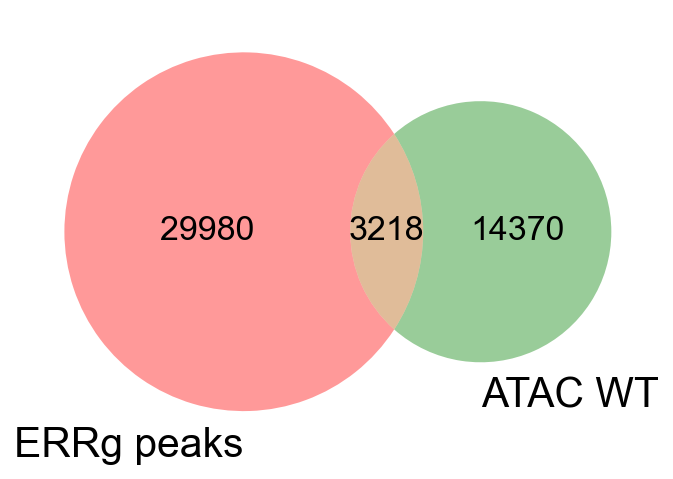

In [16]:
homer_tools.compare_peaks(errg_peaks_file, atac_wt_peaks_file, "ERRg peaks", "ATAC WT")
plt.savefig("pics/atac/ERRg_ATAC_WT_peaks_intersection.png", dpi=300)

In [56]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ATAC_WT_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")
seq_length = 2000
bin_size = 10
num_columns = seq_length // bin_size + 1
count_data = count_data.iloc[:, :-num_columns]
count_data = count_data.set_index(count_data.Gene)

peaks_with_errg = homer_tools.intersecting_peak_ids(atac_wt_peaks_file, errg_peaks_file, "_asdf", distance="given")
peaks_without_errg = list(set(count_data.Gene.values) - set(peaks_with_errg))

med1_count_file = os.path.join(outs_folder, "MED1_at_ATAC_WT_peaks.counts")
med1_count_data = pd.read_csv(med1_count_file, sep="\t")
med1_count_data = med1_count_data.set_index(med1_count_data.Gene)

Running command w/120 threads: cp 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks' '_asdf_0'
Running command w/120 threads: cp 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' '_asdf_1'
Running command w/120 threads: mergePeaks -d given _asdf_0 _asdf_1 > _asdf_2
Running command w/120 threads: rm '_asdf_0' '_asdf_1' '_asdf_2'


In [57]:
plot_df_h3k27ac_with_errg = counts_plot_df(count_data.loc[peaks_with_errg, :], ["+ ERRγ binding"])
plot_df_h3k27ac_without_errg = counts_plot_df(count_data.loc[peaks_without_errg, :], ["- ERRγ binding"])
plot_df_h3k27ac = pd.concat((plot_df_h3k27ac_with_errg, plot_df_h3k27ac_without_errg))
plot_df_h3k27ac["ab"] = "H3K27Ac"

plot_df_med1_with_errg = counts_plot_df(med1_count_data.reindex(peaks_with_errg), ["+ ERRγ binding"])
plot_df_med1_without_errg = counts_plot_df(med1_count_data.reindex(peaks_without_errg), ["- ERRγ binding"])
plot_df_med1 = pd.concat((plot_df_med1_with_errg, plot_df_med1_without_errg))
plot_df_med1["ab"] = "MED1"

plot_df = pd.concat((plot_df_h3k27ac, plot_df_med1))

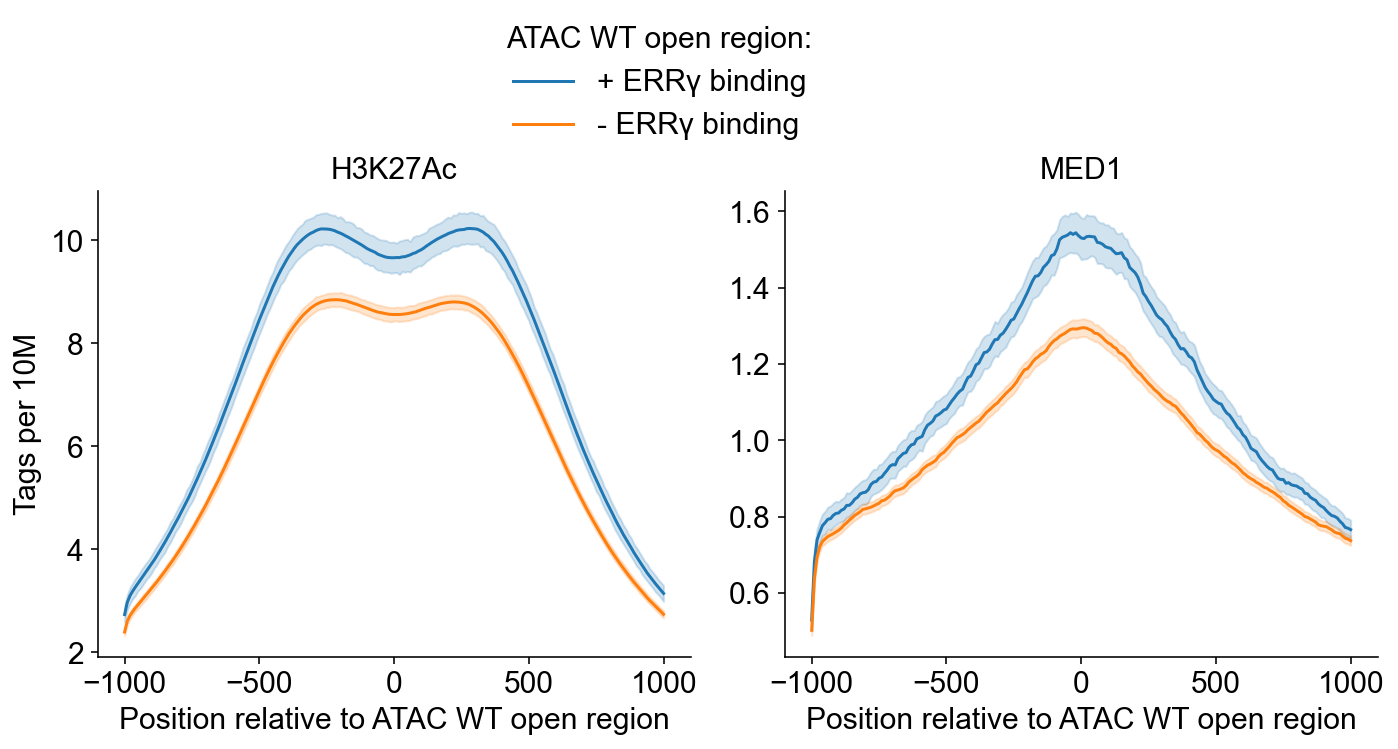

In [58]:
g = sns.FacetGrid(plot_df, hue="dataset", col="ab", sharey=False, height=5)
g.map(sns.lineplot, "variable", "value")
g.add_legend(bbox_to_anchor=(0.5, 0.95), title="ATAC WT open region:")
g.set_xlabels("Position relative to ATAC WT open region")
g.set_ylabels("Tags per 10M")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.8)
#plt.savefig(f"pics/H3K27Ac_MED1_at_ATAC_WT_regions.png", dpi=300, bbox_inches='tight')  
plt.savefig(f"pics/H3K27Ac_MED1_at_ATAC_WT_regions.pdf", bbox_inches='tight')

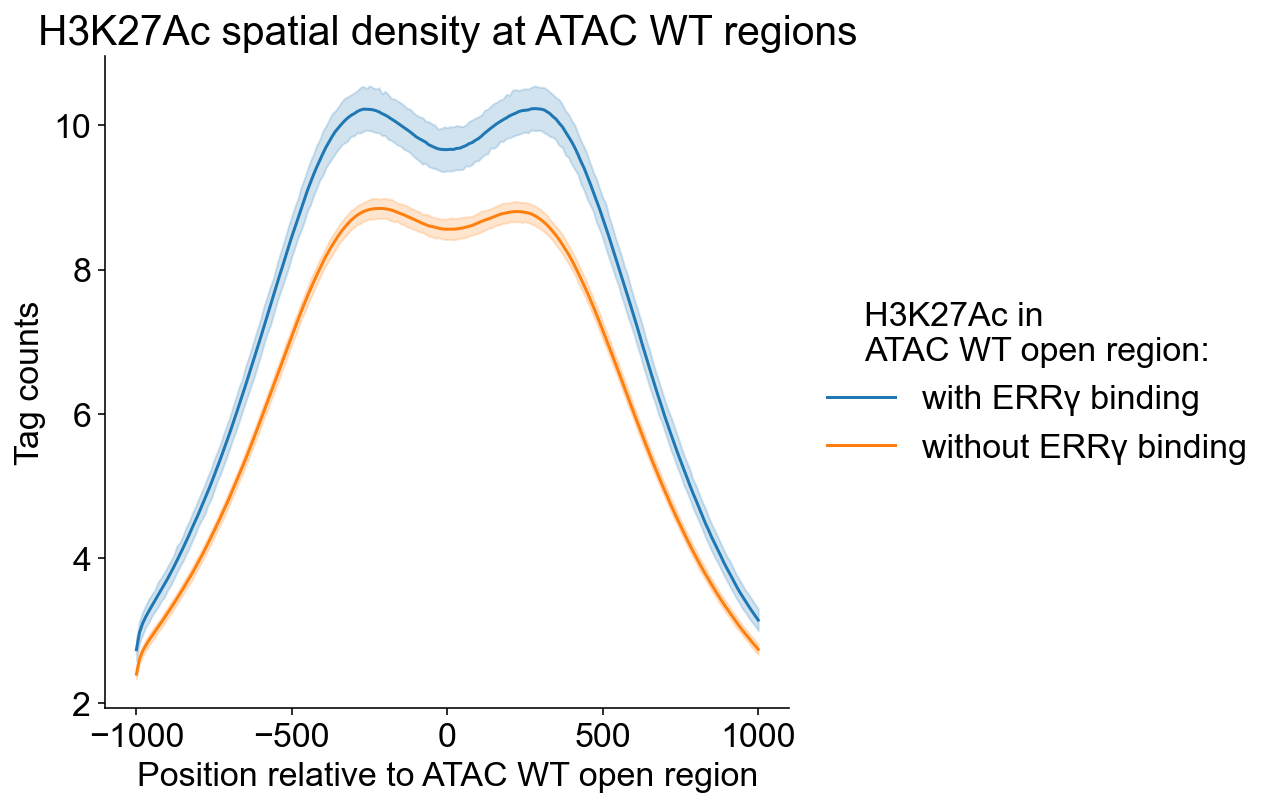

In [18]:
fig = plt.figure(figsize=[10, 6], facecolor="white")
plot_counts(count_data.loc[peaks_with_errg, :], ["with ERRγ binding"])
plot_counts(count_data.loc[peaks_without_errg, :], ["without ERRγ binding"])
plt.xlabel("Position relative to ATAC WT open region")
plt.title("H3K27Ac spatial density at ATAC WT regions")
plt.legend(bbox_to_anchor=(1.01, 0.5), title="H3K27Ac in\nATAC WT open region:")
plt.subplots_adjust(wspace=0.7, right=0.6)
plt.savefig("pics/H3K27Ac_at_ATAC_WT_regions.png", dpi=300)

In [77]:
h3k27ac_wt_peaks_file = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks"
h3k27ac_wt_dirs = [f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-WT-{i}.tags" for i in [1, 2]]
h3k27ac_ko_dirs = [f"data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-KO-{i}.tags" for i in [1, 2]]
wt_over_ko_peaks = os.path.join(outs_folder, "H3K27Ac_WT_over_KO.peaks")
!getDifferentialPeaksReplicates.pl -p {"'" + h3k27ac_wt_peaks_file + "'"} -t {misc.join_quoted_paths(h3k27ac_wt_dirs)} -b {misc.join_quoted_paths(h3k27ac_ko_dirs)} > {wt_over_ko_peaks}

	Step1: Defining Putative Peak Set

	Step2: Quantifying reads across target/background/input tag directories


	No genome selected ("none") - limits what you can do
	Peak file = data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks
	Genome = none
	Organism = unknown
	Tag Directories:
		data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-KO-1.tags
		data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-KO-2.tags
		data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-WT-1.tags
		data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags/pooled_tags/H3K27Ac-WT-2.tags
	Will NOT normalize tag counts
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 28602
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 28602
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns pe

In [76]:
h3k27ac_ko_peaks_file = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_KO_vs_Input_pooled.peaks"
h3k27ac_ko_over_wt_peaks = os.path.join(outs_folder, "H3K27Ac_KO_over_WT.peaks")
!getDifferentialPeaksReplicates.pl -p {"'" + h3k27ac_ko_peaks_file + "'"} -b {misc.join_quoted_paths(h3k27ac_wt_dirs)} -t {misc.join_quoted_paths(h3k27ac_ko_dirs)} > {h3k27ac_ko_over_wt_peaks}

/bin/sh: 1: Syntax error: "(" unexpected


In [ ]:
h3k27ac_ko_over_wt_annotated_peaks = h3k27ac_ko_over_wt_peaks.replace(".peaks", "_annotated.peaks")
h3k27ac_wt_over_ko_annotated_peaks = wt_over_ko_peaks.replace(".peaks", "_annotated.peaks")
h3k27ac_ko_over_wt_lc_peaks = h3k27ac_ko_over_wt_peaks.replace(".peaks", "_lc.peaks")
h3k27ac_wt_over_ko_lc_peaks = wt_over_ko_peaks.replace(".peaks", "_lc.peaks")
homer_tools.to_long_chromnames(h3k27ac_ko_over_wt_peaks, h3k27ac_ko_over_wt_lc_peaks)
homer_tools.to_long_chromnames(wt_over_ko_peaks, h3k27ac_wt_over_ko_lc_peaks)
!annotatePeaks.pl {"'" + h3k27ac_ko_over_wt_lc_peaks + "'"} {homer_genome} > {"'" + h3k27ac_ko_over_wt_annotated_peaks + "'"}
!annotatePeaks.pl {"'" + h3k27ac_wt_over_ko_lc_peaks + "'"} {homer_genome} > {"'" + h3k27ac_wt_over_ko_annotated_peaks + "'"}

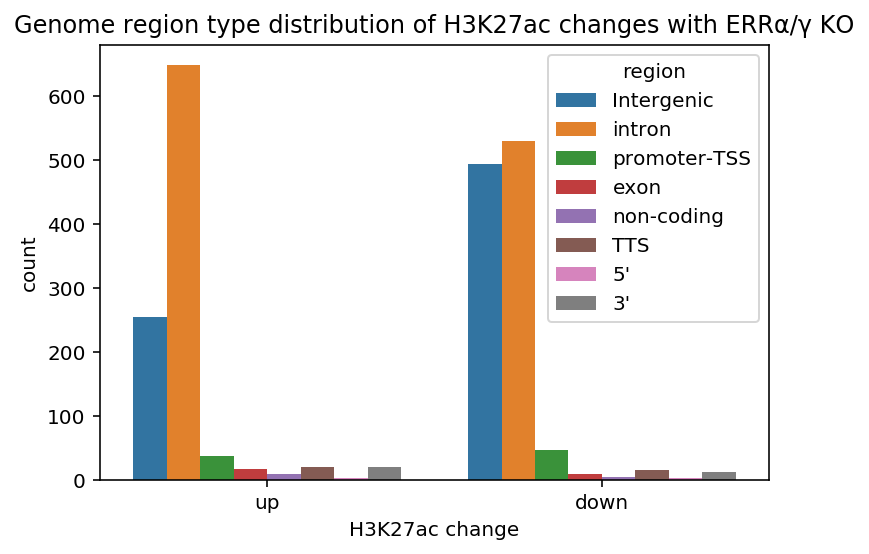

In [75]:
wt_over_ko_peaks = os.path.join(outs_folder, "H3K27Ac_WT_over_KO.peaks")
h3k27ac_ko_over_wt_peaks = os.path.join(outs_folder, "H3K27Ac_KO_over_WT.peaks")
h3k27ac_ko_over_wt_annotated_peaks = h3k27ac_ko_over_wt_peaks.replace(".peaks", "_annotated.peaks")
h3k27ac_wt_over_ko_annotated_peaks = wt_over_ko_peaks.replace(".peaks", "_annotated.peaks")
dir_peaks = [("up", h3k27ac_ko_over_wt_annotated_peaks), ("down", h3k27ac_wt_over_ko_annotated_peaks)]
homer_tools.plot_area_kind_distribution(dir_peaks, "H3K27ac change")
plt.title("Genome region type distribution of H3K27ac changes with ERRα/γ KO")
plt.savefig("pics/H3K27ac_changes_regions.png", dpi=300)

In [73]:
results = []
for d, peaks in dir_peaks:
    peaks_data = pd.read_csv(peaks, sep="\t")
    genes = set(g for g in peaks_data["Nearest PromoterID"] if not pd.isnull(g))
    results.append(gprofiler.plot_significant_results(genes, pathway_analysis.libraries, gprofiler.organisms["human"],
                                             2.0, 0.05,
                                             f"pics/GO/H3K27ac_{d}", None, suffix=f"H3K27ac~{d}", return_genes=True))

Enrichment analysis for 875 genes in KEGG pathways...
No data for pics/GO/H3K27ac_up/KEGG H3K27ac~up.png
Enrichment analysis for 875 genes in Molecular function...
Enrichment analysis for 875 genes in Cellular component...
Enrichment analysis for 875 genes in Biological process...
Enrichment analysis for 987 genes in KEGG pathways...
No data for pics/GO/H3K27ac_down/KEGG H3K27ac~down.png
Enrichment analysis for 987 genes in Molecular function...
Enrichment analysis for 987 genes in Cellular component...
Enrichment analysis for 987 genes in Biological process...


In [77]:
genes = set()
for d, peaks in dir_peaks:
    peaks_data = pd.read_csv(peaks, sep="\t")
    genes.update([g for g in peaks_data["Nearest PromoterID"] if not pd.isnull(g)])
    
refseq_gene_id_map = gprofiler.query_convert(genes, "ENTREZGENE", gprofiler.organisms["human"])
refseq_gene_id_map2 = {}
for row in refseq_gene_id_map.itertuples():
    if row.converted != "None":
        refseq_gene_id_map2[row.incoming] = row.converted

In [81]:
wb = openpyxl.Workbook()
for (d, peaks), res in zip(dir_peaks, results):
    ws = wb.create_sheet(title=f"H3K27ac~{d}|GO")
    gprofiler.write_res_from_libraries(ws, res, pathway_analysis.libraries, enrichment_cutoff=2.0,
                                       gene_name_map=refseq_gene_id_map2)
    
del wb["Sheet"]
wb.save("tables/H3K27ac_changes_GO_enrichment.xlsx")

In [84]:
for d, peaks in dir_peaks:
    runner = parallel_run.LocalRunner(f"logs/homer_motifs_H3K27ac~{d}.log")
    motifs_folder = os.path.join(outs_folder, "motifs", f"H3K27ac~{d}")
    homer_tools.find_motifs(peaks, homer_genome, 200, motifs_folder, runner, number_of_motifs=15, lengths=[10, 12, 14, 16, 18],
                            redundant=0.8)
    
    runner.run(wait=False)

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/outs/H3K27Ac_KO_over_WT_annotated.peaks hg38 data/ChIP-Seq/outs/motifs/H3K27ac~up -size 200  -S 15 -len 10,12,14,16,18 -p 15  -redundant 0.8 && echo Finished successfully ; } >> 'logs/homer_motifs_H3K27ac~up.log' 2>&1
Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/outs/H3K27Ac_WT_over_KO_annotated.peaks hg38 data/ChIP-Seq/outs/motifs/H3K27ac~down -size 200  -S 15 -len 10,12,14,16,18 -p 15  -redundant 0.8 && echo Finished successfully ; } >> 'logs/homer_motifs_H3K27ac~down.log' 2>&1


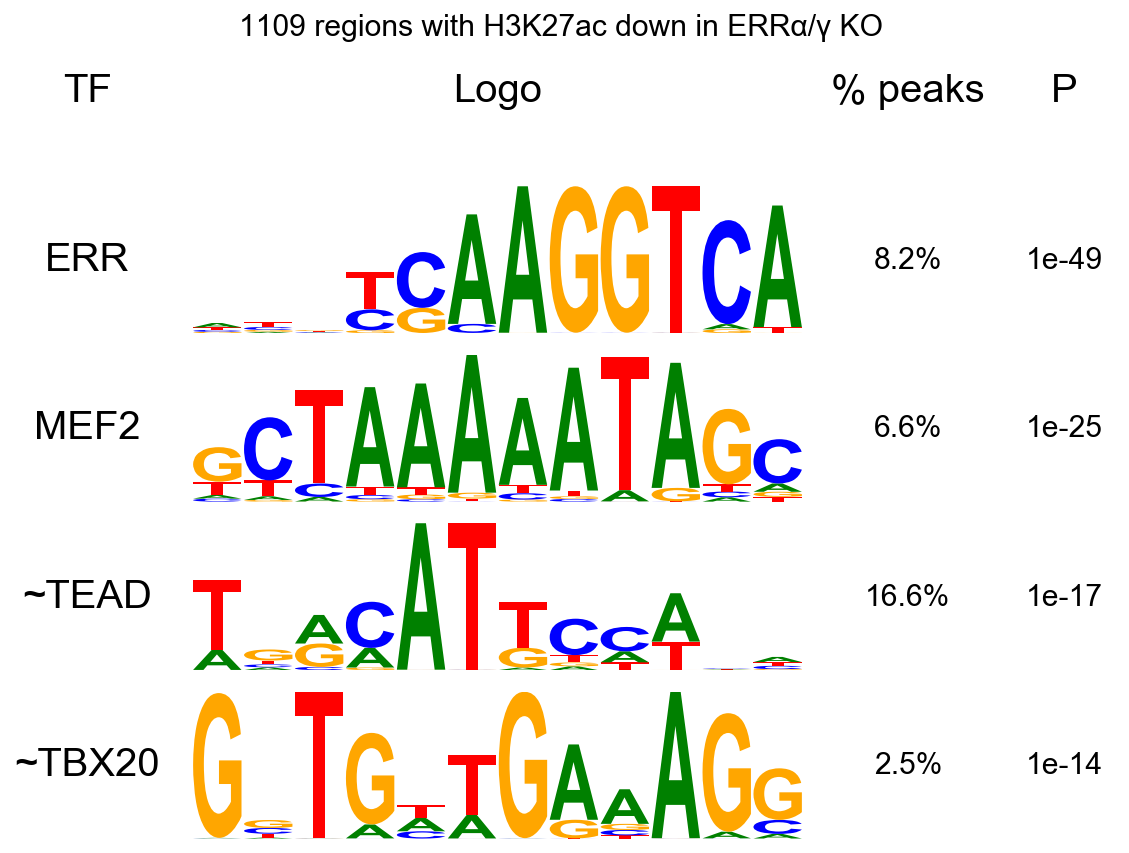

In [90]:
homer_logos_table.make_logos_table(os.path.join(outs_folder, "motifs", f"H3K27ac~down", "homerResults"), 
                                   "pics/H3K27ac~down_denovo_motifs.png",
                                   ["1-ERR", "3+MEF2", "8+~TEAD", "13+~TBX20"],
                                   title=f"1109 regions with H3K27ac down in ERRα/γ KO")

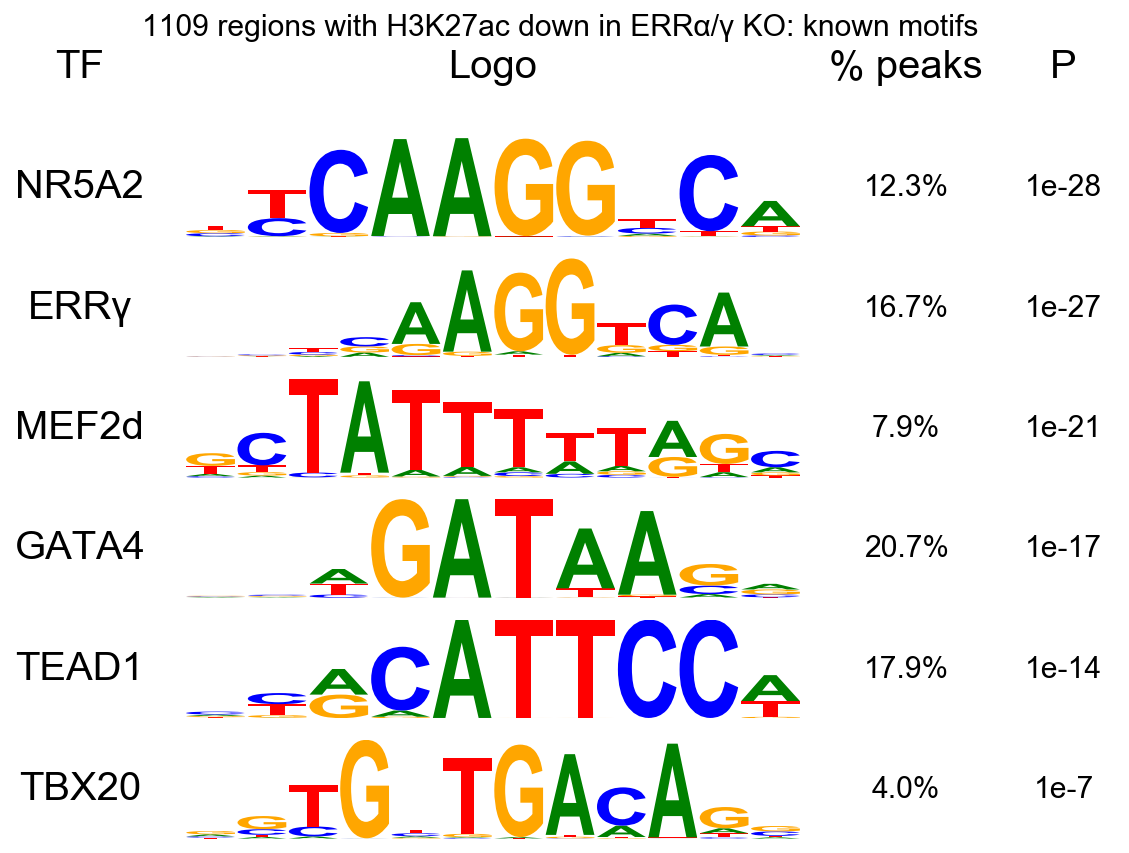

In [91]:
homer_logos_table.make_logos_table(os.path.join(outs_folder, "motifs", f"H3K27ac~down", "knownResults"), 
                                   "pics/H3K27ac~down_known_motifs.png",
                                   ["1+NR5A2", "4-ERRγ", "6+MEF2d", "10+GATA4", "14+TEAD1", "25+TBX20"],
                                   title=f"1109 regions with H3K27ac down in ERRα/γ KO: known motifs")

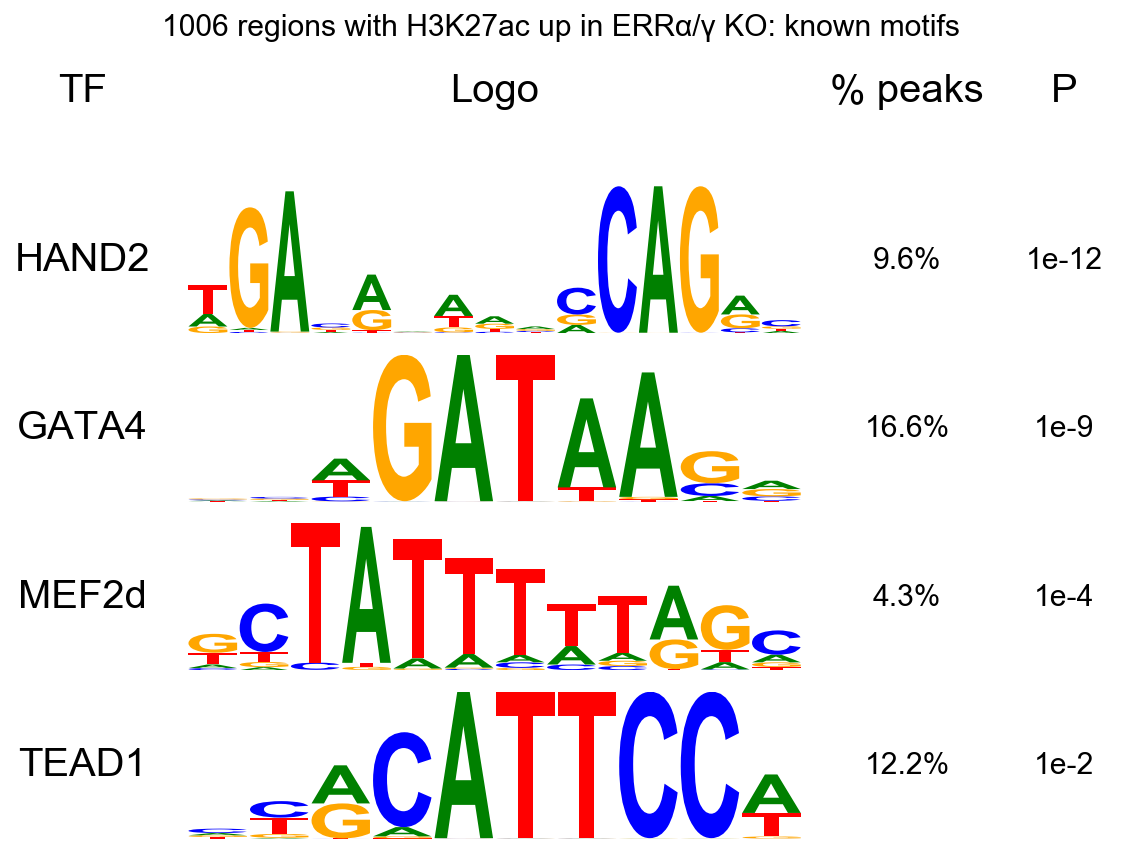

In [93]:
homer_logos_table.make_logos_table(os.path.join(outs_folder, "motifs", f"H3K27ac~up", "knownResults"), 
                                   "pics/H3K27ac~up_known_motifs.png",
                                   ["1+HAND2", "3+GATA4", "13+MEF2d", "24+TEAD1"],
                                   title=f"1006 regions with H3K27ac up in ERRα/γ KO: known motifs")

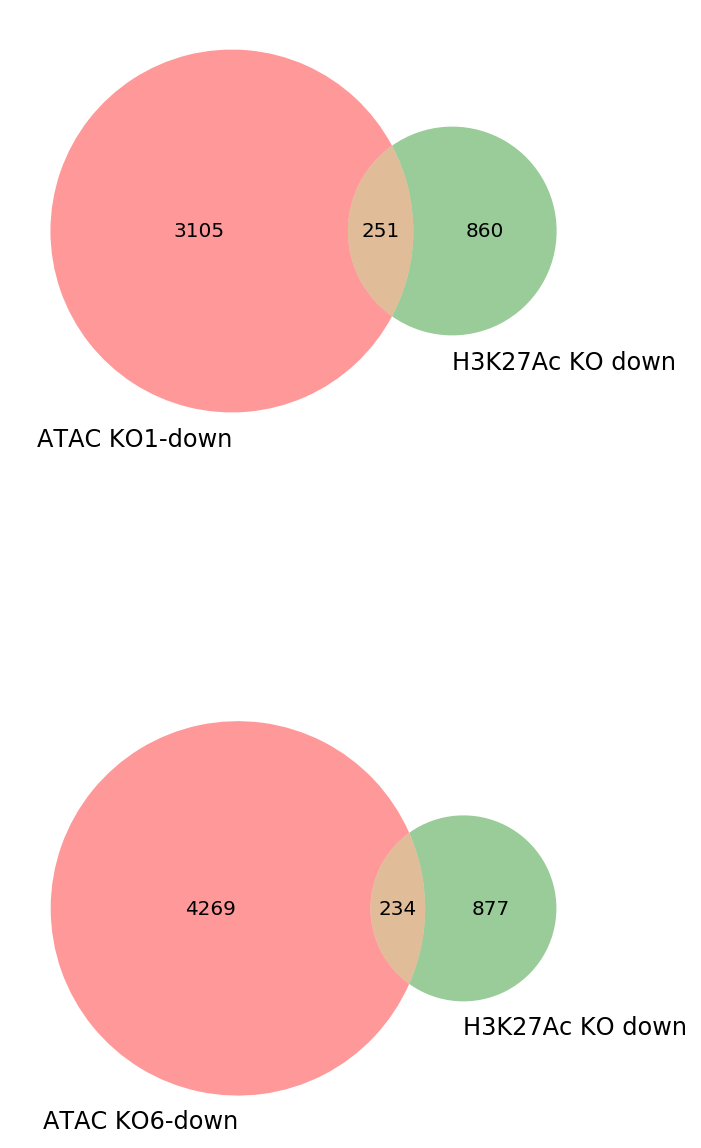

In [26]:
atac_down_regions_ko1 = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO1.peaks"
atac_down_regions_ko6 = "data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/down_in_KO6.peaks"
h3k27ac_down_regions = wt_over_ko_peaks
plt.figure(figsize=(5, 10))
plt.subplot(211)
homer_tools.compare_peaks(atac_down_regions_ko1, h3k27ac_down_regions, "ATAC KO1-down", "H3K27Ac KO down")
plt.subplot(212)
homer_tools.compare_peaks(atac_down_regions_ko6, h3k27ac_down_regions, "ATAC KO6-down", "H3K27Ac KO down")
plt.tight_layout()
plt.savefig("pics/atac/ATAC_down_vs_H3K27Ac_down_intersection.png", dpi=300)

In [ ]:
atac1_h3k27ac_down_intersection_peaks = os.path.join(outs_folder, "ATAC_KO1_vs_H3K27Ac_down_intersection.peaks")
homer_tools.intersect_peaks(atac_down_regions_ko1, h3k27ac_down_regions, atac1_h3k27ac_down_intersection_peaks)
atac1_h3k27ac_down_intersection_peaks_1000 = os.path.join(outs_folder, "ATAC_KO1_vs_H3K27Ac_down_intersection_1000.peaks")
!annotatePeaks.pl {atac1_h3k27ac_down_intersection_peaks} none -size 1000 > {atac1_h3k27ac_down_intersection_peaks_1000}
atac6_h3k27ac_down_intersection_peaks = os.path.join(outs_folder, "ATAC_KO6_vs_H3K27Ac_down_intersection.peaks")
homer_tools.intersect_peaks(atac_down_regions_ko6, h3k27ac_down_regions, atac6_h3k27ac_down_intersection_peaks)
atac6_h3k27ac_down_intersection_peaks_1000 = os.path.join(outs_folder, "ATAC_KO6_vs_H3K27Ac_down_intersection_1000.peaks")
!annotatePeaks.pl {atac6_h3k27ac_down_intersection_peaks} none -size 1000 > {atac6_h3k27ac_down_intersection_peaks_1000}

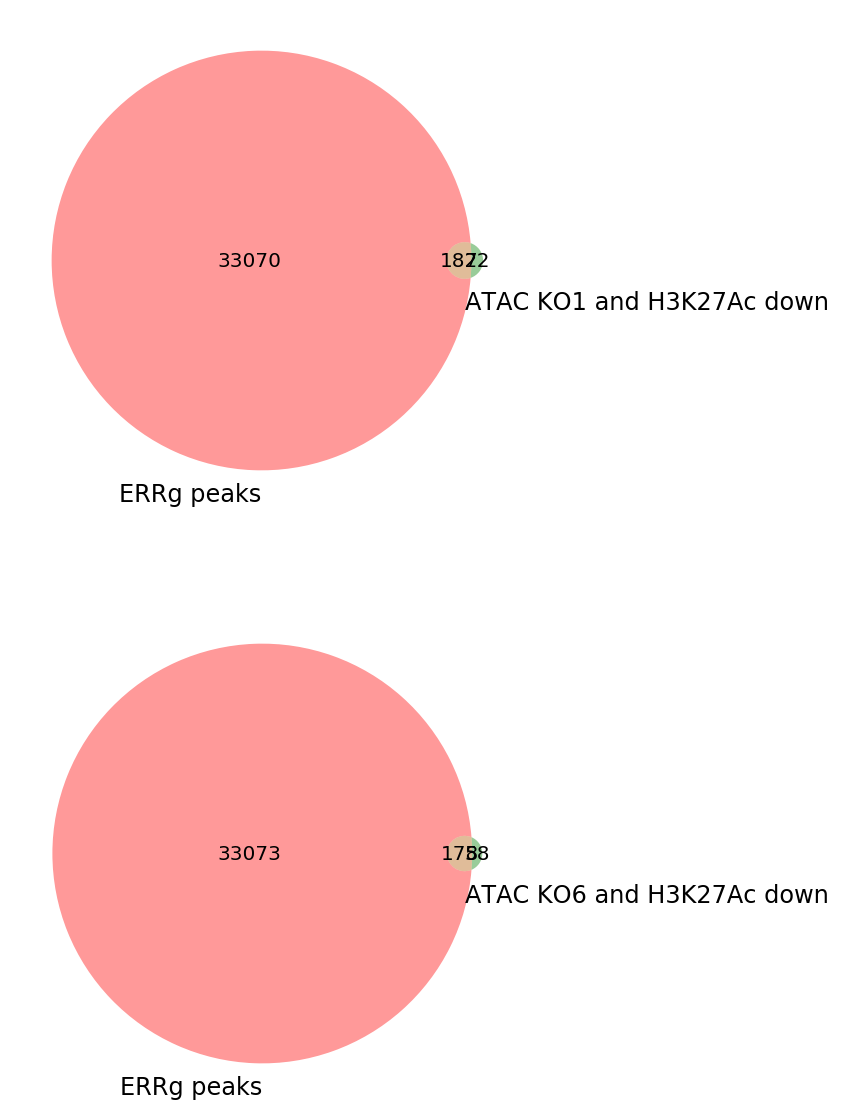

In [38]:
plt.figure(figsize=(5, 10))
plt.subplot(211)
_, (_, down1_no_errg, down1_with_errg) = \
    homer_tools.compare_peaks(errg_peaks_file, atac1_h3k27ac_down_intersection_peaks_1000, "ERRg peaks", "ATAC KO1 and H3K27Ac down")
plt.subplot(212)
_, (_, down6_no_errg, down6_with_errg) = \
    homer_tools.compare_peaks(errg_peaks_file, atac6_h3k27ac_down_intersection_peaks_1000, "ERRg peaks", "ATAC KO6 and H3K27Ac down")

In [42]:
print(f"{down1_with_errg} ({down1_with_errg / (down1_with_errg + down1_no_errg) * 100:.1f}%) of regions with both ATAC-KO1 and H3K27Ac down have ERRg")
print(f"{down6_with_errg} ({down6_with_errg / (down6_with_errg + down6_no_errg) * 100:.1f}%) of regions with both ATAC-KO6 and H3K27Ac down have ERRg")

182 (71.7%) of regions with both ATAC-KO1 and H3K27Ac down have ERRg
178 (75.4%) of regions with both ATAC-KO6 and H3K27Ac down have ERRg


In [45]:
errg_atac1_h3k27ac_down_intersection_peaks = os.path.join(outs_folder, "ERRg_ATAC_KO1_vs_H3K27Ac_down_intersection.peaks")
homer_tools.intersect_peaks(atac1_h3k27ac_down_intersection_peaks_1000, errg_peaks_file, errg_atac1_h3k27ac_down_intersection_peaks)
errg_atac1_h3k27ac_down_intersection_peaks_lc = os.path.join(outs_folder, "ERRg_ATAC_KO1_vs_H3K27Ac_down_intersection_lchrom.peaks")
homer_tools.to_long_chromnames(errg_atac1_h3k27ac_down_intersection_peaks, errg_atac1_h3k27ac_down_intersection_peaks_lc)
errg_atac1_h3k27ac_down_intersection_motifs = os.path.join(outs_folder, "ERRg_ATAC_KO1_vs_H3K27Ac_down_intersection.motifs")
homer_tools.find_motifs(errg_atac1_h3k27ac_down_intersection_peaks_lc, homer_genome, 200, errg_atac1_h3k27ac_down_intersection_motifs, parallel_run.SimpleRunner(), 
                        de_novo=False)

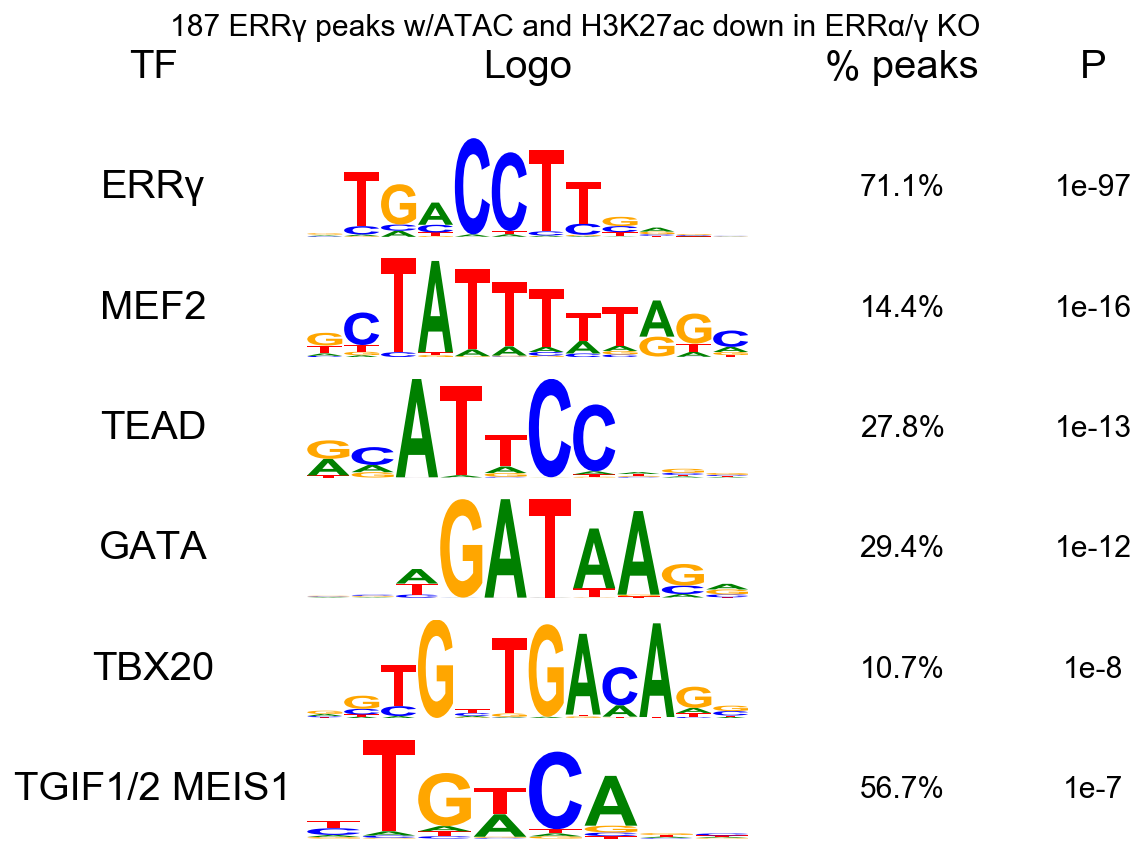

In [50]:
homer_logos_table.make_logos_table(os.path.join(errg_atac1_h3k27ac_down_intersection_motifs, "knownResults"), 
                                   "pics/ERRg_ATAC_KO1_vs_H3K27Ac_down_intersection_known_motifs.png",
                                   ["1+ERRγ", "12+MEF2", "13-TEAD", "15+GATA", "27+TBX20", "28+TGIF1/2 MEIS1"],
                                   title=f"187 ERRγ peaks w/ATAC and H3K27ac down in ERRα/γ KO")

In [95]:
oe_de_data = pd.read_excel("tables/ERRg_OE_DE.xlsx", sheet_name="FPKM")
ko_de_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name="FPKM")

array([[1.        , 0.07288593],
       [0.07288593, 1.        ]])

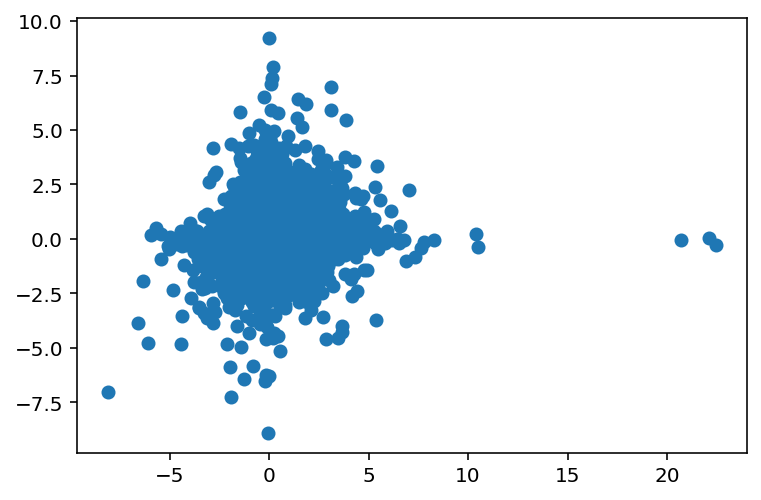

In [105]:
de_data_merged = pd.merge(oe_de_data, ko_de_data, on="gene_id")
plt.scatter(de_data_merged['ERR vs. GFP log2FoldChange'], de_data_merged['KO1 vs. WT log2FoldChange'])
np.corrcoef(de_data_merged['ERR vs. GFP log2FoldChange'], de_data_merged['KO1 vs. WT log2FoldChange'])

In [134]:
def go_analysis_for_genes(genes, tag, gene_name_map, wb):
    enrichment_cutoff = 2
    alpha = 0.05
    pics_folder = os.path.join("pics", "GO", tag)
    res = gprofiler.plot_significant_results(genes, gprofiler.main_libraries, gprofiler.organisms["human"],
                                             enrichment_cutoff, alpha,
                                             pics_folder, None, suffix=tag, return_genes=True)
    
    ws = wb.create_sheet(title=tag[:26] + " GO")
    gprofiler.write_res_from_libraries(ws, res, gprofiler.main_libraries, enrichment_cutoff=enrichment_cutoff, gene_name_map=gene_name_map)

Enrichment analysis for 396 genes in KEGG pathways...
Enrichment analysis for 396 genes in Molecular function...
Enrichment analysis for 396 genes in Cellular component...
Enrichment analysis for 396 genes in Biological process...
Enrichment analysis for 305 genes in KEGG pathways...
Enrichment analysis for 305 genes in Molecular function...
Enrichment analysis for 305 genes in Cellular component...
Enrichment analysis for 305 genes in Biological process...
Enrichment analysis for 489 genes in KEGG pathways...
Enrichment analysis for 489 genes in Molecular function...
Enrichment analysis for 489 genes in Cellular component...
Enrichment analysis for 489 genes in Biological process...
Enrichment analysis for 252 genes in KEGG pathways...
Enrichment analysis for 252 genes in Molecular function...
Enrichment analysis for 252 genes in Cellular component...
Enrichment analysis for 252 genes in Biological process...


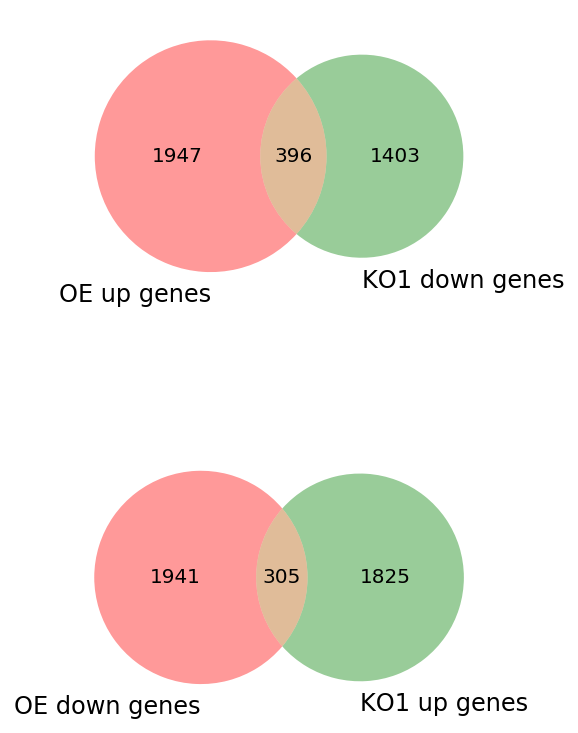

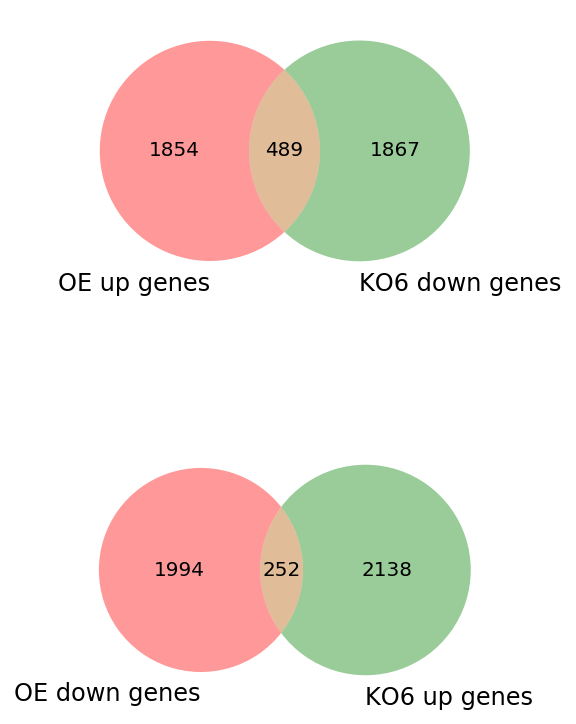

In [135]:
alpha = 0.05
min_abs_logfc = math.log2(1.5)

name_map = dict(zip(de_data_merged.gene_id, de_data_merged.gene_name_x))

def updown(dataset):   
    up_idx = (de_data_merged[f'{dataset} padj'] < alpha) & (de_data_merged[f'{dataset} log2FoldChange'] > min_abs_logfc)
    down_idx = (de_data_merged[f'{dataset} padj'] < alpha) & (de_data_merged[f'{dataset} log2FoldChange'] < -min_abs_logfc)
    return up_idx, down_idx

wb = openpyxl.Workbook()
for ko in ["KO1", "KO6"]:
    oe_up_idx, oe_down_idx = updown('ERR vs. GFP')
    ko_up_idx, ko_down_idx = updown(f'{ko} vs. WT')
    plt.figure(figsize=[4, 6])
    plt.subplot(211)
    up_oe = set(de_data_merged.gene_id[oe_up_idx])
    down_ko = set(de_data_merged.gene_id[ko_down_idx])
    venn2([up_oe, down_ko], set_labels=["OE up genes", f"{ko} down genes"])
    up_oe_down_ko = up_oe & down_ko
    ws = wb.create_sheet(f"OE🠕{ko}🠗 genes")
    misc.write_dataframe_to_worksheet(ws, pd.DataFrame({"gene_id": list(up_oe_down_ko), "gene_name": [name_map[g] for g in up_oe_down_ko]}))
    go_analysis_for_genes(up_oe_down_ko, f"OE🠕{ko}🠗", name_map, wb)
    plt.subplot(212)
    down_oe = set(de_data_merged.gene_id[oe_down_idx])
    up_ko = set(de_data_merged.gene_id[ko_up_idx])
    venn2([down_oe, up_ko], set_labels=["OE down genes", f"{ko} up genes"])
    down_oe_up_ko = down_oe & up_ko
    ws = wb.create_sheet(f"OE🠗{ko}🠕 genes")
    misc.write_dataframe_to_worksheet(ws, pd.DataFrame({"gene_id": list(down_oe_up_ko), "gene_name": [name_map[g] for g in down_oe_up_ko]}))
    go_analysis_for_genes(down_oe_up_ko, f"OE🠗{ko}🠕", name_map, wb)
    plt.tight_layout()
    plt.savefig(f"pics/OE_{ko}_genes_intersection.png", dpi=300)
    
del wb["Sheet"]
wb.save("tables/OE_KO_intresection_GO.xlsx")

In [160]:
def num_genes_with_peaks(gene_ids):
    return len(set(peaks_data.loc[ensembl_gene_to_peak_id(peaks_data, list(gene_ids), max_distance_to_tss=max_distance_to_tss), "Nearest Ensembl"]))

tags = []
num_genes = []
num_w_peaks = []
oe_up_idx, oe_down_idx = updown('ERR vs. GFP')
up_oe = set(de_data_merged.gene_id[oe_up_idx])
down_oe = set(de_data_merged.gene_id[oe_down_idx])
up_oe_genes_w_peaks = num_genes_with_peaks(up_oe)
down_oe_genes_w_peaks = num_genes_with_peaks(down_oe)

tags.append("OE up")
num_genes.append(len(up_oe))
num_w_peaks.append(up_oe_genes_w_peaks)
tags.append("OE down")
num_genes.append(len(down_oe))
num_w_peaks.append(down_oe_genes_w_peaks)        

for ko in ["KO1", "KO6"]:
    ko_up_idx, ko_down_idx = updown(f'{ko} vs. WT')
    down_ko = set(de_data_merged.gene_id[ko_down_idx])
    up_oe_down_ko = up_oe & down_ko
    up_ko = set(de_data_merged.gene_id[ko_up_idx])
    down_oe_up_ko = down_oe & up_ko
            
    up_ko_genes_w_peaks = num_genes_with_peaks(up_ko)
    tags.append(ko + " up")
    num_genes.append(len(up_ko))
    num_w_peaks.append(up_ko_genes_w_peaks)    

    down_ko_genes_w_peaks = num_genes_with_peaks(down_ko)
    tags.append(ko + " down")
    num_genes.append(len(down_ko))
    num_w_peaks.append(down_ko_genes_w_peaks)
    
    up_oe_down_ko_genes_w_peaks = num_genes_with_peaks(up_oe_down_ko)
    tags.append("OE up and " + ko + " down")
    num_genes.append(len(up_oe_down_ko))
    num_w_peaks.append(up_oe_down_ko_genes_w_peaks)
    
    down_oe_up_ko_genes_w_peaks = num_genes_with_peaks(down_oe_up_ko)
    tags.append("OE down and " + ko + " up")
    num_genes.append(len(down_oe_up_ko))
    num_w_peaks.append(down_oe_up_ko_genes_w_peaks)
    

genes_with_peaks_data = pd.DataFrame({"Gene set": tags, "# genes": num_genes, "# genes with ERRg peaks": num_w_peaks})

In [163]:
genes_with_peaks_data["% genes with ERRg peaks"] = genes_with_peaks_data["# genes with ERRg peaks"] / genes_with_peaks_data["# genes"] * 100
ws = wb.create_sheet(f"Genes|ERRg peaks@<{max_distance_to_tss}bp")
misc.write_dataframe_to_worksheet(ws, genes_with_peaks_data)
wb.save("tables/OE_KO_intresection_GO.xlsx")

In [169]:
for ko in ["KO1", "KO6"]:
    ko_up_idx, ko_down_idx = updown(f'{ko} vs. WT')
    down_ko = set(de_data_merged.gene_id[ko_down_idx])
    up_oe_down_ko = up_oe & down_ko
    up_ko = set(de_data_merged.gene_id[ko_up_idx])
    down_oe_up_ko = down_oe & up_ko
    
    peaks_up_oe_down_ko = peaks_data.loc[ensembl_gene_to_peak_id(peaks_data, list(up_oe_down_ko), max_distance_to_tss=max_distance_to_tss), :]
    peaks_up_oe_down_ko_file = f"data/ChIP-Seq/outs/OE_up_{ko}_down.peaks"
    peaks_up_oe_down_ko.to_csv(peaks_up_oe_down_ko_file, sep="\t", index=False)
    motifs_folder = f"data/ChIP-Seq/outs/motifs_oe_ko_intersection/OE_up_{ko}_down.motifs"
    homer_tools.find_motifs(peaks_up_oe_down_ko_file, homer_genome, 200, motifs_folder, parallel_run.SimpleRunner(), de_novo=False)
    
    peaks_down_oe_up_ko = peaks_data.loc[ensembl_gene_to_peak_id(peaks_data, list(down_oe_up_ko), max_distance_to_tss=max_distance_to_tss), :]
    peaks_down_oe_up_ko_file = f"data/ChIP-Seq/outs/OE_down_{ko}_up.peaks"
    peaks_down_oe_up_ko.to_csv(peaks_down_oe_up_ko_file, sep="\t", index=False)    
    motifs_folder = f"data/ChIP-Seq/outs/motifs_oe_ko_intersection/OE_down_{ko}_up.motifs"
    homer_tools.find_motifs(peaks_down_oe_up_ko_file, homer_genome, 200, motifs_folder, parallel_run.SimpleRunner(), de_novo=False)

Gene set  # genes  # genes with ERRg peaks  \
0               OE up     2343                      814   
1             OE down     2246                      521   
2              KO1 up     2130                      347   
3            KO1 down     1799                      839   
4  OE up and KO1 down      396                      242   
5  OE down and KO1 up      305                       44   
6              KO6 up     2390                      357   
7            KO6 down     2356                      977   
8  OE up and KO6 down      489                      276   
9  OE down and KO6 up      252                       29   

   % genes with ERRg peaks  
0                34.741784  
1                23.196794  
2                16.291080  
3                46.637021  
4                61.111111  
5                14.426230  
6                14.937238  
7                41.468591  
8                56.441718  
9                11.507937

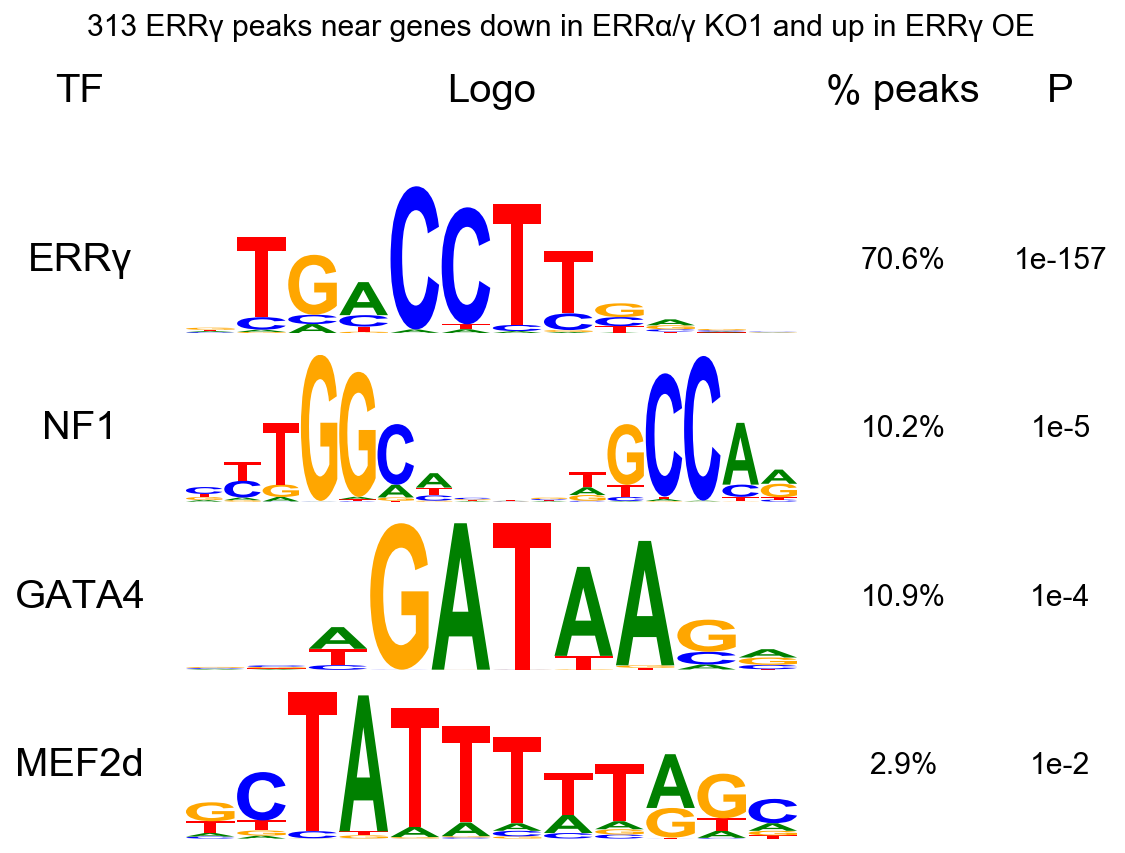

In [171]:
homer_logos_table.make_logos_table(os.path.join(f"data/ChIP-Seq/outs/motifs_oe_ko_intersection/OE_up_KO1_down.motifs", "knownResults"), 
                                   "pics/ERRg_near_OE_up_KO1_down_known_motifs.png",
                                   ["1+ERRγ", "14+NF1", "18+GATA4", "28+MEF2d"],
                                   title=f"313 ERRγ peaks near genes down in ERRα/γ KO1 and up in ERRγ OE")

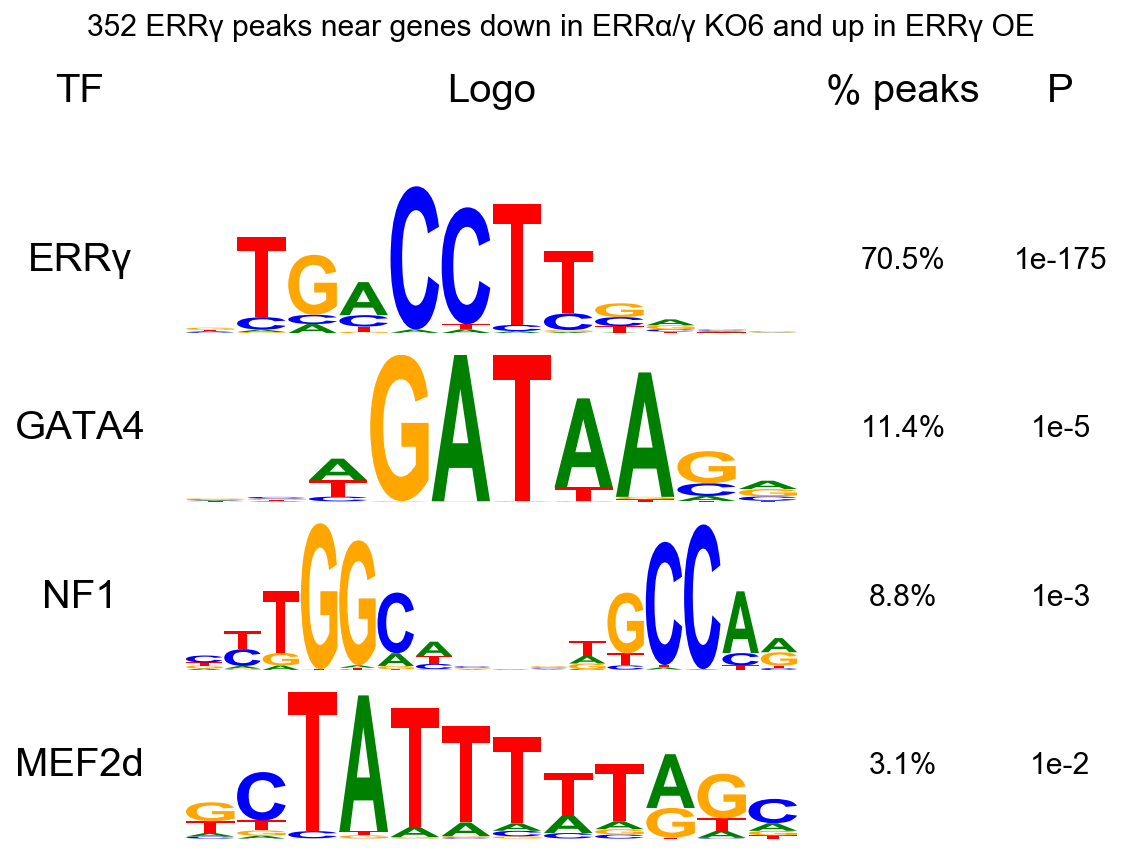

In [172]:
homer_logos_table.make_logos_table(os.path.join(f"data/ChIP-Seq/outs/motifs_oe_ko_intersection/OE_up_KO6_down.motifs", "knownResults"), 
                                   "pics/ERRg_near_OE_up_KO6_down_known_motifs.png",
                                   ["1+ERRγ", "17+GATA4", "22+NF1", "28+MEF2d"],
                                   title=f"352 ERRγ peaks near genes down in ERRα/γ KO6 and up in ERRγ OE")

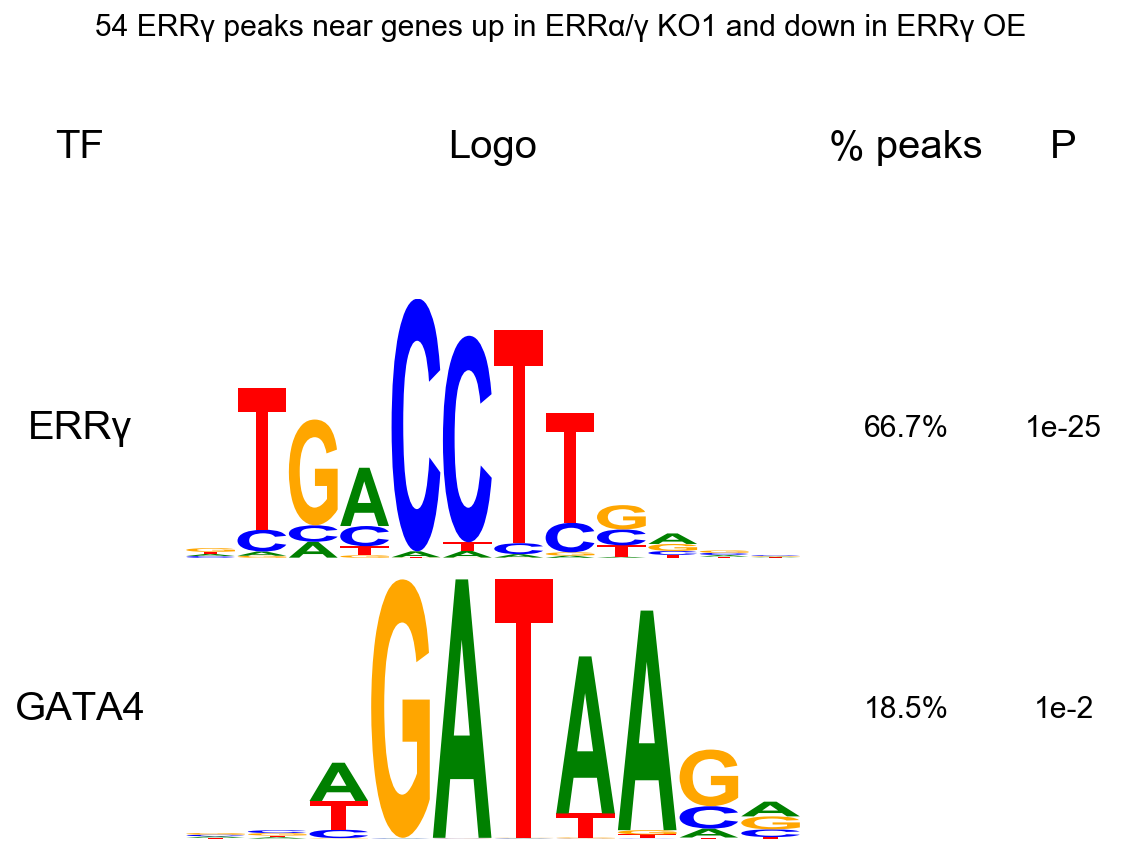

In [173]:
homer_logos_table.make_logos_table(os.path.join(f"data/ChIP-Seq/outs/motifs_oe_ko_intersection/OE_down_KO1_up.motifs", "knownResults"), 
                                   "pics/ERRg_near_OE_down_KO1_up_known_motifs.png",
                                   ["1+ERRγ", "19+GATA4"],
                                   title=f"54 ERRγ peaks near genes up in ERRα/γ KO1 and down in ERRγ OE")

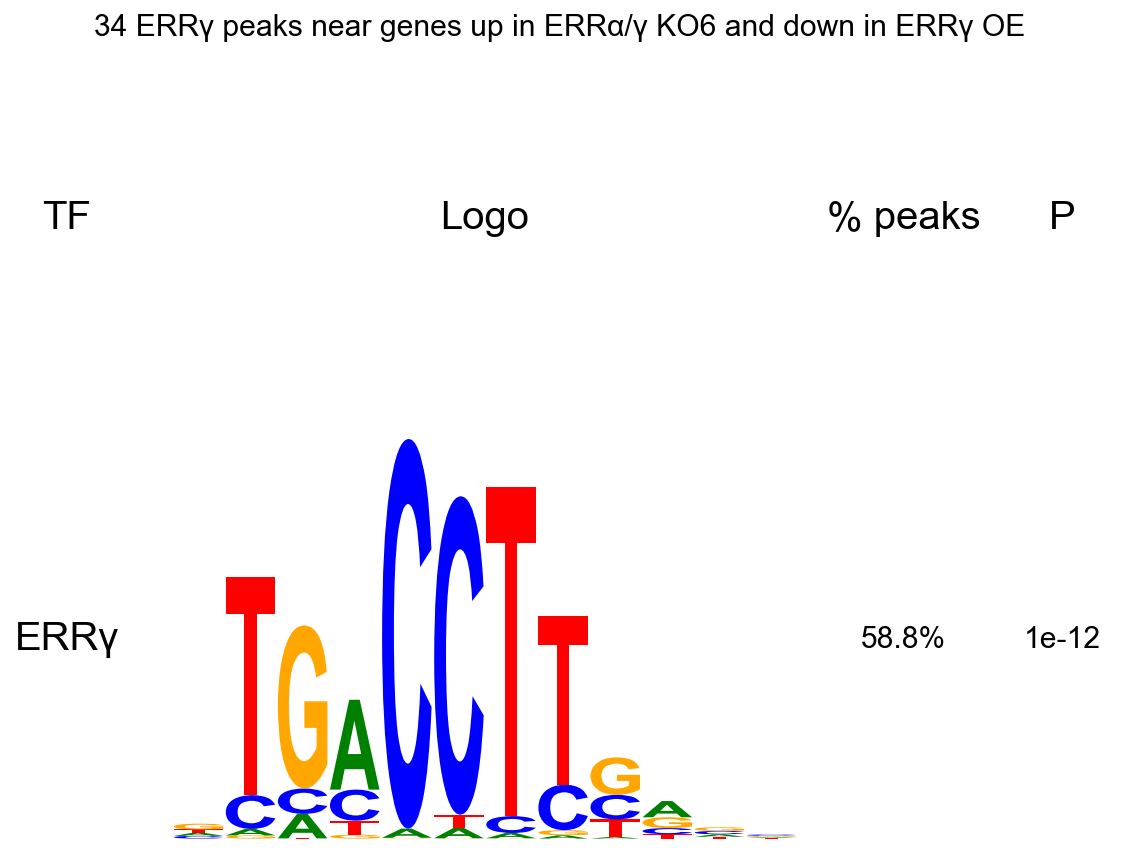

In [174]:
homer_logos_table.make_logos_table(os.path.join(f"data/ChIP-Seq/outs/motifs_oe_ko_intersection/OE_down_KO6_up.motifs", "knownResults"), 
                                   "pics/ERRg_near_OE_down_KO6_up_known_motifs.png",
                                   ["1+ERRγ"],
                                   title=f"34 ERRγ peaks near genes up in ERRα/γ KO6 and down in ERRγ OE")

In [178]:
count_file = os.path.join(outs_folder, "H3K27Ac_at_ERRg_peaks.counts")
count_data = pd.read_csv(count_file, sep="\t")

annotated_peaks_file = os.path.join(outs_folder, "ERRg_annotated.peaks")
errg_peaks = pd.read_csv(annotated_peaks_file, sep="\t", comment="#")
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]

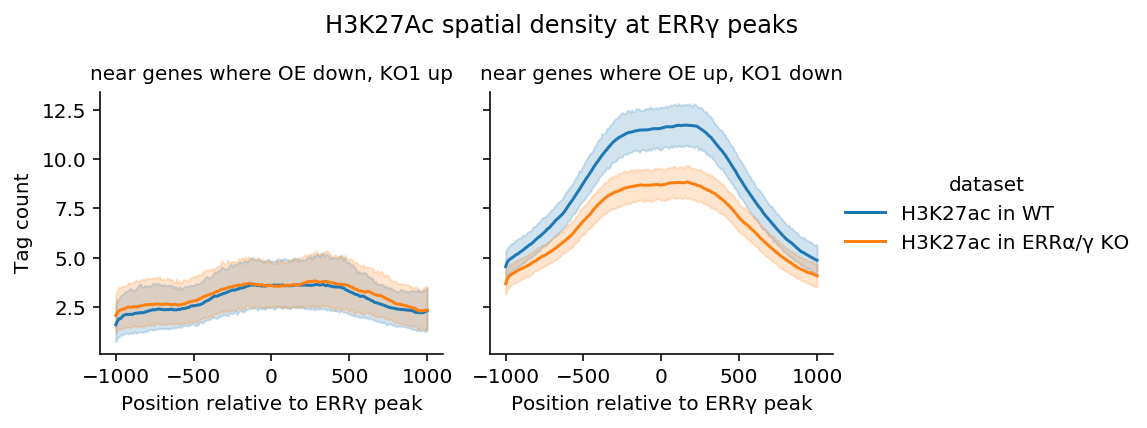

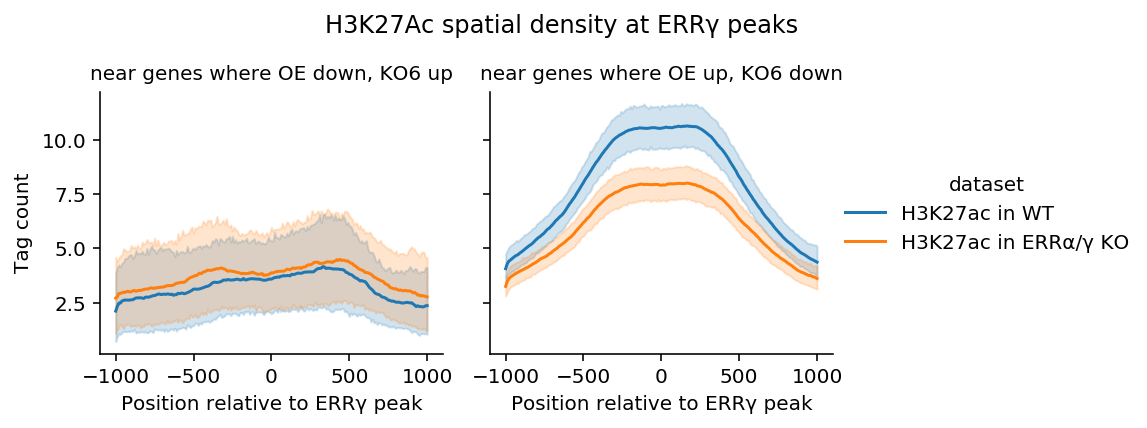

In [186]:
for ko in ["KO1", "KO6"]:
    plot_df = None
    ko_up_idx, ko_down_idx = updown(f'{ko} vs. WT')
    down_ko = set(de_data_merged.gene_id[ko_down_idx])
    up_oe_down_ko = up_oe & down_ko
    up_ko = set(de_data_merged.gene_id[ko_up_idx])
    down_oe_up_ko = down_oe & up_ko

    for dir_name, genes in [(f"OE down, {ko} up", down_oe_up_ko), (f"OE up, {ko} down", up_oe_down_ko)]:
        peaks = ensembl_gene_to_peak_id(errg_peaks, list(genes), max_distance_to_tss=max_distance_to_tss)
        count_data_dir = count_data[np.in1d(count_data.Gene, peaks)]
        df = counts_plot_df(count_data_dir, ac_count_datasets)
        df["direction"] = dir_name
        plot_df = pd.concat((plot_df, df))

    plot_df.loc[plot_df.dataset == "H3K27Ac-WT", "dataset"] = "H3K27ac in WT"
    plot_df.loc[plot_df.dataset == "H3K27Ac-KO", "dataset"] = "H3K27ac in ERRα/γ KO"
    g = sns.FacetGrid(plot_df, hue="dataset", col="direction")
    g.map(sns.lineplot, "variable", "value")
    g.add_legend()
    g.set_xlabels("Position relative to ERRγ peak")
    g.set_ylabels("Tag count")
    g.set_titles(col_template="near genes where {col_name}")
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle(f"H3K27Ac spatial density at ERRγ peaks")
    plt.savefig(f"pics/H3K27Ac_at_ERRg_peaks_near_OE_and_{ko}_intersection.png", dpi=300, bbox_inches='tight')    

In [10]:
metabolic_process_genes = set(metabolic_process_genes.converted)

In [11]:
heart_contraction_genes = set(heart_contraction_genes.converted)

In [12]:
print(f"{len(metabolic_process_genes)} metabolic process, {len(heart_contraction_genes)} heart contraction genes")

11830 metabolic process, 287 heart contraction genes


In [ ]:
gata4_annotated_peaks = os.path.join(outs_folder, "errg_peaks_with_gata4_count.peaks")
gata4_motif_file = os.path.join(outs_folder, "GATA4.motif")
!annotatePeaks.pl {annotated_peaks_file} {homer_genome} -m {gata4_motif_file} -nmotifs > {gata4_annotated_peaks}

In [21]:
gata4_motif_data = pd.read_csv(gata4_annotated_peaks, sep="\t")
gata4_motif_data = gata4_motif_data.set_index(gata4_motif_data.iloc[:, 0])

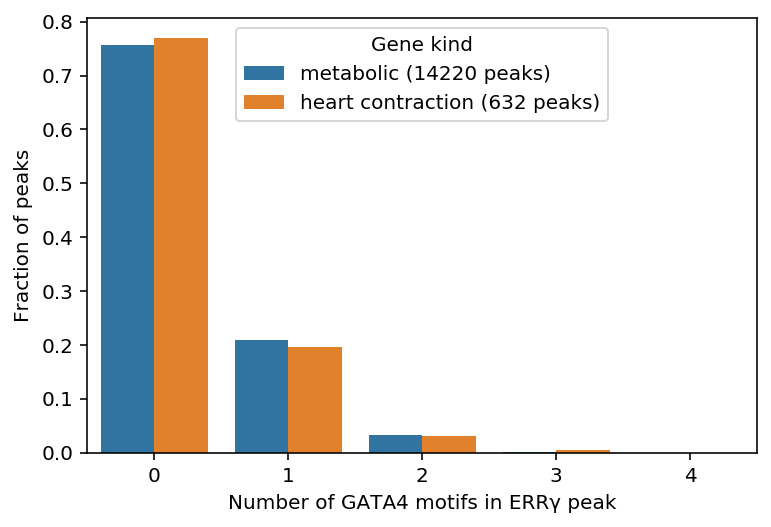

In [70]:
def plot_metabolic_and_heart_contraction_genes_distribution_vs_gata4(peaks_data):
    metabolic_peaks = peaks_data.loc[ensembl_gene_to_peak_id(peaks_data, list(metabolic_process_genes)), :]
    heart_contraction_peaks = peaks_data.loc[ensembl_gene_to_peak_id(peaks_data, list(heart_contraction_genes)), :]    
    
    gene_kind = []
    num_gata_motifs = []
    frequency_of_kind = []
    for peaks_set, name in [(metabolic_peaks, f"metabolic"), (heart_contraction_peaks, "heart contraction")]:
        name += f" ({len(peaks_set)} peaks)"
        for num, count in Counter(peaks_set.iloc[:, -1]).most_common():
            gene_kind.append(name)
            num_gata_motifs.append(num)
            frequency_of_kind.append(count / len(peaks_set))

    plot_data = pd.DataFrame({"Gene kind": gene_kind, "num_gata_motifs": num_gata_motifs, "frequency_of_kind": frequency_of_kind})
    sns.barplot(data=plot_data, x="num_gata_motifs", y="frequency_of_kind", hue="Gene kind")
    plt.xlabel("Number of GATA4 motifs in ERRγ peak")
    plt.ylabel("Fraction of peaks")
    
plot_metabolic_and_heart_contraction_genes_distribution_vs_gata4(gata4_motif_data)
plt.savefig("pics/metabolic_vs_heart_contraction_genes_by_gata4_all_errg_peaks.png", dpi=300)

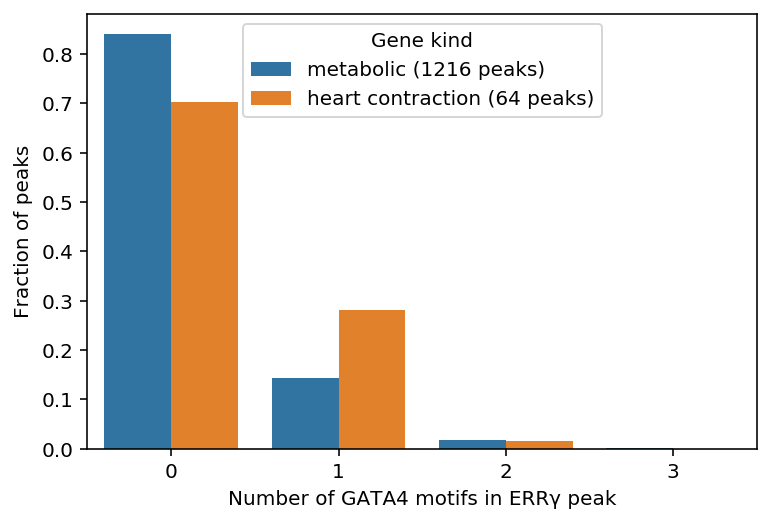

In [71]:
errg_peaks_with_ac_down_data = pd.read_csv(os.path.join(outs_folder, "ERRg_peaks_with_H3K27Ac_down_annotated.peaks"), sep="\t")
errg_peaks_with_ac_down_data = errg_peaks_with_ac_down_data.set_index(errg_peaks_with_ac_down_data.iloc[:, 0])
errg_peaks_with_ac_down_and_gata_data = pd.merge(errg_peaks_with_ac_down_data, gata4_motif_data, left_index=True, right_index=True, suffixes=("", "_g4"))
plot_metabolic_and_heart_contraction_genes_distribution_vs_gata4(errg_peaks_with_ac_down_and_gata_data)
plt.savefig("pics/metabolic_vs_heart_contraction_genes_by_gata4_errg_peaks_with_h3k27ac_down_in_ko.png", dpi=300)

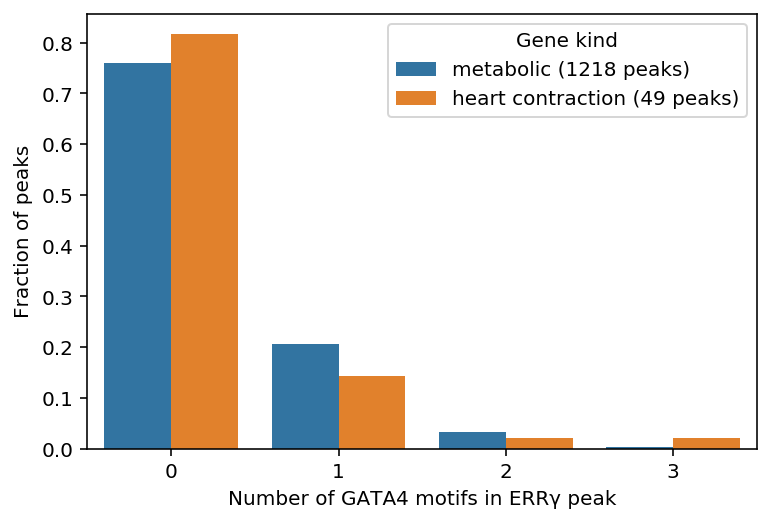

In [72]:
errg_peaks_with_ac_up_data = pd.read_csv(os.path.join(outs_folder, "ERRg_peaks_with_H3K27Ac_up_annotated.peaks"), sep="\t")
errg_peaks_with_ac_up_data = errg_peaks_with_ac_up_data.set_index(errg_peaks_with_ac_up_data.iloc[:, 0])
errg_peaks_with_ac_up_and_gata_data = pd.merge(errg_peaks_with_ac_up_data, gata4_motif_data, left_index=True, right_index=True, suffixes=("", "_g4"))
plot_metabolic_and_heart_contraction_genes_distribution_vs_gata4(errg_peaks_with_ac_up_and_gata_data)
plt.savefig("pics/metabolic_vs_heart_contraction_genes_by_gata4_errg_peaks_with_h3k27ac_up_in_ko.png", dpi=300)

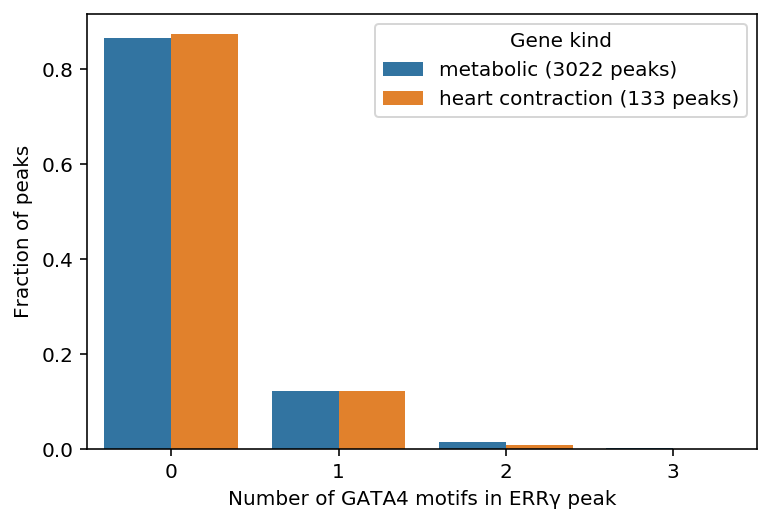

In [74]:
gata4_motif_data_nearby = gata4_motif_data.loc[gata4_motif_data.loc[:, "Distance to TSS"].abs() < max_distance_to_tss, :]
plot_metabolic_and_heart_contraction_genes_distribution_vs_gata4(gata4_motif_data_nearby)
plt.savefig("pics/metabolic_vs_heart_contraction_genes_by_gata4_at_errg_peaks_less_than_5kb_from_genes.png", dpi=300)

# Distance between ERRg and GATA4 inside SEs

In [5]:
se_regions = pd.read_csv("data/ChIP-Seq/med1/peaks/med1_se_hg38.peaks", sep="\t", header=None)
se_regions = se_regions.rename(columns={0: "se_id", 1: "chr", 2: "start", 3: "end"})

errg_peaks = pd.read_csv("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks",
                         sep="\t", header=None)

errg_peaks = errg_peaks.rename(columns={0: "errg_id", 1: "chr", 2: "start", 3: "end"})

gata4_peaks = pd.read_csv("data/ChIP-Seq/gata4/peaks/gata4_pooled.lchrom.peaks",
                         sep="\t", header=None)

gata4_peaks = gata4_peaks.rename(columns={0: "gata4_id", 1: "chr", 2: "start", 3: "end"})

In [6]:
all_dists = []

for se in se_regions.itertuples():
    intersected_errg = errg_peaks[(errg_peaks.chr == se.chr) & (errg_peaks.start <= se.end) & (errg_peaks.end >= se.start)]
    if len(intersected_errg) == 0:
        continue
        
    intersected_gata4 = gata4_peaks[(gata4_peaks.chr == se.chr) & (gata4_peaks.start <= se.end) & 
                                    (gata4_peaks.end >= se.start)]
    
    if len(intersected_gata4) == 0:
        continue
        
    dists = []
    for err in intersected_errg.itertuples():
        for gata4 in intersected_gata4.itertuples():
            if err.start <= gata4.end and err.end >= gata4.start:
                if "3883" in se.se_id:
                    print(err)
                    print(gata4)
                dists.append(0)
            else:
                for p1 in [err.start, err.end]:
                    for p2 in [gata4.start, gata4.end]:
                        dists.append(abs(p1 - p2))
        
    all_dists.append(min(dists))
    if min(dists) == 0 and "3883" in se.se_id:
        print(se)
        print(intersected_errg)
        print(intersected_gata4)
        print(dists)

In [7]:
len(all_dists)

99

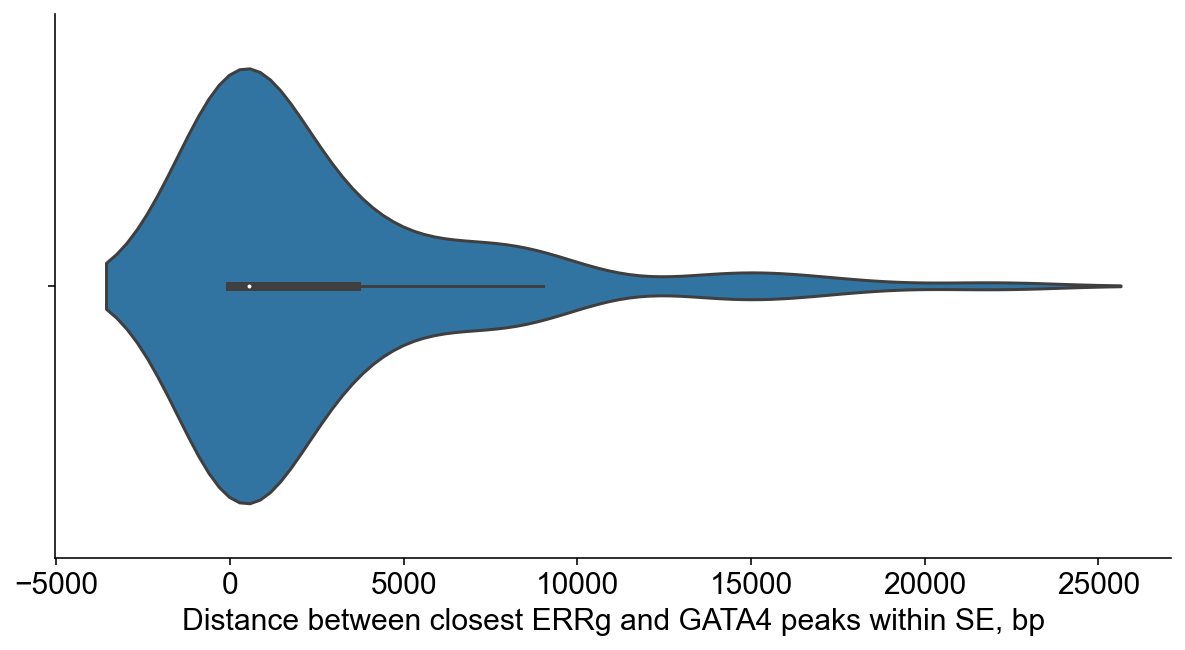

In [8]:
plt.figure(figsize=(10, 5))
sns.violinplot(x=all_dists)
plt.xlabel("Distance between closest ERRg and GATA4 peaks within SE, bp")
#plt.savefig("pics/med1/distance_between_closest_ERRg_and_GATA4_peaks.png", dpi=300)
plt.savefig("pics/med1/distance_between_closest_ERRg_and_GATA4_peaks.pdf")

# Heart background

In [7]:
expression_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name="FPKM")
expression_data["max_level"] = expression_data["KO1_1 KO1_2 KO6_1 KO6_2 KO6_3 WT_1 WT_2 WT_3".split(" ")].max(axis=1)
expressed_genes = expression_data.loc[expression_data.max_level > 10, "gene_id"]
expression_data.loc[expression_data.max_level > 10, ["gene_name", "gene_id", "max_level"]].to_excel("tables/heart_background_genes.xlsx", sheet_name="Genes", index=False)
print(len(expressed_genes))

8893


In [32]:
wb = openpyxl.load_workbook("tables/ERRg_peaks_by_H3K27Ac_direction_GO.xlsx")
del wb["Sheet"]
go_analysis_in_selection(counts_data.ac_down, "H3K27Ac_down_HBG", wb, background=expressed_genes)
go_analysis_in_selection(counts_data.ac_up, "H3K27Ac_up_HBG", wb, background=expressed_genes)
wb.save("tables/ERRg_peaks_by_H3K27Ac_direction_GO.xlsx")

Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_HBG_lc.peaks' hg38     > 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_down_HBG_annotated.peaks'
Enrichment analysis for 2007 genes in KEGG pathways...
Enrichment analysis for 2007 genes in Molecular function...
Enrichment analysis for 2007 genes in Cellular component...
Enrichment analysis for 2007 genes in Biological process...
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_up_HBG_lc.peaks' hg38     > 'data/ChIP-Seq/outs/ERRg_peaks_with_H3K27Ac_up_HBG_annotated.peaks'
Enrichment analysis for 2134 genes in KEGG pathways...
Enrichment analysis for 2134 genes in Molecular function...
No data for pics/GO/ERRg_peaks_with_H3K27Ac_up_HBG/GO:MF H3K27Ac_up_HBG.png
Enrichment analysis for 2134 genes in Cellular component...
No data for pics/GO/ERRg_peaks_with_H3K27Ac_up_HBG/GO:CC H3K27Ac_up_HBG.png
Enrichment analysis for 2134 genes in Biological process..

In [5]:
gene_ids_map = pd.read_csv("data/gene_id_map_human.tsv", sep="\t")
gene_ids_rmap = dict(zip(gene_ids_map.name, gene_ids_map["id"]))
gene_ids_map = dict(zip(gene_ids_map["id"], gene_ids_map.name))

In [38]:
wb = openpyxl.load_workbook("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx")
for ko in ["KO1", "KO6"]:
    de_genes_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name=f"{ko} vs. WT DE genes")
    up_genes = de_genes_data.loc[de_genes_data.log2FoldChange > 0, "gene_name"]
    gprofiler.go_analysis_for_genes(up_genes, f"{ko} up|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/ERRag_KO_HBG", "human", background=expressed_genes)
    down_genes = de_genes_data.loc[de_genes_data.log2FoldChange < 0, "gene_name"]
    gprofiler.go_analysis_for_genes(down_genes, f"{ko} down|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/ERRag_KO_HBG", "human", background=expressed_genes)
    
wb.save("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx")

Enrichment analysis for 2226 genes in KEGG pathways...
Enrichment analysis for 2226 genes in Molecular function...
Enrichment analysis for 2226 genes in Cellular component...
Enrichment analysis for 2226 genes in Biological process...
Enrichment analysis for 1812 genes in KEGG pathways...
Enrichment analysis for 1812 genes in Molecular function...
Enrichment analysis for 1812 genes in Cellular component...
Enrichment analysis for 1812 genes in Biological process...
Enrichment analysis for 2535 genes in KEGG pathways...
Enrichment analysis for 2535 genes in Molecular function...
Enrichment analysis for 2535 genes in Cellular component...
Enrichment analysis for 2535 genes in Biological process...
Enrichment analysis for 2378 genes in KEGG pathways...
Enrichment analysis for 2378 genes in Molecular function...
Enrichment analysis for 2378 genes in Cellular component...
Enrichment analysis for 2378 genes in Biological process...


In [48]:
wb = openpyxl.load_workbook("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx")
de_genes_data = [pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name=f"{ko} vs. WT DE genes") for ko in ["KO1", "KO6"]]
up_genes = [dd.loc[dd.log2FoldChange > 0, "gene_name"] for dd in de_genes_data]
up_genes = list(set(up_genes[0]) & set(up_genes[1]))
gprofiler.go_analysis_for_genes(up_genes, f"KO1and6 up|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/ERRag_KO_HBG", "human", background=expressed_genes)

down_genes = [dd.loc[dd.log2FoldChange < 0, "gene_name"] for dd in de_genes_data]
down_genes = list(set(down_genes[0]) & set(down_genes[1]))
gprofiler.go_analysis_for_genes(down_genes, f"KO1and6 down|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/ERRag_KO_HBG", "human", background=expressed_genes)

wb.save("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx")

Enrichment analysis for 1707 genes in KEGG pathways...
Enrichment analysis for 1707 genes in Molecular function...
Enrichment analysis for 1707 genes in Cellular component...
Enrichment analysis for 1707 genes in Biological process...
Enrichment analysis for 1509 genes in KEGG pathways...
Enrichment analysis for 1509 genes in Molecular function...
Enrichment analysis for 1509 genes in Cellular component...
Enrichment analysis for 1509 genes in Biological process...


In [40]:
wb = openpyxl.load_workbook("tables/ERRg_OE_DE.xlsx")
de_genes_data = pd.read_excel("tables/ERRg_OE_DE.xlsx", sheet_name=f"ERR vs. GFP DE genes")
up_genes = de_genes_data.loc[de_genes_data.log2FoldChange > 0, "gene_name"]
gprofiler.go_analysis_for_genes(up_genes, f"OE up|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/ERRag_OE_HBG", "human", background=expressed_genes)
down_genes = de_genes_data.loc[de_genes_data.log2FoldChange < 0, "gene_name"]
gprofiler.go_analysis_for_genes(down_genes, f"OE down|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/ERRag_OE_HBG", "human", background=expressed_genes)

wb.save("tables/ERRg_OE_DE.xlsx")

Enrichment analysis for 2540 genes in KEGG pathways...
Enrichment analysis for 2540 genes in Molecular function...
Enrichment analysis for 2540 genes in Cellular component...
Enrichment analysis for 2540 genes in Biological process...
Enrichment analysis for 2350 genes in KEGG pathways...
Enrichment analysis for 2350 genes in Molecular function...
Enrichment analysis for 2350 genes in Cellular component...
Enrichment analysis for 2350 genes in Biological process...


In [44]:
wb = openpyxl.load_workbook("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx")
gprofiler.go_analysis_for_genes(activated_genes_with_peaks, f"ERRg_act|HBG", gene_ids_map, wb, 0.05, 2, "pics/activated genes with ERRg peaks GO", "human", 
                                background=expressed_genes)

wb.save("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx")

Enrichment analysis for 737 genes in KEGG pathways...
Enrichment analysis for 737 genes in Molecular function...
Enrichment analysis for 737 genes in Cellular component...
Enrichment analysis for 737 genes in Biological process...


In [146]:
peak_data = pd.read_excel("tables/ERRg+GATA4_peaks.xlsx", sheet_name="ERRg+GATA4 peaks")
genes = list(set(peak_data["Nearest Ensembl"][~pd.isna(peak_data["Nearest Ensembl"])]))
wb = openpyxl.load_workbook("tables/ERRg+GATA4_peaks.xlsx")
gprofiler.go_analysis_for_genes(genes, f"ERRg+GATA4|HBG", gene_ids_map, wb, 0.05, 2, "pics/gata4/GO/ERRg+GATA4/", "human", 
                                background=expressed_genes)

wb.save("tables/ERRg+GATA4_peaks.xlsx")

Enrichment analysis for 3153 genes in KEGG pathways...
Enrichment analysis for 3153 genes in Molecular function...
Enrichment analysis for 3153 genes in Cellular component...
Enrichment analysis for 3153 genes in Biological process...


In [145]:
peak_data = pd.read_excel("tables/ERRg+GATA6_peaks.xlsx", sheet_name="ERRg+GATA6 peaks")
genes = list(set(peak_data["Nearest Ensembl"][~pd.isna(peak_data["Nearest Ensembl"])]))
wb = openpyxl.load_workbook("tables/ERRg+GATA6_peaks.xlsx")
gprofiler.go_analysis_for_genes(genes, f"ERRg+GATA6|HBG", gene_ids_map, wb, 0.05, 2, "pics/gata6/GO/ERRg+GATA6/", "human", 
                                background=expressed_genes)

wb.save("tables/ERRg+GATA6_peaks.xlsx")

Enrichment analysis for 1139 genes in KEGG pathways...
No data for pics/gata6/GO/ERRg+GATA6/KEGG ERRg+GATA6|HBG.png
Enrichment analysis for 1139 genes in Molecular function...
No data for pics/gata6/GO/ERRg+GATA6/GO:MF ERRg+GATA6|HBG.png
Enrichment analysis for 1139 genes in Cellular component...
No data for pics/gata6/GO/ERRg+GATA6/GO:CC ERRg+GATA6|HBG.png
Enrichment analysis for 1139 genes in Biological process...
No data for pics/gata6/GO/ERRg+GATA6/GO:BP ERRg+GATA6|HBG.png
No results to put to worksheet


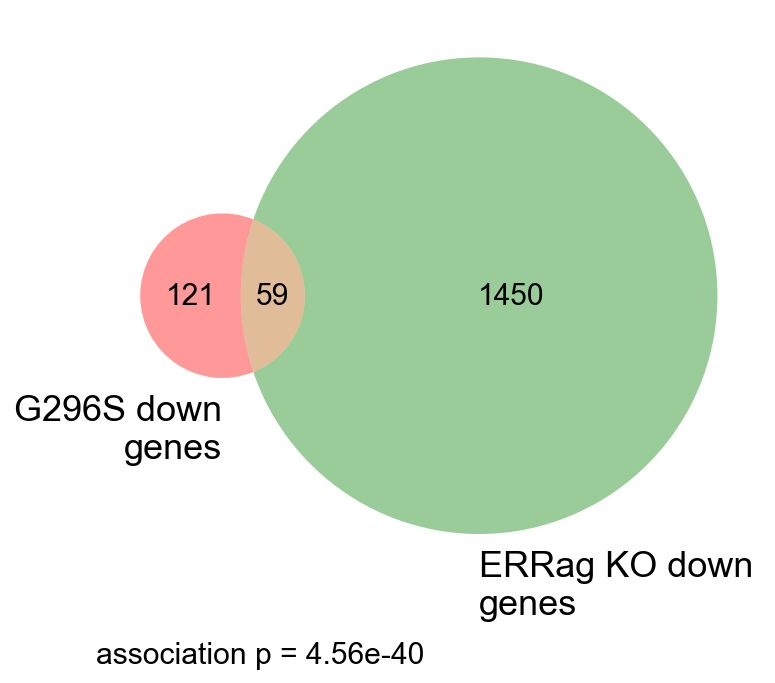

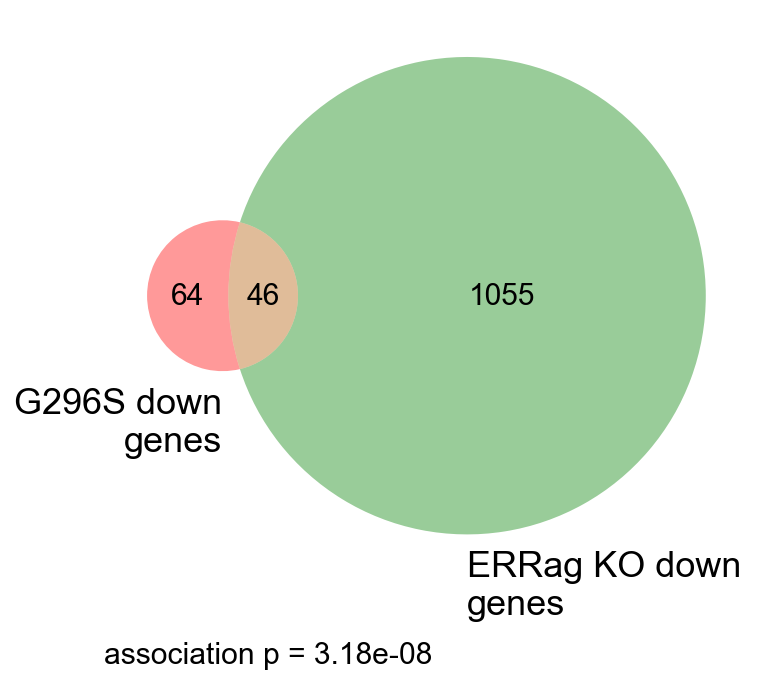

In [44]:
gata4_mutant_down_genes = pd.read_excel("info/downregulated genes in G296S_211014.xlsx", sheet_name="Sheet1")
de_genes_data = [pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name=f"{ko} vs. WT DE genes") for ko in ["KO1", "KO6"]]
ko_down_genes = [dd.loc[dd.log2FoldChange < 0, "gene_name"] for dd in de_genes_data]
ko_down_genes = [gene_ids_rmap[g] for g in set(ko_down_genes[0]) & set(ko_down_genes[1])]
#venn2([set(gata4_mutant_down_genes["EnsembleID"]), set(ko_down_genes)], ["G296S down\ngenes", "ERRag KO down\ngenes"])

homer_tools.compare_gene_sets(gata4_mutant_down_genes["EnsembleID"], ko_down_genes, "G296S down\ngenes", "ERRag KO down\ngenes", background=gene_ids_map)
plt.subplots_adjust(bottom=-0.1)
plt.savefig("pics/G296S_vs_ERRagKO_down_genes_venn.png", dpi=300, bbox_inches="tight")

plt.figure()
homer_tools.compare_gene_sets(gata4_mutant_down_genes["EnsembleID"], ko_down_genes, "G296S down\ngenes", "ERRag KO down\ngenes", background=expressed_genes)
plt.subplots_adjust(bottom=-0.1)
plt.savefig("pics/G296S_vs_ERRagKO_down_genes_HBG_venn.png", dpi=300, bbox_inches="tight")

Enrichment analysis for 59 genes in KEGG pathways...
No data for pics/GO/G296S_and_ERRagKO_down/KEGG Common_down.png
Enrichment analysis for 59 genes in Molecular function...
No data for pics/GO/G296S_and_ERRagKO_down/GO:MF Common_down.png
Enrichment analysis for 59 genes in Cellular component...
Enrichment analysis for 59 genes in Biological process...
Enrichment analysis for 59 genes in KEGG pathways...
No data for pics/GO/G296S_and_ERRagKO_down/KEGG Common_down|HBG.png
Enrichment analysis for 59 genes in Molecular function...
No data for pics/GO/G296S_and_ERRagKO_down/GO:MF Common_down|HBG.png
Enrichment analysis for 59 genes in Cellular component...
Enrichment analysis for 59 genes in Biological process...


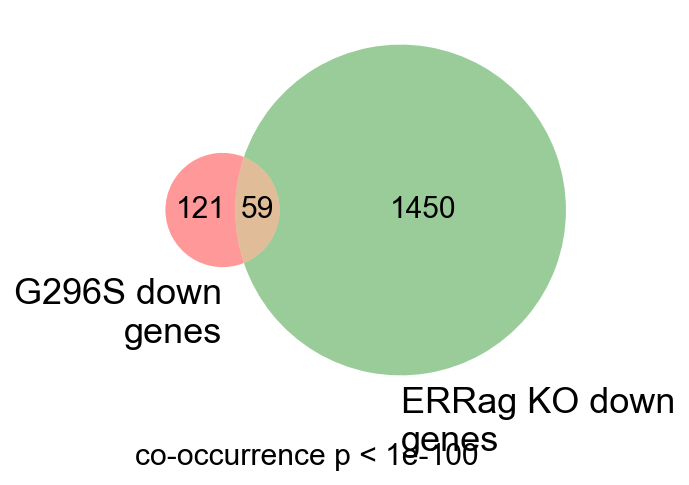

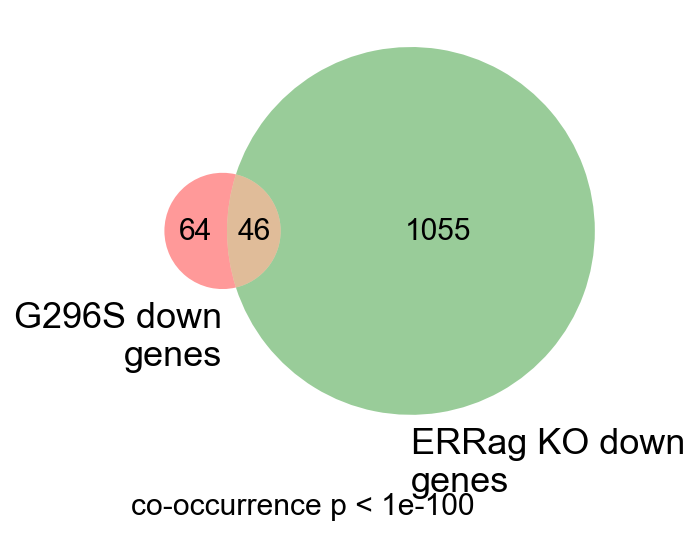

In [17]:
wb = openpyxl.Workbook()
genes = list(set(gata4_mutant_down_genes["EnsembleID"]) & set(ko_down_genes))
gprofiler.go_analysis_for_genes(genes, f"Common_down", gene_ids_map, wb, 0.05, 2, "pics/GO/G296S_and_ERRagKO_down/", "human", 
                                background=None)

gprofiler.go_analysis_for_genes(genes, f"Common_down|HBG", gene_ids_map, wb, 0.05, 2, "pics/GO/G296S_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

del wb["Sheet"]
wb.save("tables/G296S_and_ERRagKO_down_GO.xlsx")

# Translational - HFpEF/HFrEF

In [27]:
hf_de_data = pd.read_csv("data/RNA-Seq/HFpEF/DEG_allresultsRVS.csv")
hf_de_genes = {}
hf_de_genes["HFpEF"] = hf_de_data.loc[hf_de_data["padj.pef"] < 0.05, "geneid"]
hf_de_genes["HFrEF"] = hf_de_data.loc[hf_de_data["padj.ref"] < 0.05, "geneid"]

hf_down_genes = {}
hf_down_genes["HFpEF"] = hf_de_data.loc[(hf_de_data["padj.pef"] < 0.05) & (hf_de_data["l2fc.pef"] < 0), "geneid"]
hf_down_genes["HFrEF"] = hf_de_data.loc[(hf_de_data["padj.ref"] < 0.05) & (hf_de_data["l2fc.ref"] < 0), "geneid"]

In [61]:
hfref_de_genes = hf_de_data.loc[hf_de_data["padj.ref"] < 0.05, ["geneid", "l2fc.ref"]]
de_genes_data = [pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name=f"{ko} vs. WT DE genes") for ko in ["KO1", "KO6"]]
ko_de_genes = set(de_genes_data[0].gene_name) & set(de_genes_data[1].gene_name)
de_genes_data = [dd.set_index("gene_name").loc[ko_de_genes, :] for dd in de_genes_data]
de_genes_data = pd.DataFrame({"geneid": [gene_ids_rmap[g] for g in de_genes_data[0].index], 
                              "ko1_6_l2fc": 0.5 * (de_genes_data[0].log2FoldChange + de_genes_data[0].log2FoldChange)})

all_gene_ids = list(set(de_genes_data.geneid) | set(hfref_de_genes.geneid))
hfref_de_genes = hfref_de_genes.set_index("geneid")
de_genes_data = de_genes_data.set_index("geneid")
common_data = []
for gid in all_gene_ids:
    if gid in hfref_de_genes.index:
        hfref_l2fc = hfref_de_genes.loc[gid, "l2fc.ref"]
        if not isinstance(hfref_l2fc, float):
            hfref_l2fc = hfref_l2fc.iloc[0]
    else:
        hfref_l2fc = 0
        
    if gid in de_genes_data.index:
        errag_l2fc = de_genes_data.loc[gid, "ko1_6_l2fc"]
    else:
        errag_l2fc = 0
        
    common_data.append({"geneid": gid, "hfref_l2fc": hfref_l2fc, "errag_l2fc": errag_l2fc})
    
common_data = pd.DataFrame.from_records(common_data)
common_data.to_csv("data/RNA-Seq/HFpEF/common_degs.csv", index=False)

In [60]:
hfref_de_genes.loc["ENSG00000185164",]

l2fc.ref
geneid                   
ENSG00000185164 -0.378468
ENSG00000185164 -0.378468

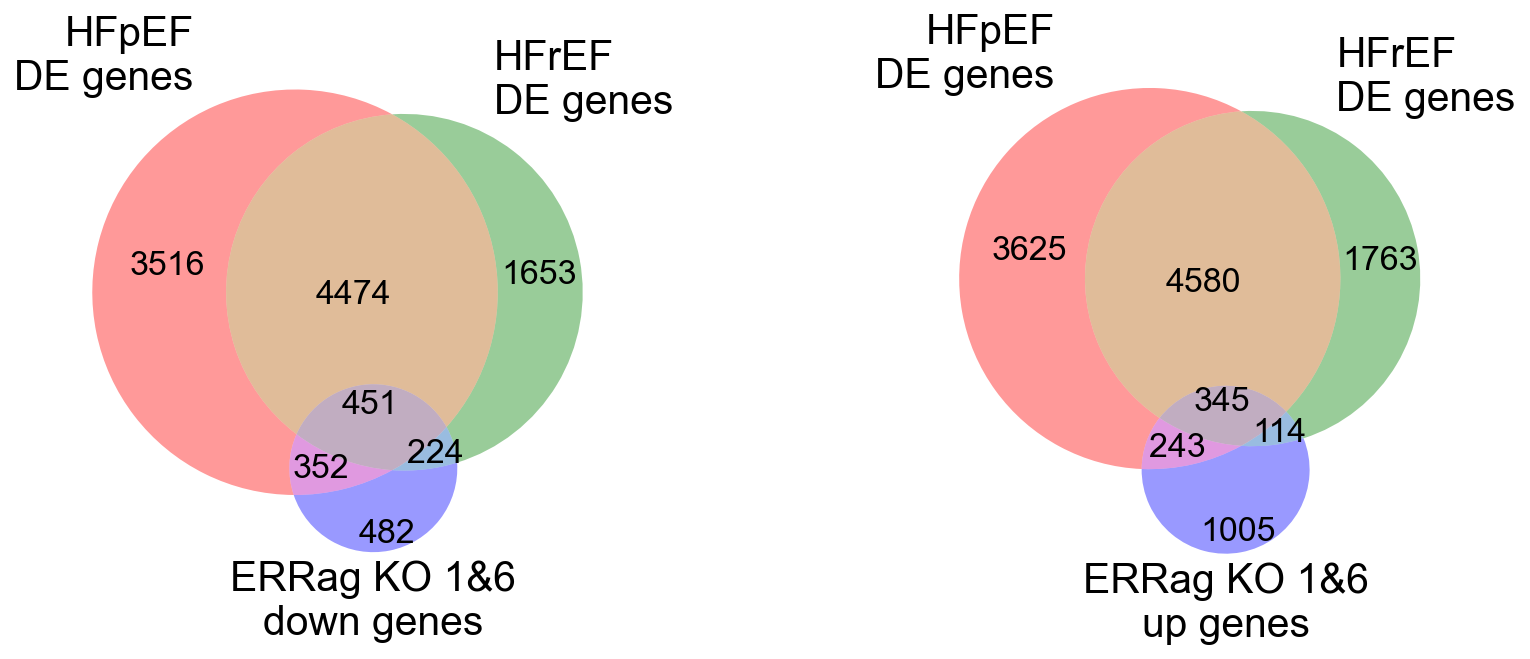

In [67]:
de_genes_data = [pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name=f"{ko} vs. WT DE genes") for ko in ["KO1", "KO6"]]
ko_down_genes = [dd.loc[dd.log2FoldChange < 0, "gene_name"] for dd in de_genes_data]
ko_down_genes = [gene_ids_rmap[g] for g in set(ko_down_genes[0]) & set(ko_down_genes[1])]
ko_up_genes = [dd.loc[dd.log2FoldChange > 0, "gene_name"] for dd in de_genes_data]
ko_up_genes = [gene_ids_rmap[g] for g in set(ko_up_genes[0]) & set(ko_up_genes[1])]

fig = plt.figure(figsize=[14, 5])
gs = GridSpec(1, 2)
fig.add_subplot(gs[0])
venn3([set(gg) for gg in hf_de_genes.values()] + [set(ko_down_genes)], [f"{d}\nDE genes" for d in hf_de_genes.keys()] + ["ERRag KO 1&6\ndown genes"])

fig.add_subplot(gs[1])
venn3([set(gg) for gg in hf_de_genes.values()] + [set(ko_up_genes)], [f"{d}\nDE genes" for d in hf_de_genes.keys()] + ["ERRag KO 1&6\nup genes"])

misc.make_sure_folder_exists("pics/HF_intersection")
plt.savefig("pics/HF_intersection/HFpEF_HFrEF_ERRagKO_venn.png", dpi=300)

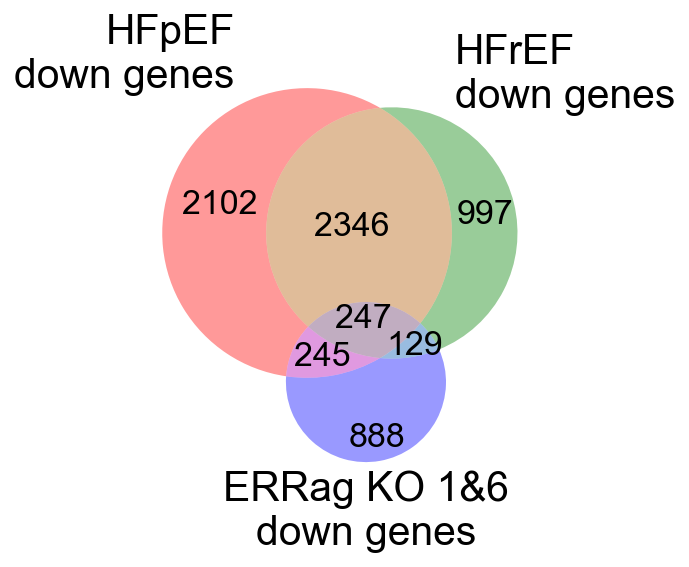

In [102]:
venn3([set(gg) for gg in hf_down_genes.values()] + [set(ko_down_genes)], [f"{d}\ndown genes" for d in hf_de_genes.keys()] + ["ERRag KO 1&6\ndown genes"])
plt.savefig("pics/HF_intersection/HFall_down_ERRagKO_down_venn.png", dpi=300)

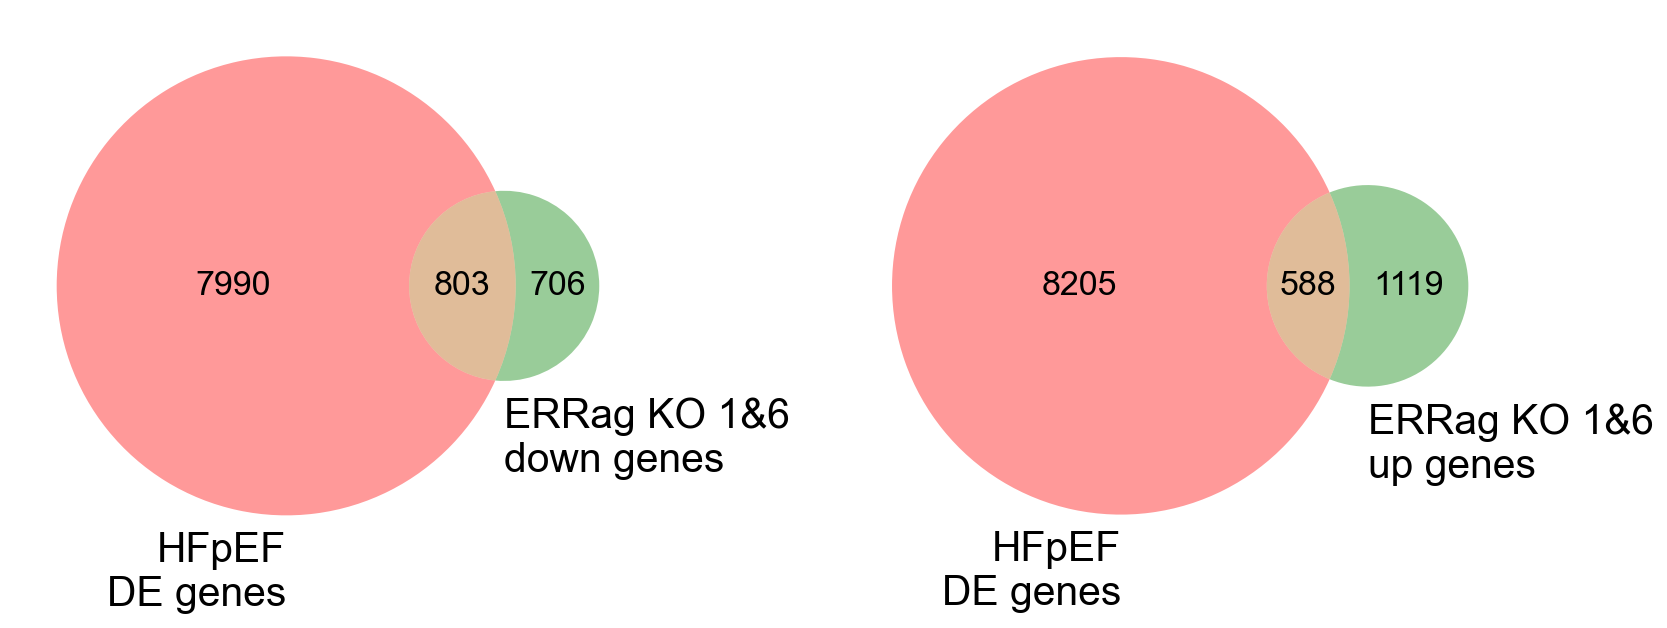

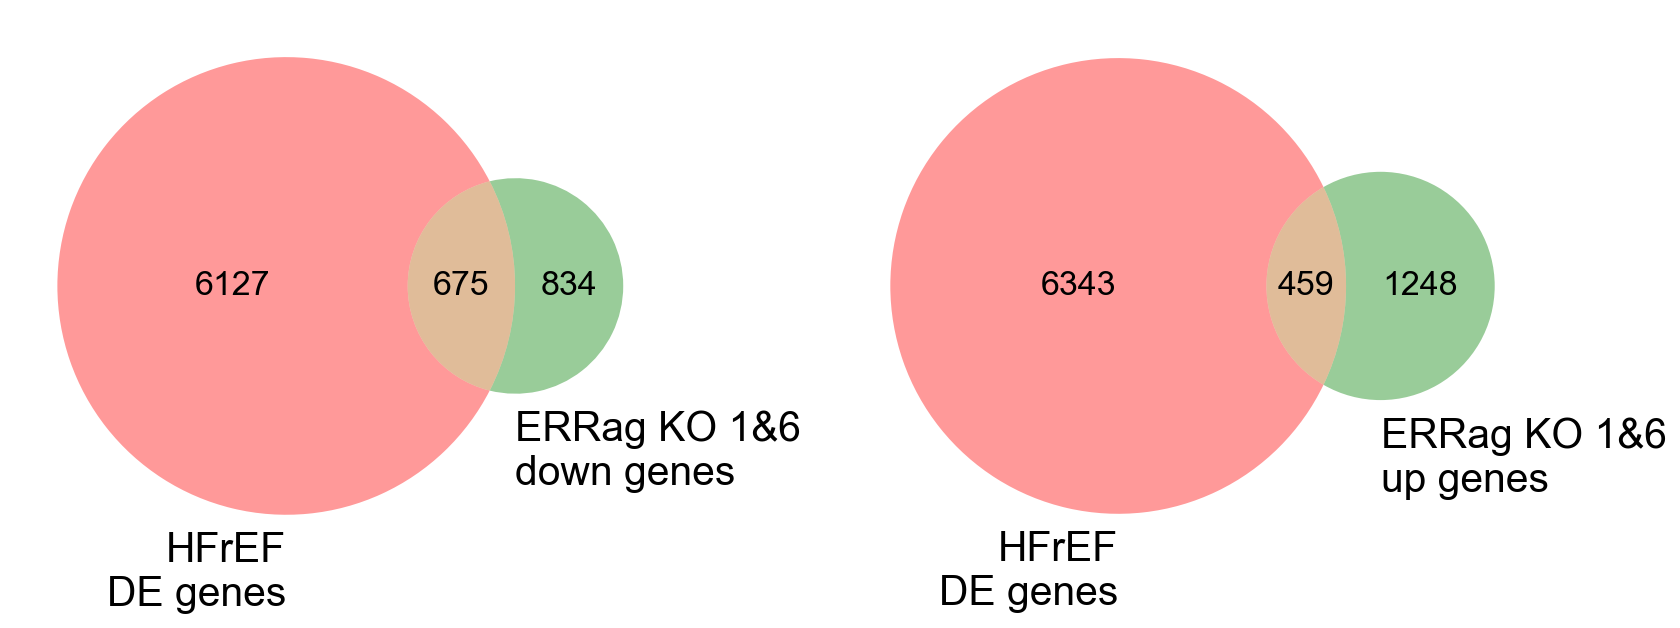

In [95]:
for d in ["HFpEF", "HFrEF"]:
    fig = plt.figure(figsize=[14, 5])
    gs = GridSpec(1, 2)
    fig.add_subplot(gs[0])
    venn2([set(hf_de_genes[d]), set(ko_down_genes)], [f"{d}\nDE genes", "ERRag KO 1&6\ndown genes"])

    fig.add_subplot(gs[1])
    venn2([set(hf_de_genes[d]), set(ko_up_genes)], [f"{d}\nDE genes", "ERRag KO 1&6\nup genes"])

    misc.make_sure_folder_exists("pics/HF_intersection")
    plt.savefig(f"pics/HF_intersection/{d}_ERRagKO_venn.png", dpi=300)

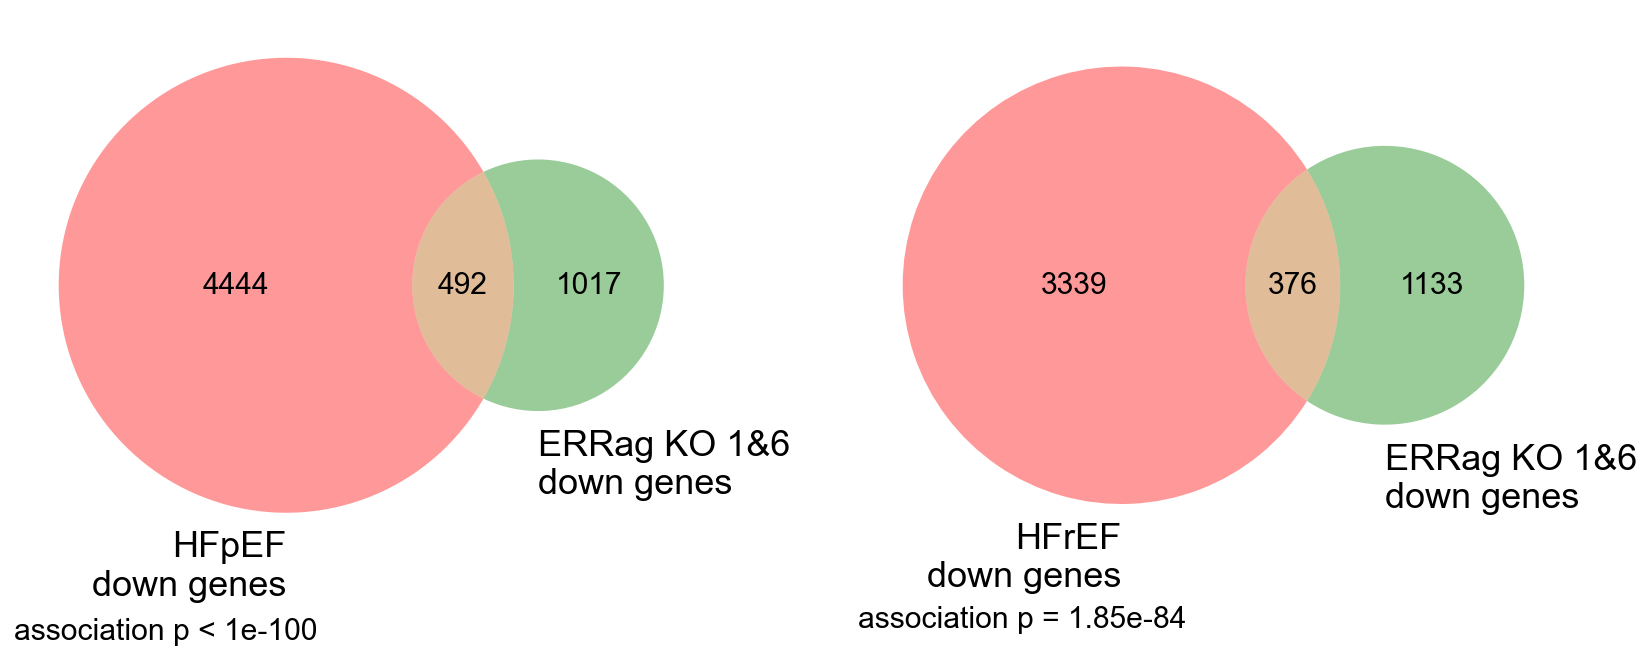

In [31]:
fig = plt.figure(figsize=[14, 5])
gs = GridSpec(1, 2)
for i, d in enumerate(["HFpEF", "HFrEF"]):
    fig.add_subplot(gs[i])
    homer_tools.compare_gene_sets(hf_down_genes[d], ko_down_genes, f"{d}\ndown genes", "ERRag KO 1&6\ndown genes", background=gene_ids_map)
    #venn2([set(), set(ko_down_genes)], [])

plt.savefig(f"pics/HF_intersection/HF_and_ERRagKO_down_venn.png", dpi=300)

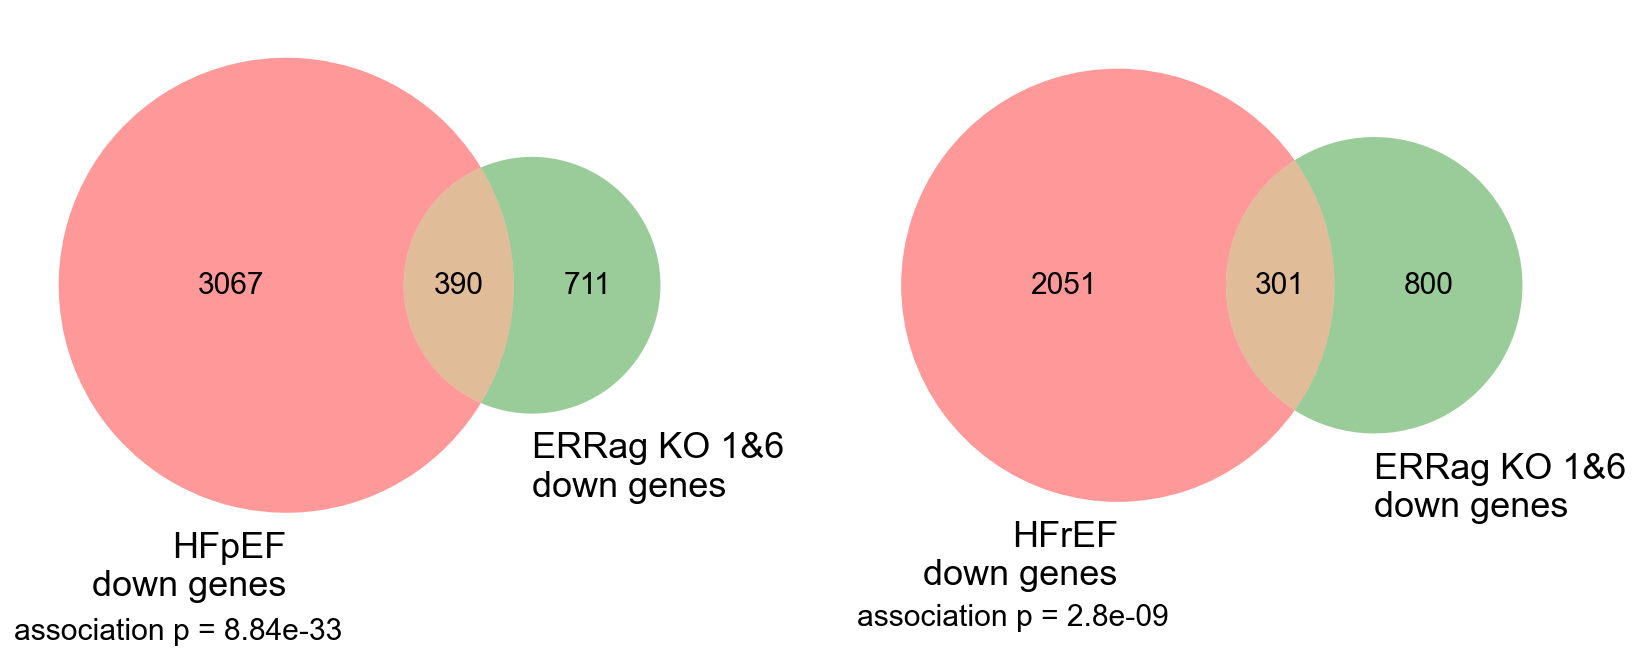

In [30]:
fig = plt.figure(figsize=[14, 5])
gs = GridSpec(1, 2)
for i, d in enumerate(["HFpEF", "HFrEF"]):
    fig.add_subplot(gs[i])
    homer_tools.compare_gene_sets(hf_down_genes[d], ko_down_genes, f"{d}\ndown genes", "ERRag KO 1&6\ndown genes", background=expressed_genes)
    #venn2([set(), set(ko_down_genes)], [])

plt.savefig(f"pics/HF_intersection/HF_and_ERRagKO_down_HBG_venn.png", dpi=300)

In [42]:
len(set(expressed_genes) - set(hf_down_genes[d]) - set(ko_down_genes))

5741

In [45]:
scipy.stats.fisher_exact([[5741, 2352], [1101, 301]])

(0.667312724363133, 2.796554643523121e-09)

In [104]:
wb = openpyxl.Workbook()
genes = list(set(hf_de_genes["HFpEF"]) & set(hf_de_genes["HFrEF"]) & set(ko_down_genes))
gene_names = [gene_ids_map[g] for g in genes]
hf_de_data = hf_de_data.reset_index().set_index("geneid")
genes_df = pd.DataFrame({
    "gene_id": genes, "gene_name": gene_names, 
    "HFpEF padj": hf_de_data.loc[genes, "padj.pef"].values,
    "HFpEF log2FC": hf_de_data.loc[genes, "l2fc.pef"].values,
    "HFrEF padj": hf_de_data.loc[genes, "padj.ref"].values,
    "HFrEF log2FC": hf_de_data.loc[genes, "l2fc.ref"].values,
    "ERRag KO1 padj": de_genes_data[0].set_index("gene_name").loc[gene_names, "padj"].values,
    "ERRag KO1 log2FC": de_genes_data[0].set_index("gene_name").loc[gene_names, "log2FoldChange"].values,
    "ERRag KO6 padj": de_genes_data[1].set_index("gene_name").loc[gene_names, "padj"].values,
    "ERRag KO6 log2FC": de_genes_data[1].set_index("gene_name").loc[gene_names, "log2FoldChange"].values,
})

misc.write_dataframe_to_worksheet(wb.create_sheet("Genes"), genes_df)

hfpef_ref_de_genes = pd.DataFrame({
    "gene_id": hf_de_data.index, "gene_name": hf_de_data.external_gene_name, 
    "HFpEF padj": hf_de_data.loc[:, "padj.pef"].values,
    "HFpEF log2FC": hf_de_data.loc[:, "l2fc.pef"].values,
    "HFrEF padj": hf_de_data.loc[:, "padj.ref"].values,
    "HFrEF log2FC": hf_de_data.loc[:, "l2fc.ref"].values,
})

misc.write_dataframe_to_worksheet(wb.create_sheet("All HFpEF HFrEF DEGs"), hfpef_ref_de_genes)

gprofiler.go_analysis_for_genes(genes, f"HFall_ERRagDown|HBG", gene_ids_map, wb, 0.05, 2, "pics/HF_intersection/GO/HFpEF_and_HFrEF_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

genes = list(set(hf_de_genes["HFpEF"]) & set(ko_down_genes))
gprofiler.go_analysis_for_genes(genes, f"HFpEFall_ERRagDown|HBG", gene_ids_map, wb, 0.05, 2, "pics/HF_intersection/GO/HFpEF_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

genes = list(set(hf_de_genes["HFrEF"]) & set(ko_down_genes))
gprofiler.go_analysis_for_genes(genes, f"HFrEFall_ERRagDown|HBG", gene_ids_map, wb, 0.05, 2, "pics/HF_intersection/GO/HFrEF_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

genes = list(set(hf_down_genes["HFpEF"]) & set(hf_down_genes["HFrEF"]) & set(ko_down_genes))
gprofiler.go_analysis_for_genes(genes, f"HFDown_ERRagDown|HBG", gene_ids_map, wb, 0.05, 2, "pics/HF_intersection/GO/HF_down_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

genes = list(set(hf_down_genes["HFpEF"]) & set(ko_down_genes))
gprofiler.go_analysis_for_genes(genes, f"HFpEFDown_ERRagDown|HBG", gene_ids_map, wb, 0.05, 2, "pics/HF_intersection/GO/HFpEF_down_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

genes = list(set(hf_down_genes["HFrEF"]) & set(ko_down_genes))
gprofiler.go_analysis_for_genes(genes, f"HFrEFDown_ERRagDown|HBG", gene_ids_map, wb, 0.05, 2, "pics/HF_intersection/GO/HFrEF_down_and_ERRagKO_down/", "human", 
                                background=expressed_genes)

del wb["Sheet"]
wb.save("tables/HFpEF_and_HFrEF_and_ERRagKO_down_GO.xlsx")

Enrichment analysis for 451 genes in KEGG pathways...
Enrichment analysis for 451 genes in Molecular function...
Enrichment analysis for 451 genes in Cellular component...
Enrichment analysis for 451 genes in Biological process...
Enrichment analysis for 803 genes in KEGG pathways...
Enrichment analysis for 803 genes in Molecular function...
Enrichment analysis for 803 genes in Cellular component...
Enrichment analysis for 803 genes in Biological process...
Enrichment analysis for 675 genes in KEGG pathways...
Enrichment analysis for 675 genes in Molecular function...
Enrichment analysis for 675 genes in Cellular component...
Enrichment analysis for 675 genes in Biological process...
Enrichment analysis for 247 genes in KEGG pathways...
Enrichment analysis for 247 genes in Molecular function...
No data for pics/HF_intersection/GO/HF_down_and_ERRagKO_down/GO:MF HFDown_ERRagDown|HBG.png
Enrichment analysis for 247 genes in Cellular component...
No data for pics/HF_intersection/GO/HF_down

In [99]:
hfpef_ref_de_genes[np.in1d(hfpef_ref_de_genes.gene_name, ["ESRRA", "ESRRG", "PPARGC1A", "GATA4"])]

gene_id gene_name    HFpEF padj  HFpEF log2FC  \
geneid                                                                   
ENSG00000173153  ENSG00000173153     ESRRA  3.442540e-16     -0.490188   
ENSG00000109819  ENSG00000109819  PPARGC1A  1.844850e-12     -0.628519   
ENSG00000196482  ENSG00000196482     ESRRG  3.955589e-03     -0.235174   
ENSG00000136574  ENSG00000136574     GATA4  8.356359e-01      0.012002   

                   HFrEF padj  HFrEF log2FC  
geneid                                       
ENSG00000173153  1.623380e-18     -0.566839  
ENSG00000109819  1.669258e-02     -0.244875  
ENSG00000196482  2.401680e-06     -0.412564  
ENSG00000136574  9.638187e-02      0.096783

# H3K27ac stuff

Running command w/120 threads: mergePeaks -d given 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' 'data/ChIP-Seq/outs/H3K27Ac_WT_over_KO.peaks' -matrix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.matrix' -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.peaks'


('data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.venn',
 (32579, 473, 638),
 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.peaks',
 0.0)

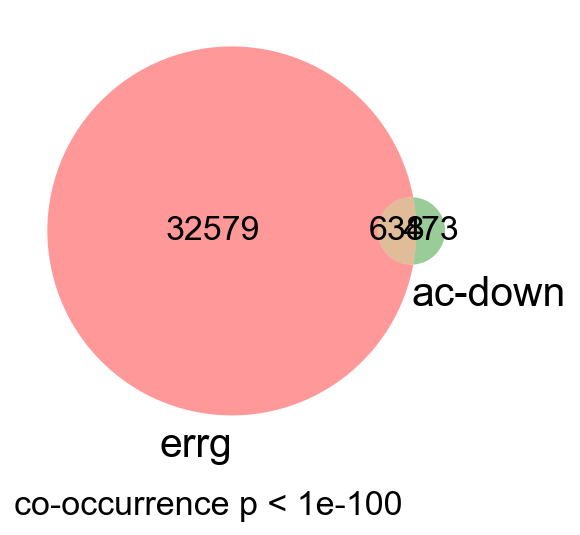

In [148]:
errg_peaks = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
h3k27ac_down_peaks = "data/ChIP-Seq/outs/H3K27Ac_WT_over_KO.peaks"
homer_tools.compare_peaks(errg_peaks, h3k27ac_down_peaks, "errg", "ac-down")

In [139]:
merged_atac_data = pd.read_csv(merged_peaks, sep="\t", low_memory=False)
np.maximum(merged_atac_data["end"] - merged_atac_data["start"], 5000).sum()

899737753

In [143]:
errg_peaks = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
h3k27ac_wt_peaks = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks"
!mergePeaks -matrix asdf '{errg_peaks}' '{h3k27ac_wt_peaks}' -gsize 900000000 > /dev/null

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks (33253 total) and data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks (33253 total)
	Comparing data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks (33253 total) and data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks (28602 total)
	Comparing data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks (28602 total) and data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks (33253 total)
	Comparing data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks (28602 total) and data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks (28602 total)

data/ChIP-Seq/ERRg ChIP-seq in iPSC-C

In [160]:
err_with_gata4_peaks = "data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks"
err_without_gata4_peaks = "data/ChIP-Seq/gata4/peaks/ERRg_only.annotated.peaks"
motifs_folder = "data/ChIP-Seq/gata4/motifs"
misc.make_sure_folder_exists(motifs_folder)
motifs_dest = os.path.join(motifs_folder, "ERRg+GATA4_vs_ERRg_without_GATA4")
runner = parallel_run.LocalRunner("logs/err+gata4_vs_err_nogata4_motifs.log")
homer_tools.find_motifs(err_with_gata4_peaks, homer_genome, 200, motifs_dest, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=err_without_gata4_peaks)

runner.run(wait=False)

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks hg38 data/ChIP-Seq/gata4/motifs/ERRg+GATA4_vs_ERRg_without_GATA4 -size 200  -S 15 -len 10,12,14,16,18 -p 120 -h -bg data/ChIP-Seq/gata4/peaks/ERRg_only.annotated.peaks  && zip -r data/ChIP-Seq/gata4/motifs/ERRg+GATA4_vs_ERRg_without_GATA4.zip data/ChIP-Seq/gata4/motifs/ERRg+GATA4_vs_ERRg_without_GATA4 && echo Finished successfully ; } >> 'logs/err+gata4_vs_err_nogata4_motifs.log' 2>&1


In [161]:
motifs_dest = os.path.join(motifs_folder, "ERRg_without_GATA4_vs_ERRg+GATA4")
runner = parallel_run.LocalRunner("logs/err_nogata4_vs_err+gata4_motifs.log")
homer_tools.find_motifs(err_without_gata4_peaks, homer_genome, 200, motifs_dest, runner, 
                        number_of_motifs=15, lengths=[10, 12, 14, 16, 18], background_peaks=err_with_gata4_peaks)

runner.run(wait=False)

Running the following command sequence in parallel:
{ findMotifsGenome.pl data/ChIP-Seq/gata4/peaks/ERRg_only.annotated.peaks hg38 data/ChIP-Seq/gata4/motifs/ERRg_without_GATA4_vs_ERRg+GATA4 -size 200  -S 15 -len 10,12,14,16,18 -p 120 -h -bg data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks  && zip -r data/ChIP-Seq/gata4/motifs/ERRg_without_GATA4_vs_ERRg+GATA4.zip data/ChIP-Seq/gata4/motifs/ERRg_without_GATA4_vs_ERRg+GATA4 && echo Finished successfully ; } >> 'logs/err_nogata4_vs_err+gata4_motifs.log' 2>&1


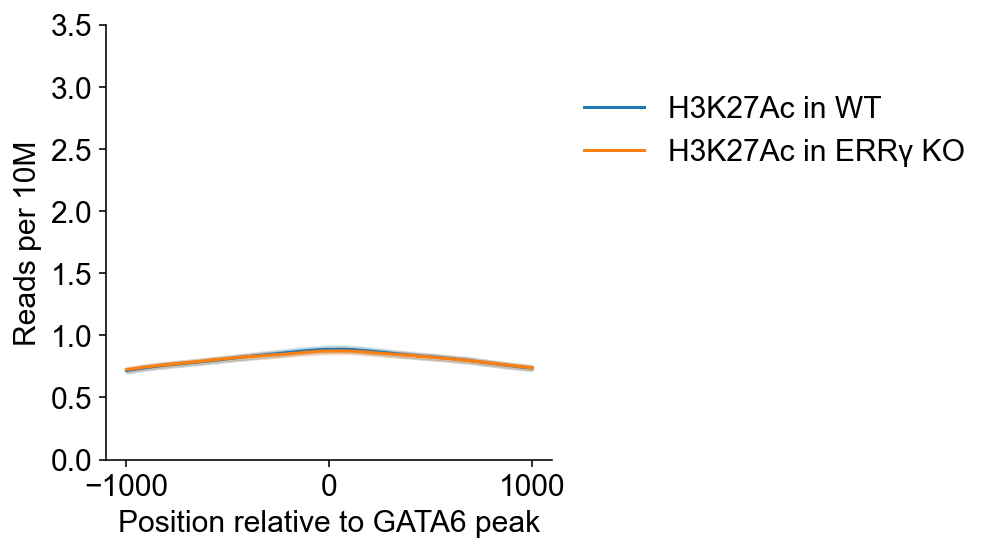

In [31]:
gata6_only_peaks = "data/ChIP-Seq/gata6/peaks/GATA6_only.peaks"
gata6_sc = homer_tools.to_short_chromnames(gata6_only_peaks)
ac_count_datasets = ["H3K27Ac-WT", "H3K27Ac-KO"]
seq_length = 2000
bin_size = 10
fig = plt.figure(figsize=[4, 4], facecolor="white")
num_peaks = homer_tools.peak_average_density_plot(gata6_sc, 
                                                  {ds.replace("-WT", " in WT").replace("-KO", " in ERRγ KO"):
                                                   os.path.join("data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/pooled_tags", ds + ".tags/") for ds in ac_count_datasets},
                                                  size=seq_length, bin_size=bin_size, recount=False)

plt.legend(bbox_to_anchor=(1.01, 0.9))
#plt.subplots_adjust(wspace=0.7, right=0.65)
#plt.title(f"H3K27Ac @ {num_peaks} GATA6-only peaks")
plt.ylim([0, 3.5])
plt.xlabel("Position relative to GATA6 peak")
#plt.savefig("pics/gata6/H3K27Ac_at_GATA6_without_ERRg_control.png", dpi=300)
plt.savefig("pics/gata6/H3K27Ac_at_GATA6_without_ERRg_control.pdf", bbox_inches="tight")

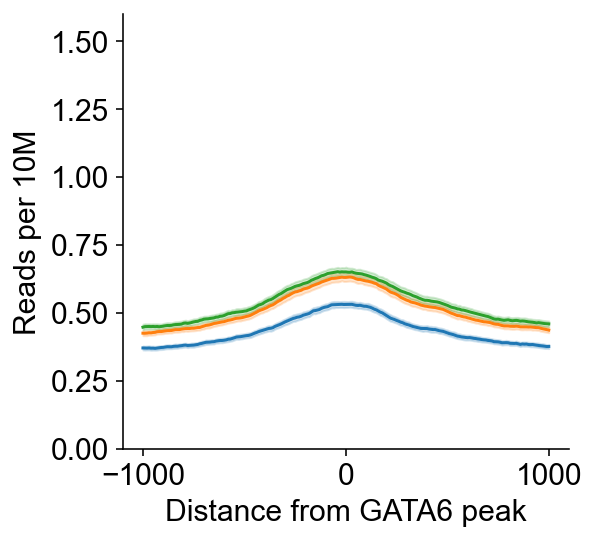

In [28]:
gata6_only_peaks = "data/ChIP-Seq/gata6/peaks/GATA6_only.peaks"
gata6_sc = homer_tools.to_short_chromnames(gata6_only_peaks)

atac_count_datasets = ["Cont", "KO1", "KO6"]
seq_length = 2000
bin_size = 10
fig = plt.figure(figsize=[4, 4], facecolor="white")
num_peaks = homer_tools.peak_average_density_plot(gata6_sc, 
                                                  {ds: os.path.join(atac_folder, ds + ".tags/") for ds in atac_count_datasets},
                                                  size=seq_length, bin_size=bin_size, recount=False)

#plt.legend(bbox_to_anchor=(1.01, 0.5))
plt.gca().get_legend().remove()
#plt.subplots_adjust(wspace=0.7, right=0.65)
#plt.title(f"ATAC @ {num_peaks} GATA6-only peaks")
plt.xlabel("Distance from GATA6 peak")
plt.ylim([0, 1.6])
#plt.savefig("pics/gata6/ATAC_at_GATA6_without_ERRg_control.png", dpi=300)
plt.savefig("pics/gata6/ATAC_at_GATA6_without_ERRg_control.pdf", bbox_inches="tight")

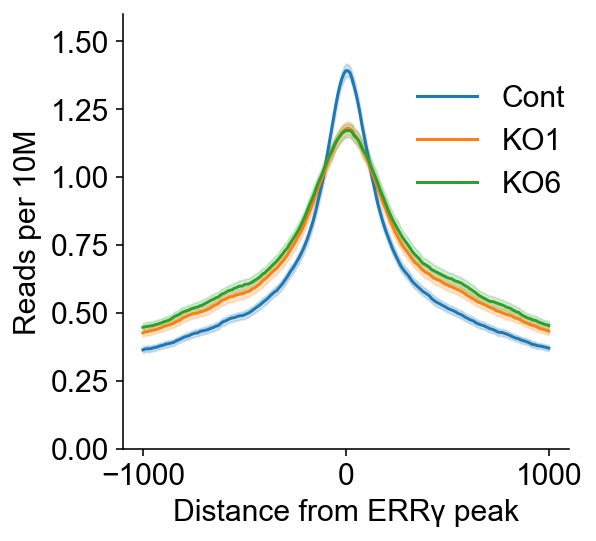

In [27]:
errg_peaks = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"

atac_count_datasets = ["Cont", "KO1", "KO6"]
seq_length = 2000
bin_size = 10
fig = plt.figure(figsize=[4, 4], facecolor="white")
num_peaks = homer_tools.peak_average_density_plot(errg_peaks, 
                                                  {ds: os.path.join(atac_folder, ds + ".tags/") for ds in atac_count_datasets},
                                                  size=seq_length, bin_size=bin_size, recount=False)

plt.legend(bbox_to_anchor=(0.6, 0.9))
#plt.subplots_adjust(wspace=0.7, right=0.65)
#plt.title(f"ATAC @ {num_peaks} ERRγ peaks")
plt.xlabel("Distance from ERRγ peak")
plt.ylim([0, 1.6])
#plt.savefig("pics/ATAC_at_ERRg_peaks2.png", dpi=300)
plt.savefig("pics/ATAC_at_ERRg_peaks2.pdf", bbox_inches="tight")

	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: data/ChIP-Seq/gata6/peaks/GATA6_only.schrom.peaks

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks	3816	0.82	-919.53

	Co-bound by 0 peaks: 51288
	Co-bound by 1 peaks: 3816 (max: 3816 effective total)
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/gata6/peaks/GATA6_only_vs_h3k27ac.coBoundBy1.txt' none -size 2000 -hist 10 -ghist -cpu 120  -d 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/Cont.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO1.tags/' 'data/ATAC-Seq/hiPSCCM-ERRagKO/tags/KO6.tags/' > 'data/ChIP-Seq/gata6/peaks/GATA6_only_vs_h3k27ac.coBoundBy1.txt.counts'


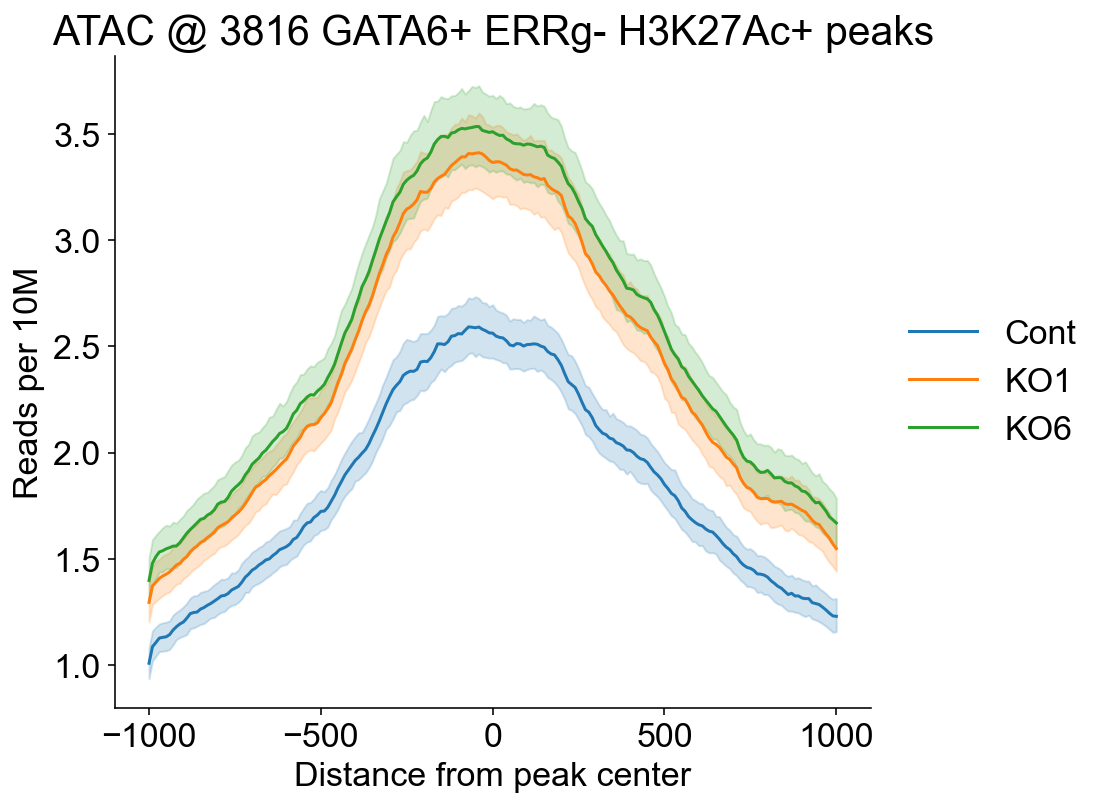

In [209]:
h3k27ac_wt_peaks_file = "data/ChIP-Seq/H3K27Ac ChIP-seq in OE ERRg and KO ERRg/peaks/H3K27Ac_WT_vs_Input_pooled.peaks"
gata6_only_peaks = "data/ChIP-Seq/gata6/peaks/GATA6_only.peaks"
gata6_sc = homer_tools.to_short_chromnames(gata6_only_peaks)
!mergePeaks '{gata6_sc}' '{h3k27ac_wt_peaks_file}' -cobound 1 -prefix 'data/ChIP-Seq/gata6/peaks/GATA6_only_vs_h3k27ac'
gata6_only_with_h3k27ac_file = "data/ChIP-Seq/gata6/peaks/GATA6_only_vs_h3k27ac.coBoundBy1.txt"

atac_count_datasets = ["Cont", "KO1", "KO6"]
seq_length = 2000
bin_size = 10
fig = plt.figure(figsize=[10, 6], facecolor="white")
num_peaks = homer_tools.peak_average_density_plot(gata6_only_with_h3k27ac_file, 
                                                  {ds: os.path.join(atac_folder, ds + ".tags/") for ds in atac_count_datasets},
                                                  size=seq_length, bin_size=bin_size, recount=True)

plt.legend(bbox_to_anchor=(1.01, 0.5))
plt.subplots_adjust(wspace=0.7, right=0.65)
plt.title(f"ATAC @ {num_peaks} GATA6+ ERRg- H3K27Ac+ peaks")
plt.savefig("pics/gata6/ATAC_at_GATA6_without_ERRg_with_H3K27AcWT_control.png", dpi=300)

	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		data/ChIP-Seq/med1/peaks/med1_se_hg38.schrom.peaks	208	1.26	-116.11

	Co-bound by 0 peaks: 33045
	Co-bound by 1 peaks: 208 (max: 208 effective total)
Create data/ChIP-Seq/med1/peaks/ERRg+SE_short.annotated.peaks
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/med1/peaks/errg_se_short.coBoundBy1.lchrom.peaks' hg38     > 'data/ChIP-Seq/med1/peaks/ERRg+SE_short.annotated.peaks'
Save data/ChIP-Seq/med1/peaks/ERRg+SE_short.bed
Running command w/120 threads: pos2bed.pl 'data/ChIP-Seq/med1/peaks/ERRg+SE_short.annotated.peaks' -o 'data/ChIP-Seq/med1/peaks/ERRg+SE_short.bed'
Add [ERRg+SE_short peaks] to tables/ERRg+SE_short_peaks.xlsx
Create pics/med1/ERRg+SE_short_peak_regions.png
Add [ERRg+SE_short|GO] to t

'data/ChIP-Seq/med1/peaks/ERRg+SE_short.annotated.peaks'

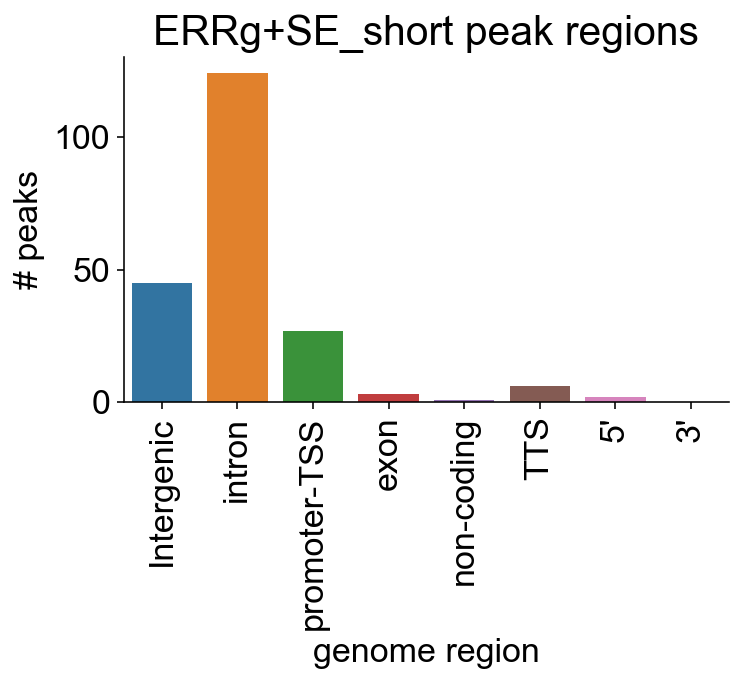

In [297]:
errg_peaks = "data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks"
se_regions = "data/ChIP-Seq/med1/peaks/med1_se_hg38.peaks"
se_regions_sc = homer_tools.to_short_chromnames(se_regions)
errg_se_short_prefix = "data/ChIP-Seq/med1/peaks/errg_se_short"
!mergePeaks '{errg_peaks}' '{se_regions_sc}' -cobound 1 -prefix '{errg_se_short_prefix}'
homer_tools.annotate_and_export(errg_se_short_prefix + ".coBoundBy1.txt", homer_genome, "human", gene_ids_map, "ERRg+SE_short", "data/ChIP-Seq/med1/peaks/", "pics/med1/",
                                tables_file="tables/ERRg+SE_short_peaks.xlsx")

In [298]:
errg_se_peaks_data = pd.read_excel("tables/ERRg+SE_short_peaks.xlsx", sheet_name="ERRg+SE_short peaks")
ko_fpkm_data = pd.read_excel("tables/ERRag_KO_hiPSC-CM_de_result_tables.xlsx", sheet_name="FPKM")
ko_fpkm_data = ko_fpkm_data.set_index("gene_id")

31 missing genes


<Figure size 720x576 with 0 Axes>

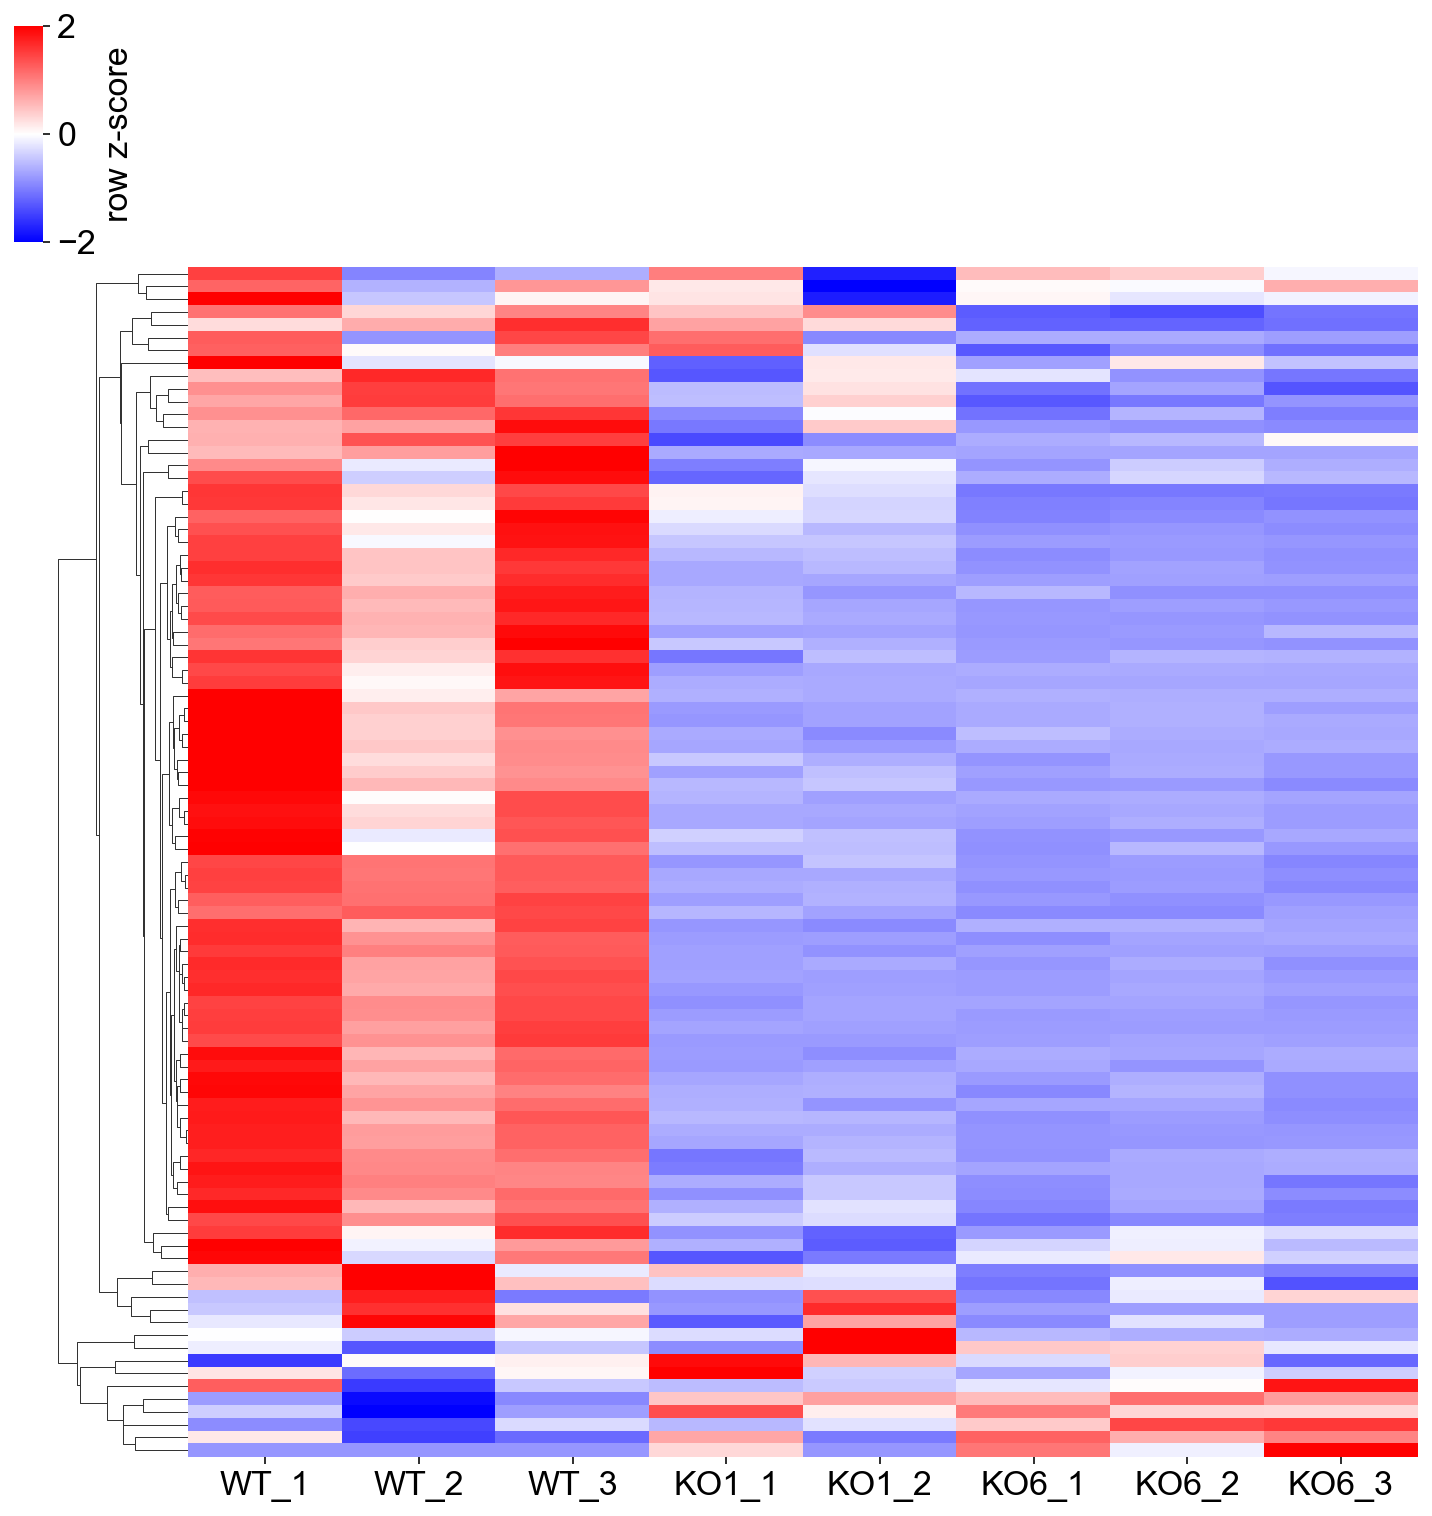

In [301]:
errg_se_genes = set(errg_se_peaks_data["Nearest Ensembl"]) - set([np.nan])
#errg_se_genes.remove("ENSG00000215991") # MIR208B
#errg_se_genes.add("ENSG00000092054") # MYH7

missing_from_map_genes = set(errg_se_genes) - set(ko_fpkm_data.index)
print(f"{len(missing_from_map_genes)} missing genes")
present_genes = set(errg_se_genes) & set(ko_fpkm_data.index)
errg_se_expression = ko_fpkm_data.loc[present_genes, :].reset_index()[["gene_id", "gene_name", "WT_1", "WT_2", "WT_3", "KO1_1", "KO1_2", "KO6_1", "KO6_2", "KO6_3",
                                                                      "KO1 vs. WT log2FoldChange", "KO1 vs. WT padj", "KO6 vs. WT log2FoldChange", "KO6 vs. WT padj"]]

errg_se_expression.iloc[:, 2:10] = scipy.stats.zscore(errg_se_expression.iloc[:, 2:10], axis=1)
plt.figure(figsize=(10, 8))
cg = sns.clustermap(errg_se_expression.iloc[:, 2:10], col_cluster=False, yticklabels=False, cmap="bwr", vmin=-2, vmax=2, cbar_pos=(0, 0.9, 0.02, 0.15),
                    dendrogram_ratio=0.1, cbar_kws={"label": "row z-score"})

#plt.subplots_adjust(top=0.8, hspace=0.1)
#plt.tight_layout()
plt.savefig("pics/med1/genes_near_ERRg+SE_peaks_heatmap.png", dpi=300, bbox_inches = "tight")

errg_se_expression = errg_se_expression.iloc[cg.dendrogram_row.reordered_ind, :]
errg_se_expression.to_excel("tables/genes_near_ERRg+SE_peaks_heatmap_zscores.xlsx", sheet_name="z-scores in dendrogram order", index=False)

# CistromeDB significance

In [312]:
cdb_index = pd.read_csv("reference/CistromeDB/human_factor_full_QC.txt", sep="\t")
cdb_index = cdb_index.set_index("GSMID")

In [ ]:
orig_peaks = "data/ChIP-Seq/gata4/peaks/ERRg+GATA4.lchrom.peaks"
cdb_top_hits = pd.read_excel("info/GATA4+ERRg[9].xlsx", sheet_name="GATA4+ERRg", skiprows=4, header=None, usecols="E:I")
cdb_top_hits = cdb_top_hits.rename(columns={4: "species", 5: "gsm_id", 6: "cell_type", 7: "factor", 8: "score"})
pvals = []
for row in tqdm(cdb_top_hits.itertuples(), total=len(cdb_top_hits)):
    cdb_id = cdb_index.loc[row.gsm_id, "DCid"]
    cdb_file = f"reference/CistromeDB/human_factor/{cdb_id}_sort_peaks.narrowPeak.bed"
    assert os.path.exists(cdb_file)
    with misc.TempFileName() as tmp:
        cdb_peaks = tmp + ".cdb.peaks"
        homer_tools.bed_file_to_peak(cdb_file, output_peaks=cdb_peaks)
        homer_tools.merge_peaks([orig_peaks, cdb_peaks], output_peak_file=tmp, genome_size=9e8, max_distance="given")
        pval_matrix_file = misc.replace_extension(tmp, "matrix.logPvalue.matrix.txt")
        pval_data = pd.read_csv(pval_matrix_file, sep="\t")
        p_value = np.exp(float(pval_data.iloc[0, 2]))
        pvals.append(p_value)
        
cdb_top_hits["p_value (Bonferroni)"] = np.array(pvals) * len(cdb_index)
wb = openpyxl.Workbook()
misc.write_dataframe_to_worksheet(wb.create_sheet("ERRg+GATA4"), cdb_top_hits)

In [ ]:
orig_peaks = "data/ChIP-Seq/gata4/peaks/ERRg_only.lchrom.peaks"
cdb_top_hits = pd.read_excel("info/GATA4+ERRg[9].xlsx", sheet_name="ERRg only", skiprows=4, header=None, usecols="D:H")
cdb_top_hits = cdb_top_hits.rename(columns={3: "species", 4: "gsm_id", 5: "cell_type", 6: "factor", 7: "score"})
pvals = []
for row in tqdm(cdb_top_hits.itertuples(), total=len(cdb_top_hits)):
    cdb_id = cdb_index.loc[row.gsm_id, "DCid"]
    cdb_file = f"reference/CistromeDB/human_factor/{cdb_id}_sort_peaks.narrowPeak.bed"
    assert os.path.exists(cdb_file)
    with misc.TempFileName() as tmp:
        cdb_peaks = tmp + ".cdb.peaks"
        homer_tools.bed_file_to_peak(cdb_file, output_peaks=cdb_peaks)
        homer_tools.merge_peaks([orig_peaks, cdb_peaks], output_peak_file=tmp, genome_size=9e8, max_distance="given")
        pval_matrix_file = misc.replace_extension(tmp, "matrix.logPvalue.matrix.txt")
        pval_data = pd.read_csv(pval_matrix_file, sep="\t")
        p_value = np.exp(float(pval_data.iloc[0, 2]))
        pvals.append(p_value)
        
cdb_top_hits["p_value (Bonferroni)"] = np.array(pvals) * len(cdb_index)
misc.write_dataframe_to_worksheet(wb.create_sheet("ERRg without GATA4"), cdb_top_hits)
wb.save("tables/ERRg+GATA4_CistromeDB_significance.xlsx")

In [327]:
len(cdb_index)

11348